# **Assignment: Proximal Policy Optimization (PPO) with Brax and CleanRL**

In this assignment you will experiment with **Proximal Policy Optimization (PPO)**—-one of the most widely used algorithms in modern reinforcement learning. In this notebook, we will leverage **Brax**, a fast differentiable physics engine, to simulate environments, and **CleanRL**, an open-source collection of high-quality single-file implementations of reinforcement learning algorithms, to implement and train agents efficiently.

By the end of this assignment, you will:

- Understand the core concepts behind PPO, including policy updates and clipping mechanisms.
- Learn how to set up and run environments using Brax.
- Use CleanRL to train and evaluate PPO-based agents.

In [9]:
# @markdown Update gym

!pip install --upgrade gym --quiet

In [10]:
# @markdown Imports
# Import Brax and necessary helper modules
from IPython.display import clear_output, HTML
from datetime import datetime
from typing import Any, Callable, Dict, Optional, Sequence
from dataclasses import dataclass
import os
import time
import math
import random
import collections
import functools

import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
from tqdm import tqdm

# Brax imports
try:
    import brax
except ImportError:
    !pip install git+https://github.com/google/brax.git@main
    clear_output()
    import brax

from brax import envs as brax_envs
from brax.envs.wrappers import gym as gym_wrapper
from brax.envs.wrappers import torch as torch_wrapper
from brax.io import metrics, html
from brax.io.torch import jax_to_torch, torch_to_jax

import jax

## **Introduction to Brax**

**Brax** is a fast, differentiable physics engine designed for large-scale reinforcement learning and robotics simulations. Developed by Google, it allows for high-performance simulation of rigid body dynamics and integrates seamlessly with modern machine learning frameworks such as JAX, enabling automatic differentiation and efficient optimization.

GitHub: [https://github.com/google/brax](https://github.com/google/brax)

Paper: [Brax -- A Differentiable Physics Engine for Large Scale Rigid Body Simulation](https://arxiv.org/abs/2106.13281)


Key features of Brax include:

- **Speed**: Brax is built for fast simulations, taking full advantage of hardware accelerators like GPUs and TPUs.
- **Differentiability**: Unlike traditional physics engines, Brax is fully differentiable, which allows for gradient-based optimization of physical systems.
- **Parallelization**: Brax can run multiple environments in parallel, making it ideal for training reinforcement learning agents at scale.
- **Custom Environments**: It comes with a variety of predefined environments (e.g., `humanoid`, `ant`, `reacher`) and supports creating custom environments tailored to specific tasks.

Brax is an excellent tool for accelerating research and experimentation in reinforcement learning, especially when paired with algorithms like PPO.

In [11]:
#@title Example Environment { run: "auto" }

env_name = 'humanoid'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']

env = brax_envs.get_environment(env_name=env_name)
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

# NOTE: Jupyter notebook may not render the HTML correctly, please use a local HTML file to view the environment (see below)
HTML(html.render(env.sys, [state.pipeline_state]))

Jupyter notebook may not support rendering the HTML output of Brax environments. To visualize the environment, you can save the HTML output to a file and open it in a browser. Here's an example of how you can do this:

```python
with open('env_visualization.html', 'w') as f:
  f.write(env_html)
```

## **Proximal Policy Optimization (PPO)**

**Proximal Policy Optimization (PPO)** is a widely used reinforcement learning algorithm developed by OpenAI. It balances complexity and performance, making it highly popular for tasks involving continuous control and large-scale environments.

Paper: [https://arxiv.org/abs/1707.06347](https://arxiv.org/abs/1707.06347)

PPO works by improving the policy in small, stable steps, avoiding drastic updates that can destabilize training. It introduces a **clipping mechanism** in the objective function to limit how much the new policy can deviate from the old policy, ensuring updates are more conservative and stable. Key benefits of PPO include:

- **Sample Efficiency**: By reusing data through multiple epochs, PPO improves learning efficiency.
- **Stability**: The clipping function prevents overly aggressive policy updates, leading to smoother training.
- **Versatility**: PPO can be applied to both continuous and discrete action spaces, making it suitable for a wide variety of environments.

### **CleanRL: A Simple and Efficient RL Framework**

**CleanRL** is an open-source library focused on providing high-quality, single-file implementations of various reinforcement learning algorithms, including PPO. The primary goal of CleanRL is to make it easy for researchers and developers to run state-of-the-art RL algorithms with minimal setup while maintaining simplicity and readability in the codebase.

GitHub: [https://github.com/vwxyzjn/cleanrl](https://github.com/vwxyzjn/cleanrl)

CleanRL's advantages include:

- **Simplicity**: CleanRL is designed to be as minimalistic as possible, with each algorithm implementation contained in a single file.
- **Reproducibility**: The library ensures experiments are easy to reproduce, with minimal dependencies and simple configuration options.
- **Performance**: Despite its simplicity, CleanRL is highly efficient and performs comparably to more complex RL frameworks.

In this assignment, we will use CleanRL's implementation of PPO to train and evaluate agents in Brax environments. CleanRL provides us with a straightforward way to run PPO while ensuring performance and reproducibility.

## **Deliverables**

### A. Code

Complete all the TODOs mentioned below in the following sections:

1. **Agent Definition**
2. **Environment Definition**
3. **PPO Training**
4. **Reward Plot**

### B. Results
Run your PPO code for the following environments
1. ant
2. halfcheetah
3. walker2d
4. humanoid

Run your PPO implementation for the following environments:

1. `ant`
2. `halfcheetah`
3. `walker2d`
4. `humanoid`

Use the results to create a report containing the following information:

**a. Show plots for at least three sets of hyperparameters:**

For each set, plot the average total reward versus iteration. Use the `avg_total_reward` variable from the provided code. Tune the hyperparameters with the goal of achieving the highest reward in fewer iterations. It is recommended to keep the `total_timesteps` under 100,000,000 to maintain training times under three hours.

**b. Explain why `humanoid` is a difficult environment to train on.**

**c. Upload GIFs:**

Along with the plots, record and save a GIF of your best model for each of the three environments. Upload the three GIFs.

In [12]:
# @title **Agent Definition (PPO)** (Complete all the TODOs)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer

class StateNormalizer:
    def __init__(self, shape, epsilon=1e-8, device='cuda'):
        # The shape should match the observation space dimensions
        self.mean = torch.zeros(shape).to(device)
        self.var = torch.ones(shape).to(device)
        self.epsilon = epsilon
        self.count = 0

    def update(self, x):
        batch_mean = torch.mean(x, dim=0)
        batch_var = torch.var(x, dim=0, unbiased=False)
        batch_count = x.shape[0]

        self.mean = (self.mean * self.count + batch_mean * batch_count) / (self.count + batch_count)
        self.var = (self.var * self.count + batch_var * batch_count) / (self.count + batch_count)
        self.count += batch_count

    def normalize(self, x):
        # TODO: Normalize input x using the mean and variance. Return the normalized output.
        normalized_x = (x - self.mean) / (self.var + self.epsilon).sqrt()
        return normalized_x


class Agent(nn.Module):
    def __init__(self, envs, device):
        super().__init__()
        # Hint: Use the envs.(spaces) to get the dimensions required
        # TODO: Add a critic network estimates the value funciton that maps a state vector to a scalar value
        self.critic = nn.Sequential(
            layer_init(nn.Linear(envs.observation_space.shape[1], 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, 1))
        ).to(device)

        # TODO: Add a deterministic actor network that estimates the policy, this network should map a state vector to a action vector
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(envs.observation_space.shape[1], 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, 64)),
            nn.ReLU(),
            layer_init(nn.Linear(64, envs.action_space.shape[1]))
        ).to(device)

        # TODO: Define a parameter for log standard deviation of the action distribution
        self.actor_logstd = nn.Parameter(torch.zeros(1, envs.action_space.shape[1]).to(device))

        # TODO: Initialize the StateNormalizer with appropriate shape and device.
        self.state_normalizer = StateNormalizer(envs.observation_space.shape[1], device=device)

    def get_value(self, x):
        # TODO: Pass input x through the critic network and return the output.
        return self.critic(x)

    def update_normalizer(self, x):
        # TODO: Update the state normalizer with input x
        self.state_normalizer.update(x)

    def get_action_and_value(self, x, action=None):
        # TODO: Normalize x using the state normalizer
        x = self.state_normalizer.normalize(x)

        # TODO: Pass x through the actor network to get action mean
        action_mean = self.actor_mean(x)

        # TODO: Expand actor_logstd to match the shape of action_mean and calculate action_std
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = action_logstd.exp()

        # TODO: Define a probability distribution for actions using the Normal distribution
        probs = Normal(action_mean, action_std)

        if action is None:
            action = probs.sample()

        # For consistency, using self.get_value(x) instead of self.critic(x)
        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), self.get_value(x)

In [13]:
# @title **Environment Definition**  (Complete all the TODOs)

def make_env(num_envs = 2048, env_name = 'ant', episode_length = 1000):

    envs = brax_envs.create(env_name, batch_size=num_envs,
                    episode_length=episode_length)

    # TODO: Wrap the environment using gym_wrapper.VectorGymWrapper to handle multiple environments simultaneously
    envs = gym_wrapper.VectorGymWrapper(envs)
    # TODO: Wrap the environment with torch_wrapper.TorchWrapper to ensure compatibility with PyTorch and specify the device
    envs = torch_wrapper.TorchWrapper(envs, device=device)

    return envs

In [14]:
# @title Hyperparameters { display-mode: "form" }

env_id = "humanoid"  # @param {type: "string"}
learning_rate = 1e-4  # @param {type: "number"}
num_steps = 8  # @param {type: "integer"}
num_envs = 1024  # @param {type: "integer"}
seed = 42  # @param {type: "integer"}
anneal_lr = True  # @param {type: "boolean"}
gamma = 0.99  # @param {type: "number"}
gae_lambda = 0.95  # @param {type: "number"}
update_epochs = 10  # @param {type: "integer"}
clip_coef = 0.25  # @param {type: "number"}
norm_adv = True  # @param {type: "boolean"}
clip_vloss = False  # @param {type: "boolean"}
ent_coef = 0.0005  # @param {type: "number"}
vf_coef = 0.5  # @param {type: "number"}
max_grad_norm = 0.5  # @param {type: "number"}
target_kl = None  # @param ["None", 0.01, 0.05, 0.1] {type: "raw"}
num_minibatches = 32  # @param {type: "integer"}
total_timesteps = 10000000  # @param {type: "integer"}

minibatch_size = 10  # @param {type: "integer"}
batch_size = 128  # @param {type: "integer"}
num_iterations = 100  # @param {type: "integer"}

# Consolidating into the args dictionary
args = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'num_steps': num_steps,
    'num_envs': num_envs,
    'seed': seed,
    'anneal_lr': anneal_lr,
    'gamma': gamma,
    'gae_lambda': gae_lambda,
    'update_epochs': update_epochs,
    'clip_coef': clip_coef,
    'norm_adv': norm_adv,
    'clip_vloss': clip_vloss,
    'ent_coef': ent_coef,
    'vf_coef': vf_coef,
    'max_grad_norm': max_grad_norm,
    'target_kl': target_kl,
    'num_minibatches': num_minibatches,
    'total_timesteps': total_timesteps,
    'minibatch_size': minibatch_size,
    'batch_size': batch_size,
    'num_iterations': num_iterations,
}

class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args = Args(**args)
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)
args.num_iterations = args.total_timesteps // args.batch_size

In [15]:
# @title Initailization

envs = make_env(num_envs=args.num_envs, env_name=args.env_id, episode_length=500)
agent = Agent(envs, device).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

# Algorithm Logic: Storage setup
obs = torch.zeros((args.num_steps,) + envs.observation_space.shape).to(device)
actions = torch.zeros((args.num_steps,) + envs.action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)

In [16]:
# @title PPO training (Complete all the TODOs)

iterations = []
avg_rewards = []

global_step = 0
start_time = time.time()

# TODO: Reset the environment and initialize tracking variables for observations, rewards, and episode lengths
next_obs = envs.reset()

next_done = torch.zeros(args.num_envs).to(device)
total_rewards = torch.zeros(args.num_envs).to(device)
episode_lengths = torch.zeros(args.num_envs).to(device)
episode_rewards_list = []  # Store total rewards for completed episodes
episode_lengths_list = []  # Store episode lengths for completed episodes
completed_episodes = 0  # Counter for completed episodes

for iteration in tqdm(range(1, args.num_iterations + 1)):
    # Annealing the learning rate if instructed to do so
    if args.anneal_lr:
        frac = 1.0 - (iteration - 1.0) / args.num_iterations
        lrnow = frac * args.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, args.num_steps):
        global_step += args.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # Algorithm logic: action logic
        with torch.no_grad():
            # TODO: Update the state normalizer with the new observation
            # agent.update_normalizer(None)
            agent.update_normalizer(next_obs)

            # TODO: Get action, log probability, entropy, and value from the agent
            action, logprob, entropy, value = agent.get_action_and_value(next_obs)

            values[step] = value.flatten()

        actions[step] = action
        logprobs[step] = logprob

        # TODO: Step through the environment simulator and obtain next_obs, reward, next_done, infos
        next_obs, reward, next_done, infos = envs.step(action)
        rewards[step] = reward.view(-1)

        # Accumulate rewards
        total_rewards += reward.view(-1)
        episode_lengths += 1
        for i in range(args.num_envs):
            if next_done[i]:  # If done is True, an episode has ended
                episode_rewards_list.append(total_rewards[i].item())
                episode_lengths_list.append(episode_lengths[i].item())
                total_rewards[i] = 0  # Reset accumulated reward for that environment
                episode_lengths[i] = 0
                completed_episodes += 1

        # Only keep the last args.num_envs episodes for averaging
        if len(episode_rewards_list) > args.num_envs:
            episode_rewards_list.pop(0)

    # At the end of the iteration, print the average total reward
    if completed_episodes > 0:
        avg_total_reward = np.mean(episode_rewards_list)
        avg_ep_length = np.mean(episode_lengths_list)
        print(f"Iteration {iteration}: Average total reward: {avg_total_reward:.2f}, Length: {avg_ep_length}")
        iterations.append(iteration)
        avg_rewards.append(avg_total_reward)

    # Bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(args.num_steps)):
            if t == args.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]

            # TODO: Calculate the TD error (delta) for the current time step t
            # 1. Combining the immediate reward at time t with the discounted estimated value at the next step (nextvalues).
            # 2. Subtracting the value estimate at time t to get the temporal difference error.
            # 3. Use this delta to compute the advantage for time step t, incorporating the discount factor (gamma) and
            #    GAE lambda (gae_lambda) to calculate a running advantage (lastgaelam) that accumulates over time.

            # delta =
            # advantages[t] =
            delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam

        returns = advantages + values

    # Flatten the batch
    b_obs = obs.reshape((-1,) + envs.observation_space.shape[-1:])
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.action_space.shape[-1:])
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(args.batch_size)
    clipfracs = []
    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # Calculate approximate KL divergence, http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if args.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            # TODO: Calculate the policy (surrogate) loss using the clipped PPO objective
            # 1. Compute `pg_loss1` as the standard policy gradient loss, which multiplies the advantage (`mb_advantages`)
            #    by the probability ratio (`ratio`) of the new policy to the old policy. This term represents the "unclipped" objective.
            # 2. Calculate `pg_loss2` by clipping `ratio` to the range [1 - clip_coef, 1 + clip_coef], where `clip_coef` is a small
            #    constant (typically 0.1-0.3). This clipping limits how far the policy is allowed to deviate from the old policy.
            # 3. Set `pg_loss` to the maximum of `pg_loss1` and `pg_loss2` to prevent large updates that could destabilize training.
            # 4. Finally, take the mean of `pg_loss` to obtain the overall policy loss for the minibatch.
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1-args.clip_coef, 1+args.clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if args.clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -args.clip_coef,
                    args.clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            # TODO: Compute the total loss for PPO, combining policy loss, entropy regularization, and value loss.
            # 1. Calculate `entropy_loss` by taking the mean of the entropy values. This term encourages exploration by
            #    penalizing certainty in the policy distribution, pushing the agent toward a more stochastic policy.
            # 2. Combine the losses to form the total loss:
            #    - Start with `pg_loss` (the policy loss), which drives the agent to choose actions that increase the advantage.
            #    - Subtract `entropy_loss` scaled by `ent_coef` (an entropy coefficient), encouraging a balance between
            #      exploration (higher entropy) and exploitation (lower entropy).
            #    - Add `v_loss` (the value loss) scaled by `vf_coef` (a value function coefficient), which tunes the weight of
            #      the value function's contribution to the total loss.
            # 3. The result is a loss that balances the policy improvement, exploration, and value estimation terms.
            entropy_loss = entropy.mean()
            loss = pg_loss - args.ent_coef * entropy_loss + args.vf_coef * v_loss

            # TODO: Perform a gradient update step with gradient clipping to stabilize training.
            # 1. Reset gradients in the optimizer with `optimizer.zero_grad()` to ensure no accumulation of gradients
            #    from previous steps.
            # 2. Backpropagate through the computation graph with `loss.backward()`, calculating gradients for all
            #    parameters based on the current `loss`.
            # 3. Clip the gradients using `clip_grad_norm_`, which constrains the gradient norms of the agent’s parameters
            #    to be within `max_grad_norm`. This helps prevent excessively large updates that could destabilize training.
            # 4. Finally, apply the gradients to the model parameters by calling `optimizer.step()`.

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
            optimizer.step()


        if args.target_kl is not None and approx_kl > args.target_kl:
            break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

  0%|          | 1/1220 [00:29<9:50:47, 29.08s/it]

Iteration 2: Average total reward: 28.42, Length: 15.926666666666666


  0%|          | 2/1220 [00:31<4:26:47, 13.14s/it]

Iteration 3: Average total reward: 54.41, Length: 18.426791277258566


  0%|          | 3/1220 [00:33<2:42:59,  8.04s/it]

Iteration 4: Average total reward: 56.30, Length: 18.813840155945417


  0%|          | 4/1220 [00:34<1:53:49,  5.62s/it]

Iteration 5: Average total reward: 64.73, Length: 18.636865342163354


  0%|          | 5/1220 [00:36<1:26:54,  4.29s/it]

Iteration 6: Average total reward: 67.04, Length: 18.983959899749372


  0%|          | 6/1220 [00:38<1:10:27,  3.48s/it]

Iteration 7: Average total reward: 69.33, Length: 18.974850299401197


  1%|          | 7/1220 [00:40<59:58,  2.97s/it]  

Iteration 8: Average total reward: 71.55, Length: 19.217016879090597


  1%|          | 8/1220 [00:42<53:07,  2.63s/it]

Iteration 9: Average total reward: 72.73, Length: 19.325863678804854


  1%|          | 9/1220 [00:44<48:34,  2.41s/it]

Iteration 10: Average total reward: 74.31, Length: 19.451317912856375


  1%|          | 10/1220 [00:46<45:35,  2.26s/it]

Iteration 11: Average total reward: 75.45, Length: 19.619557103757153


  1%|          | 11/1220 [00:48<43:10,  2.14s/it]

Iteration 12: Average total reward: 76.25, Length: 19.664653243847876


  1%|          | 12/1220 [00:50<41:33,  2.06s/it]

Iteration 13: Average total reward: 77.07, Length: 19.750258638526795


  1%|          | 13/1220 [00:52<40:26,  2.01s/it]

Iteration 14: Average total reward: 77.78, Length: 19.828664620107446


  1%|          | 14/1220 [00:53<39:45,  1.98s/it]

Iteration 15: Average total reward: 78.60, Length: 19.940999823352765


  1%|          | 15/1220 [00:55<39:29,  1.97s/it]

Iteration 16: Average total reward: 79.13, Length: 19.996171133677375


  1%|▏         | 16/1220 [00:57<39:20,  1.96s/it]

Iteration 17: Average total reward: 79.59, Length: 20.04455522667082


  1%|▏         | 17/1220 [00:59<38:47,  1.94s/it]

Iteration 18: Average total reward: 80.09, Length: 20.102846244131456


  1%|▏         | 18/1220 [01:01<38:36,  1.93s/it]

Iteration 19: Average total reward: 80.48, Length: 20.136799666342277


  2%|▏         | 19/1220 [01:03<38:30,  1.92s/it]

Iteration 20: Average total reward: 80.83, Length: 20.16763157894737


  2%|▏         | 20/1220 [01:05<38:26,  1.92s/it]

Iteration 21: Average total reward: 81.15, Length: 20.203013182674198


  2%|▏         | 21/1220 [01:07<38:15,  1.91s/it]

Iteration 22: Average total reward: 81.50, Length: 20.244135950215416


  2%|▏         | 22/1220 [01:09<38:11,  1.91s/it]

Iteration 23: Average total reward: 81.90, Length: 20.312299587723317


  2%|▏         | 23/1220 [01:11<38:00,  1.91s/it]

Iteration 24: Average total reward: 82.21, Length: 20.361068366673994


  2%|▏         | 24/1220 [01:13<37:47,  1.90s/it]

Iteration 25: Average total reward: 82.52, Length: 20.40918184689902


  2%|▏         | 25/1220 [01:14<37:37,  1.89s/it]

Iteration 26: Average total reward: 82.86, Length: 20.466848871343252


  2%|▏         | 26/1220 [01:16<37:31,  1.89s/it]

Iteration 27: Average total reward: 83.09, Length: 20.495808149736792


  2%|▏         | 27/1220 [01:18<37:37,  1.89s/it]

Iteration 28: Average total reward: 83.32, Length: 20.52769404672193


  2%|▏         | 28/1220 [01:20<38:17,  1.93s/it]

Iteration 29: Average total reward: 83.56, Length: 20.56026117711073


  2%|▏         | 29/1220 [01:22<38:12,  1.92s/it]

Iteration 30: Average total reward: 83.80, Length: 20.60251119501273


  2%|▏         | 30/1220 [01:24<38:01,  1.92s/it]

Iteration 31: Average total reward: 84.02, Length: 20.631364215894603


  3%|▎         | 31/1220 [01:26<37:56,  1.91s/it]

Iteration 32: Average total reward: 84.24, Length: 20.662278897573014


  3%|▎         | 32/1220 [01:28<37:43,  1.90s/it]

Iteration 33: Average total reward: 84.42, Length: 20.693501920614597


  3%|▎         | 33/1220 [01:30<37:34,  1.90s/it]

Iteration 34: Average total reward: 84.66, Length: 20.73485554520037


  3%|▎         | 34/1220 [01:32<37:47,  1.91s/it]

Iteration 35: Average total reward: 84.89, Length: 20.77853967297114


  3%|▎         | 35/1220 [01:34<37:44,  1.91s/it]

Iteration 36: Average total reward: 85.05, Length: 20.801893022232004


  3%|▎         | 36/1220 [01:35<37:31,  1.90s/it]

Iteration 37: Average total reward: 85.26, Length: 20.83942857142857


  3%|▎         | 37/1220 [01:37<37:22,  1.90s/it]

Iteration 38: Average total reward: 85.41, Length: 20.858652575957727


  3%|▎         | 38/1220 [01:39<37:17,  1.89s/it]

Iteration 39: Average total reward: 85.57, Length: 20.887095680477387


  3%|▎         | 39/1220 [01:41<37:14,  1.89s/it]

Iteration 40: Average total reward: 85.74, Length: 20.912196088794925


  3%|▎         | 40/1220 [01:43<37:27,  1.90s/it]

Iteration 41: Average total reward: 85.92, Length: 20.945965138799224


  3%|▎         | 41/1220 [01:45<37:22,  1.90s/it]

Iteration 42: Average total reward: 86.08, Length: 20.974675570114652


  3%|▎         | 42/1220 [01:47<37:19,  1.90s/it]

Iteration 43: Average total reward: 86.20, Length: 20.98971928096528


  4%|▎         | 43/1220 [01:49<37:14,  1.90s/it]

Iteration 44: Average total reward: 86.31, Length: 21.000962406015038


  4%|▎         | 44/1220 [01:51<37:08,  1.90s/it]

Iteration 45: Average total reward: 86.45, Length: 21.02271256251839


  4%|▎         | 45/1220 [01:53<37:01,  1.89s/it]

Iteration 46: Average total reward: 86.61, Length: 21.05048409405256


  4%|▍         | 46/1220 [01:54<36:56,  1.89s/it]

Iteration 47: Average total reward: 86.74, Length: 21.073576708232242


  4%|▍         | 47/1220 [01:56<36:48,  1.88s/it]

Iteration 48: Average total reward: 86.89, Length: 21.101950599546885


  4%|▍         | 48/1220 [01:58<36:52,  1.89s/it]

Iteration 49: Average total reward: 87.01, Length: 21.124031427797345


  4%|▍         | 49/1220 [02:00<36:51,  1.89s/it]

Iteration 50: Average total reward: 87.15, Length: 21.148057737210785


  4%|▍         | 50/1220 [02:02<36:52,  1.89s/it]

Iteration 51: Average total reward: 87.26, Length: 21.16340447683498


  4%|▍         | 51/1220 [02:04<36:49,  1.89s/it]

Iteration 52: Average total reward: 87.37, Length: 21.181692661723343


  4%|▍         | 52/1220 [02:06<36:47,  1.89s/it]

Iteration 53: Average total reward: 87.45, Length: 21.195869052990425


  4%|▍         | 53/1220 [02:08<36:47,  1.89s/it]

Iteration 54: Average total reward: 87.55, Length: 21.2138182176074


  4%|▍         | 54/1220 [02:09<36:38,  1.89s/it]

Iteration 55: Average total reward: 87.63, Length: 21.224687062007636


  5%|▍         | 55/1220 [02:11<36:30,  1.88s/it]

Iteration 56: Average total reward: 87.72, Length: 21.237923336341613


  5%|▍         | 56/1220 [02:13<36:29,  1.88s/it]

Iteration 57: Average total reward: 87.84, Length: 21.259238521836505


  5%|▍         | 57/1220 [02:15<36:32,  1.89s/it]

Iteration 58: Average total reward: 87.98, Length: 21.284218742825658


  5%|▍         | 58/1220 [02:17<36:53,  1.90s/it]

Iteration 59: Average total reward: 88.05, Length: 21.29335859953077


  5%|▍         | 59/1220 [02:19<37:06,  1.92s/it]

Iteration 60: Average total reward: 88.17, Length: 21.314647137150466


  5%|▍         | 60/1220 [02:21<37:12,  1.92s/it]

Iteration 61: Average total reward: 88.25, Length: 21.328426018959416


  5%|▌         | 61/1220 [02:23<37:02,  1.92s/it]

Iteration 62: Average total reward: 88.31, Length: 21.339168207819018


  5%|▌         | 62/1220 [02:25<36:48,  1.91s/it]

Iteration 63: Average total reward: 88.44, Length: 21.363089437783334


  5%|▌         | 63/1220 [02:27<36:38,  1.90s/it]

Iteration 64: Average total reward: 88.56, Length: 21.384175842509176


  5%|▌         | 64/1220 [02:29<36:39,  1.90s/it]

Iteration 65: Average total reward: 88.66, Length: 21.402146646379077


  5%|▌         | 65/1220 [02:30<36:35,  1.90s/it]

Iteration 66: Average total reward: 88.75, Length: 21.41945411840933


  5%|▌         | 66/1220 [02:32<36:34,  1.90s/it]

Iteration 67: Average total reward: 88.86, Length: 21.43905065815716


  5%|▌         | 67/1220 [02:34<36:32,  1.90s/it]

Iteration 68: Average total reward: 88.93, Length: 21.453716083366103


  6%|▌         | 68/1220 [02:36<36:28,  1.90s/it]

Iteration 69: Average total reward: 89.01, Length: 21.467318739326192


  6%|▌         | 69/1220 [02:38<36:29,  1.90s/it]

Iteration 70: Average total reward: 89.12, Length: 21.486091448249475


  6%|▌         | 70/1220 [02:40<36:33,  1.91s/it]

Iteration 71: Average total reward: 89.22, Length: 21.50537756141741


  6%|▌         | 71/1220 [02:42<36:32,  1.91s/it]

Iteration 72: Average total reward: 89.31, Length: 21.52356137869426


  6%|▌         | 72/1220 [02:44<36:23,  1.90s/it]

Iteration 73: Average total reward: 89.40, Length: 21.539877300613497


  6%|▌         | 73/1220 [02:46<36:16,  1.90s/it]

Iteration 74: Average total reward: 89.47, Length: 21.55062694788722


  6%|▌         | 74/1220 [02:48<36:07,  1.89s/it]

Iteration 75: Average total reward: 89.52, Length: 21.55996993450016


  6%|▌         | 75/1220 [02:49<36:02,  1.89s/it]

Iteration 76: Average total reward: 89.59, Length: 21.574244833068363


  6%|▌         | 76/1220 [02:51<36:06,  1.89s/it]

Iteration 77: Average total reward: 89.66, Length: 21.586614585149793


  6%|▋         | 77/1220 [02:53<36:06,  1.90s/it]

Iteration 78: Average total reward: 89.74, Length: 21.60421836228288


  6%|▋         | 78/1220 [02:55<36:01,  1.89s/it]

Iteration 79: Average total reward: 89.84, Length: 21.623176082446175


  6%|▋         | 79/1220 [02:57<36:03,  1.90s/it]

Iteration 80: Average total reward: 89.90, Length: 21.634350426775992


  7%|▋         | 80/1220 [02:59<35:59,  1.89s/it]

Iteration 81: Average total reward: 89.97, Length: 21.64718197527582


  7%|▋         | 81/1220 [03:01<35:53,  1.89s/it]

Iteration 82: Average total reward: 90.03, Length: 21.658110680758877


  7%|▋         | 82/1220 [03:03<35:56,  1.89s/it]

Iteration 83: Average total reward: 90.11, Length: 21.674407290889633


  7%|▋         | 83/1220 [03:05<35:57,  1.90s/it]

Iteration 84: Average total reward: 90.17, Length: 21.684904268625125


  7%|▋         | 84/1220 [03:06<35:47,  1.89s/it]

Iteration 85: Average total reward: 90.23, Length: 21.696133122028527


  7%|▋         | 85/1220 [03:08<35:37,  1.88s/it]

Iteration 86: Average total reward: 90.29, Length: 21.70917183875619


  7%|▋         | 86/1220 [03:10<35:26,  1.88s/it]

Iteration 87: Average total reward: 90.37, Length: 21.72266980664353


  7%|▋         | 87/1220 [03:12<35:22,  1.87s/it]

Iteration 88: Average total reward: 90.42, Length: 21.73439990192473


  7%|▋         | 88/1220 [03:14<35:20,  1.87s/it]

Iteration 89: Average total reward: 90.47, Length: 21.74356642720742


  7%|▋         | 89/1220 [03:16<35:33,  1.89s/it]

Iteration 90: Average total reward: 90.53, Length: 21.75684346235721


  7%|▋         | 90/1220 [03:18<35:25,  1.88s/it]

Iteration 91: Average total reward: 90.58, Length: 21.76809142178688


  7%|▋         | 91/1220 [03:20<35:16,  1.87s/it]

Iteration 92: Average total reward: 90.63, Length: 21.777020876765423


  8%|▊         | 92/1220 [03:21<35:18,  1.88s/it]

Iteration 93: Average total reward: 90.70, Length: 21.79270454875745


  8%|▊         | 93/1220 [03:23<35:27,  1.89s/it]

Iteration 94: Average total reward: 90.76, Length: 21.80463738097293


  8%|▊         | 94/1220 [03:25<35:24,  1.89s/it]

Iteration 95: Average total reward: 90.82, Length: 21.817480207324714


  8%|▊         | 95/1220 [03:27<35:28,  1.89s/it]

Iteration 96: Average total reward: 90.88, Length: 21.829939072548797


  8%|▊         | 96/1220 [03:29<35:26,  1.89s/it]

Iteration 97: Average total reward: 90.96, Length: 21.848265855632132


  8%|▊         | 97/1220 [03:31<35:29,  1.90s/it]

Iteration 98: Average total reward: 91.02, Length: 21.861182519280206


  8%|▊         | 98/1220 [03:33<35:26,  1.90s/it]

Iteration 99: Average total reward: 91.06, Length: 21.869561648333608


  8%|▊         | 99/1220 [03:35<35:21,  1.89s/it]

Iteration 100: Average total reward: 91.10, Length: 21.87463074880078


  8%|▊         | 100/1220 [03:37<35:21,  1.89s/it]

Iteration 101: Average total reward: 91.15, Length: 21.887609384227197


  8%|▊         | 101/1220 [03:39<35:33,  1.91s/it]

Iteration 102: Average total reward: 91.20, Length: 21.898474053594214


  8%|▊         | 102/1220 [03:40<35:21,  1.90s/it]

Iteration 103: Average total reward: 91.26, Length: 21.90989282987071


  8%|▊         | 103/1220 [03:42<35:13,  1.89s/it]

Iteration 104: Average total reward: 91.29, Length: 21.91619703610937


  9%|▊         | 104/1220 [03:44<35:06,  1.89s/it]

Iteration 105: Average total reward: 91.33, Length: 21.924967691910055


  9%|▊         | 105/1220 [03:46<35:05,  1.89s/it]

Iteration 106: Average total reward: 91.37, Length: 21.933821646263382


  9%|▊         | 106/1220 [03:48<35:05,  1.89s/it]

Iteration 107: Average total reward: 91.41, Length: 21.942277928602238


  9%|▉         | 107/1220 [03:50<35:11,  1.90s/it]

Iteration 108: Average total reward: 91.46, Length: 21.951201729686243


  9%|▉         | 108/1220 [03:52<35:03,  1.89s/it]

Iteration 109: Average total reward: 91.49, Length: 21.95485462291651


  9%|▉         | 109/1220 [03:54<34:55,  1.89s/it]

Iteration 110: Average total reward: 91.52, Length: 21.958852005532503


  9%|▉         | 110/1220 [03:56<34:44,  1.88s/it]

Iteration 111: Average total reward: 91.56, Length: 21.967741145948064


  9%|▉         | 111/1220 [03:57<34:33,  1.87s/it]

Iteration 112: Average total reward: 91.59, Length: 21.974793177903393


  9%|▉         | 112/1220 [03:59<34:28,  1.87s/it]

Iteration 113: Average total reward: 91.62, Length: 21.981973525872444


  9%|▉         | 113/1220 [04:01<34:41,  1.88s/it]

Iteration 114: Average total reward: 91.67, Length: 21.991511278554057


  9%|▉         | 114/1220 [04:03<34:44,  1.88s/it]

Iteration 115: Average total reward: 91.71, Length: 22.00061484617022


  9%|▉         | 115/1220 [04:05<34:44,  1.89s/it]

Iteration 116: Average total reward: 91.74, Length: 22.004173309575165


 10%|▉         | 116/1220 [04:07<34:42,  1.89s/it]

Iteration 117: Average total reward: 91.77, Length: 22.010601692550917


 10%|▉         | 117/1220 [04:09<34:40,  1.89s/it]

Iteration 118: Average total reward: 91.80, Length: 22.016769699206495


 10%|▉         | 118/1220 [04:11<34:34,  1.88s/it]

Iteration 119: Average total reward: 91.83, Length: 22.02155527109811


 10%|▉         | 119/1220 [04:13<34:48,  1.90s/it]

Iteration 120: Average total reward: 91.85, Length: 22.02521770682148


 10%|▉         | 120/1220 [04:14<35:04,  1.91s/it]

Iteration 121: Average total reward: 91.88, Length: 22.029239108432108


 10%|▉         | 121/1220 [04:16<34:49,  1.90s/it]

Iteration 122: Average total reward: 91.90, Length: 22.034783578759484


 10%|█         | 122/1220 [04:18<34:40,  1.89s/it]

Iteration 123: Average total reward: 91.93, Length: 22.043957503320055


 10%|█         | 123/1220 [04:20<34:30,  1.89s/it]

Iteration 124: Average total reward: 91.96, Length: 22.048090647576803


 10%|█         | 124/1220 [04:22<34:27,  1.89s/it]

Iteration 125: Average total reward: 91.98, Length: 22.05104352751514


 10%|█         | 125/1220 [04:24<34:41,  1.90s/it]

Iteration 126: Average total reward: 92.00, Length: 22.056475317714188


 10%|█         | 126/1220 [04:26<34:41,  1.90s/it]

Iteration 127: Average total reward: 92.03, Length: 22.060732130985826


 10%|█         | 127/1220 [04:28<34:45,  1.91s/it]

Iteration 128: Average total reward: 92.05, Length: 22.065202120186473


 10%|█         | 128/1220 [04:30<34:34,  1.90s/it]

Iteration 129: Average total reward: 92.09, Length: 22.073232056455872


 11%|█         | 129/1220 [04:31<34:29,  1.90s/it]

Iteration 130: Average total reward: 92.12, Length: 22.08055351714016


 11%|█         | 130/1220 [04:33<34:24,  1.89s/it]

Iteration 131: Average total reward: 92.15, Length: 22.087411786747715


 11%|█         | 131/1220 [04:35<34:26,  1.90s/it]

Iteration 132: Average total reward: 92.20, Length: 22.098642477839537


 11%|█         | 132/1220 [04:37<34:36,  1.91s/it]

Iteration 133: Average total reward: 92.23, Length: 22.10279760439741


 11%|█         | 133/1220 [04:39<34:26,  1.90s/it]

Iteration 134: Average total reward: 92.27, Length: 22.111878003094713


 11%|█         | 134/1220 [04:41<34:24,  1.90s/it]

Iteration 135: Average total reward: 92.29, Length: 22.115323216198192


 11%|█         | 135/1220 [04:43<34:19,  1.90s/it]

Iteration 136: Average total reward: 92.31, Length: 22.118606657704117


 11%|█         | 136/1220 [04:45<34:14,  1.90s/it]

Iteration 137: Average total reward: 92.34, Length: 22.12287553049473


 11%|█         | 137/1220 [04:47<34:13,  1.90s/it]

Iteration 138: Average total reward: 92.37, Length: 22.126612328875524


 11%|█▏        | 138/1220 [04:49<34:11,  1.90s/it]

Iteration 139: Average total reward: 92.40, Length: 22.134581385298393


 11%|█▏        | 139/1220 [04:50<34:08,  1.90s/it]

Iteration 140: Average total reward: 92.43, Length: 22.13947589221253


 11%|█▏        | 140/1220 [04:52<34:04,  1.89s/it]

Iteration 141: Average total reward: 92.47, Length: 22.147798620261995


 12%|█▏        | 141/1220 [04:54<34:01,  1.89s/it]

Iteration 142: Average total reward: 92.50, Length: 22.152990531906706


 12%|█▏        | 142/1220 [04:56<34:01,  1.89s/it]

Iteration 143: Average total reward: 92.53, Length: 22.158937105715925


 12%|█▏        | 143/1220 [04:58<34:05,  1.90s/it]

Iteration 144: Average total reward: 92.58, Length: 22.16800820107829


 12%|█▏        | 144/1220 [05:00<34:04,  1.90s/it]

Iteration 145: Average total reward: 92.60, Length: 22.17280180944303


 12%|█▏        | 145/1220 [05:02<33:56,  1.89s/it]

Iteration 146: Average total reward: 92.62, Length: 22.17673495374705


 12%|█▏        | 146/1220 [05:04<33:46,  1.89s/it]

Iteration 147: Average total reward: 92.64, Length: 22.178542193778835


 12%|█▏        | 147/1220 [05:06<33:39,  1.88s/it]

Iteration 148: Average total reward: 92.66, Length: 22.18380016258961


 12%|█▏        | 148/1220 [05:07<33:36,  1.88s/it]

Iteration 149: Average total reward: 92.68, Length: 22.188116085687536


 12%|█▏        | 149/1220 [05:09<33:37,  1.88s/it]

Iteration 150: Average total reward: 92.72, Length: 22.196247196338373


 12%|█▏        | 150/1220 [05:11<33:43,  1.89s/it]

Iteration 151: Average total reward: 92.73, Length: 22.195988185623428


 12%|█▏        | 151/1220 [05:13<33:43,  1.89s/it]

Iteration 152: Average total reward: 92.76, Length: 22.201400640910236


 12%|█▏        | 152/1220 [05:15<33:48,  1.90s/it]

Iteration 153: Average total reward: 92.78, Length: 22.207395613438763


 13%|█▎        | 153/1220 [05:17<33:44,  1.90s/it]

Iteration 154: Average total reward: 92.82, Length: 22.214257784729135


 13%|█▎        | 154/1220 [05:19<33:38,  1.89s/it]

Iteration 155: Average total reward: 92.84, Length: 22.217356758188398


 13%|█▎        | 155/1220 [05:21<33:35,  1.89s/it]

Iteration 156: Average total reward: 92.86, Length: 22.21889097579385


 13%|█▎        | 156/1220 [05:23<33:33,  1.89s/it]

Iteration 157: Average total reward: 92.88, Length: 22.223092351966514


 13%|█▎        | 157/1220 [05:25<33:27,  1.89s/it]

Iteration 158: Average total reward: 92.91, Length: 22.228651665915475


 13%|█▎        | 158/1220 [05:26<33:34,  1.90s/it]

Iteration 159: Average total reward: 92.94, Length: 22.234720595328326


 13%|█▎        | 159/1220 [05:28<33:25,  1.89s/it]

Iteration 160: Average total reward: 92.95, Length: 22.238008801822012


 13%|█▎        | 160/1220 [05:30<33:17,  1.88s/it]

Iteration 161: Average total reward: 92.97, Length: 22.240967341173267


 13%|█▎        | 161/1220 [05:32<33:06,  1.88s/it]

Iteration 162: Average total reward: 93.00, Length: 22.24780108254398


 13%|█▎        | 162/1220 [05:34<33:27,  1.90s/it]

Iteration 163: Average total reward: 93.02, Length: 22.249125638956148


 13%|█▎        | 163/1220 [05:36<33:25,  1.90s/it]

Iteration 164: Average total reward: 93.04, Length: 22.254349170273567


 13%|█▎        | 164/1220 [05:38<33:21,  1.90s/it]

Iteration 165: Average total reward: 93.07, Length: 22.260288082935986


 14%|█▎        | 165/1220 [05:40<33:21,  1.90s/it]

Iteration 166: Average total reward: 93.10, Length: 22.264057468417143


 14%|█▎        | 166/1220 [05:42<33:21,  1.90s/it]

Iteration 167: Average total reward: 93.11, Length: 22.264894245927483


 14%|█▎        | 167/1220 [05:43<33:18,  1.90s/it]

Iteration 168: Average total reward: 93.13, Length: 22.26952194485234


 14%|█▍        | 168/1220 [05:45<33:31,  1.91s/it]

Iteration 169: Average total reward: 93.15, Length: 22.27256203443743


 14%|█▍        | 169/1220 [05:47<33:37,  1.92s/it]

Iteration 170: Average total reward: 93.16, Length: 22.274212801651824


 14%|█▍        | 170/1220 [05:49<33:34,  1.92s/it]

Iteration 171: Average total reward: 93.18, Length: 22.279659929419314


 14%|█▍        | 171/1220 [05:51<33:28,  1.91s/it]

Iteration 172: Average total reward: 93.20, Length: 22.285087439366862


 14%|█▍        | 172/1220 [05:53<33:27,  1.92s/it]

Iteration 173: Average total reward: 93.22, Length: 22.28737054130783


 14%|█▍        | 173/1220 [05:55<33:23,  1.91s/it]

Iteration 174: Average total reward: 93.25, Length: 22.29430414688392


 14%|█▍        | 174/1220 [05:57<33:37,  1.93s/it]

Iteration 175: Average total reward: 93.26, Length: 22.29649730984612


 14%|█▍        | 175/1220 [05:59<33:28,  1.92s/it]

Iteration 176: Average total reward: 93.29, Length: 22.30169898747211


 14%|█▍        | 176/1220 [06:01<33:21,  1.92s/it]

Iteration 177: Average total reward: 93.32, Length: 22.305745129668693


 15%|█▍        | 177/1220 [06:03<33:18,  1.92s/it]

Iteration 178: Average total reward: 93.34, Length: 22.310859805297994


 15%|█▍        | 178/1220 [06:05<33:14,  1.91s/it]

Iteration 179: Average total reward: 93.35, Length: 22.31284333282185


 15%|█▍        | 179/1220 [06:06<33:02,  1.90s/it]

Iteration 180: Average total reward: 93.37, Length: 22.31756251621073


 15%|█▍        | 180/1220 [06:08<33:13,  1.92s/it]

Iteration 181: Average total reward: 93.40, Length: 22.32326375711575


 15%|█▍        | 181/1220 [06:10<32:58,  1.90s/it]

Iteration 182: Average total reward: 93.42, Length: 22.32765623348583


 15%|█▍        | 182/1220 [06:12<32:42,  1.89s/it]

Iteration 183: Average total reward: 93.44, Length: 22.33104587431489


 15%|█▌        | 183/1220 [06:14<32:39,  1.89s/it]

Iteration 184: Average total reward: 93.46, Length: 22.335334617739743


 15%|█▌        | 184/1220 [06:16<32:40,  1.89s/it]

Iteration 185: Average total reward: 93.48, Length: 22.339988116458706


 15%|█▌        | 185/1220 [06:18<32:40,  1.89s/it]

Iteration 186: Average total reward: 93.49, Length: 22.341669253166614


 15%|█▌        | 186/1220 [06:20<32:42,  1.90s/it]

Iteration 187: Average total reward: 93.51, Length: 22.34681154519122


 15%|█▌        | 187/1220 [06:22<32:38,  1.90s/it]

Iteration 188: Average total reward: 93.54, Length: 22.351524104844373


 15%|█▌        | 188/1220 [06:24<32:31,  1.89s/it]

Iteration 189: Average total reward: 93.55, Length: 22.355329210622045


 15%|█▌        | 189/1220 [06:25<32:25,  1.89s/it]

Iteration 190: Average total reward: 93.57, Length: 22.35934785126839


 16%|█▌        | 190/1220 [06:27<32:33,  1.90s/it]

Iteration 191: Average total reward: 93.59, Length: 22.363196335191667


 16%|█▌        | 191/1220 [06:29<32:24,  1.89s/it]

Iteration 192: Average total reward: 93.61, Length: 22.36717205009888


 16%|█▌        | 192/1220 [06:31<32:35,  1.90s/it]

Iteration 193: Average total reward: 93.63, Length: 22.371064788411086


 16%|█▌        | 193/1220 [06:33<32:25,  1.89s/it]

Iteration 194: Average total reward: 93.65, Length: 22.37610293074588


 16%|█▌        | 194/1220 [06:35<32:17,  1.89s/it]

Iteration 195: Average total reward: 93.66, Length: 22.379486021535726


 16%|█▌        | 195/1220 [06:37<32:16,  1.89s/it]

Iteration 196: Average total reward: 93.67, Length: 22.381081460674157


 16%|█▌        | 196/1220 [06:39<32:18,  1.89s/it]

Iteration 197: Average total reward: 93.69, Length: 22.38454013109164


 16%|█▌        | 197/1220 [06:41<32:14,  1.89s/it]

Iteration 198: Average total reward: 93.71, Length: 22.389241958586545


 16%|█▌        | 198/1220 [06:42<32:20,  1.90s/it]

Iteration 199: Average total reward: 93.73, Length: 22.392695011902784


 16%|█▋        | 199/1220 [06:44<32:14,  1.89s/it]

Iteration 200: Average total reward: 93.75, Length: 22.398013856176743


 16%|█▋        | 200/1220 [06:46<32:05,  1.89s/it]

Iteration 201: Average total reward: 93.77, Length: 22.40236597167962


 16%|█▋        | 201/1220 [06:48<31:55,  1.88s/it]

Iteration 202: Average total reward: 93.79, Length: 22.407470057021253


 17%|█▋        | 202/1220 [06:50<31:47,  1.87s/it]

Iteration 203: Average total reward: 93.80, Length: 22.410788212778087


 17%|█▋        | 203/1220 [06:52<31:44,  1.87s/it]

Iteration 204: Average total reward: 93.82, Length: 22.41477779278671


 17%|█▋        | 204/1220 [06:54<31:45,  1.88s/it]

Iteration 205: Average total reward: 93.83, Length: 22.416826877831703


 17%|█▋        | 205/1220 [06:56<32:02,  1.89s/it]

Iteration 206: Average total reward: 93.85, Length: 22.419770102637532


 17%|█▋        | 206/1220 [06:58<31:57,  1.89s/it]

Iteration 207: Average total reward: 93.86, Length: 22.423415023974428


 17%|█▋        | 207/1220 [06:59<32:12,  1.91s/it]

Iteration 208: Average total reward: 93.87, Length: 22.42464446182189


 17%|█▋        | 208/1220 [07:01<32:03,  1.90s/it]

Iteration 209: Average total reward: 93.89, Length: 22.430233478432925


 17%|█▋        | 209/1220 [07:03<31:52,  1.89s/it]

Iteration 210: Average total reward: 93.90, Length: 22.431455214079328


 17%|█▋        | 210/1220 [07:05<31:46,  1.89s/it]

Iteration 211: Average total reward: 93.92, Length: 22.436873406966864


 17%|█▋        | 211/1220 [07:07<31:43,  1.89s/it]

Iteration 212: Average total reward: 93.93, Length: 22.43931508275216


 17%|█▋        | 212/1220 [07:09<31:40,  1.89s/it]

Iteration 213: Average total reward: 93.95, Length: 22.443942180659533


 17%|█▋        | 213/1220 [07:11<31:39,  1.89s/it]

Iteration 214: Average total reward: 93.97, Length: 22.446806864628595


 18%|█▊        | 214/1220 [07:13<31:32,  1.88s/it]

Iteration 215: Average total reward: 93.99, Length: 22.451788900727884


 18%|█▊        | 215/1220 [07:14<31:26,  1.88s/it]

Iteration 216: Average total reward: 94.00, Length: 22.455370147956966


 18%|█▊        | 216/1220 [07:16<31:26,  1.88s/it]

Iteration 217: Average total reward: 94.02, Length: 22.45940410157244


 18%|█▊        | 217/1220 [07:18<31:26,  1.88s/it]

Iteration 218: Average total reward: 94.05, Length: 22.46436755415448


 18%|█▊        | 218/1220 [07:20<31:18,  1.87s/it]

Iteration 219: Average total reward: 94.05, Length: 22.465016580715933


 18%|█▊        | 219/1220 [07:22<31:14,  1.87s/it]

Iteration 220: Average total reward: 94.07, Length: 22.46863862255911


 18%|█▊        | 220/1220 [07:24<31:07,  1.87s/it]

Iteration 221: Average total reward: 94.09, Length: 22.472615238476152


 18%|█▊        | 221/1220 [07:26<31:03,  1.87s/it]

Iteration 222: Average total reward: 94.10, Length: 22.475308872382517


 18%|█▊        | 222/1220 [07:28<30:57,  1.86s/it]

Iteration 223: Average total reward: 94.12, Length: 22.481432393598574


 18%|█▊        | 223/1220 [07:29<31:18,  1.88s/it]

Iteration 224: Average total reward: 94.14, Length: 22.48485783013631


 18%|█▊        | 224/1220 [07:31<31:17,  1.88s/it]

Iteration 225: Average total reward: 94.15, Length: 22.485864118687363


 18%|█▊        | 225/1220 [07:33<31:11,  1.88s/it]

Iteration 226: Average total reward: 94.17, Length: 22.491068262682333


 19%|█▊        | 226/1220 [07:35<31:13,  1.88s/it]

Iteration 227: Average total reward: 94.18, Length: 22.494040879928903


 19%|█▊        | 227/1220 [07:37<31:15,  1.89s/it]

Iteration 228: Average total reward: 94.19, Length: 22.4968474148802


 19%|█▊        | 228/1220 [07:39<31:10,  1.89s/it]

Iteration 229: Average total reward: 94.21, Length: 22.501219129469135


 19%|█▉        | 229/1220 [07:41<31:23,  1.90s/it]

Iteration 230: Average total reward: 94.21, Length: 22.50116012070064


 19%|█▉        | 230/1220 [07:43<31:21,  1.90s/it]

Iteration 231: Average total reward: 94.23, Length: 22.505416242743433


 19%|█▉        | 231/1220 [07:45<31:08,  1.89s/it]

Iteration 232: Average total reward: 94.25, Length: 22.509158076625155


 19%|█▉        | 232/1220 [07:47<31:09,  1.89s/it]

Iteration 233: Average total reward: 94.26, Length: 22.512310066476733


 19%|█▉        | 233/1220 [07:48<30:56,  1.88s/it]

Iteration 234: Average total reward: 94.27, Length: 22.51384669936765


 19%|█▉        | 234/1220 [07:50<30:57,  1.88s/it]

Iteration 235: Average total reward: 94.29, Length: 22.51659643588597


 19%|█▉        | 235/1220 [07:52<31:05,  1.89s/it]

Iteration 236: Average total reward: 94.30, Length: 22.52020539513945


 19%|█▉        | 236/1220 [07:54<31:04,  1.89s/it]

Iteration 237: Average total reward: 94.32, Length: 22.523743929772134


 19%|█▉        | 237/1220 [07:56<31:10,  1.90s/it]

Iteration 238: Average total reward: 94.33, Length: 22.52781750322648


 20%|█▉        | 238/1220 [07:58<31:05,  1.90s/it]

Iteration 239: Average total reward: 94.35, Length: 22.531620942432628


 20%|█▉        | 239/1220 [08:00<31:02,  1.90s/it]

Iteration 240: Average total reward: 94.37, Length: 22.533879932655275


 20%|█▉        | 240/1220 [08:02<31:01,  1.90s/it]

Iteration 241: Average total reward: 94.38, Length: 22.53643045825198


 20%|█▉        | 241/1220 [08:04<31:05,  1.91s/it]

Iteration 242: Average total reward: 94.39, Length: 22.537962592232454


 20%|█▉        | 242/1220 [08:06<31:09,  1.91s/it]

Iteration 243: Average total reward: 94.40, Length: 22.541448357556153


 20%|█▉        | 243/1220 [08:07<31:04,  1.91s/it]

Iteration 244: Average total reward: 94.42, Length: 22.543458776278918


 20%|██        | 244/1220 [08:09<30:57,  1.90s/it]

Iteration 245: Average total reward: 94.42, Length: 22.543670120800517


 20%|██        | 245/1220 [08:11<30:51,  1.90s/it]

Iteration 246: Average total reward: 94.44, Length: 22.545702131490692


 20%|██        | 246/1220 [08:13<30:51,  1.90s/it]

Iteration 247: Average total reward: 94.44, Length: 22.546512279600506


 20%|██        | 247/1220 [08:15<30:54,  1.91s/it]

Iteration 248: Average total reward: 94.46, Length: 22.548483258342916


 20%|██        | 248/1220 [08:17<30:50,  1.90s/it]

Iteration 249: Average total reward: 94.46, Length: 22.550027805583362


 20%|██        | 249/1220 [08:19<30:45,  1.90s/it]

Iteration 250: Average total reward: 94.48, Length: 22.552505345253525


 20%|██        | 250/1220 [08:21<30:41,  1.90s/it]

Iteration 251: Average total reward: 94.49, Length: 22.555067683108458


 21%|██        | 251/1220 [08:23<30:38,  1.90s/it]

Iteration 252: Average total reward: 94.50, Length: 22.556344374354353


 21%|██        | 252/1220 [08:25<30:32,  1.89s/it]

Iteration 253: Average total reward: 94.50, Length: 22.556150200829585


 21%|██        | 253/1220 [08:26<30:35,  1.90s/it]

Iteration 254: Average total reward: 94.51, Length: 22.555750572331842


 21%|██        | 254/1220 [08:28<30:39,  1.90s/it]

Iteration 255: Average total reward: 94.52, Length: 22.55758536797289


 21%|██        | 255/1220 [08:30<30:46,  1.91s/it]

Iteration 256: Average total reward: 94.53, Length: 22.55762697193309


 21%|██        | 256/1220 [08:32<30:38,  1.91s/it]

Iteration 257: Average total reward: 94.54, Length: 22.55932422531569


 21%|██        | 257/1220 [08:34<30:29,  1.90s/it]

Iteration 258: Average total reward: 94.54, Length: 22.559241248268975


 21%|██        | 258/1220 [08:36<30:24,  1.90s/it]

Iteration 259: Average total reward: 94.55, Length: 22.55989989947169


 21%|██        | 259/1220 [08:38<30:36,  1.91s/it]

Iteration 260: Average total reward: 94.56, Length: 22.562084682228658


 21%|██▏       | 260/1220 [08:40<30:35,  1.91s/it]

Iteration 261: Average total reward: 94.56, Length: 22.56204774535809


 21%|██▏       | 261/1220 [08:42<30:27,  1.91s/it]

Iteration 262: Average total reward: 94.56, Length: 22.559672391017173


 21%|██▏       | 262/1220 [08:44<30:15,  1.90s/it]

Iteration 263: Average total reward: 94.57, Length: 22.55917782832112


 22%|██▏       | 263/1220 [08:45<30:07,  1.89s/it]

Iteration 264: Average total reward: 94.57, Length: 22.560648653184526


 22%|██▏       | 264/1220 [08:47<30:02,  1.89s/it]

Iteration 265: Average total reward: 94.58, Length: 22.560529120431323


 22%|██▏       | 265/1220 [08:49<30:05,  1.89s/it]

Iteration 266: Average total reward: 94.60, Length: 22.563175429463822


 22%|██▏       | 266/1220 [08:51<30:04,  1.89s/it]

Iteration 267: Average total reward: 94.59, Length: 22.561254861291157


 22%|██▏       | 267/1220 [08:53<29:57,  1.89s/it]

Iteration 268: Average total reward: 94.60, Length: 22.561539971283068


 22%|██▏       | 268/1220 [08:55<29:58,  1.89s/it]

Iteration 269: Average total reward: 94.60, Length: 22.559466469062617


 22%|██▏       | 269/1220 [08:57<29:58,  1.89s/it]

Iteration 270: Average total reward: 94.60, Length: 22.559270423228348


 22%|██▏       | 270/1220 [08:59<29:53,  1.89s/it]

Iteration 271: Average total reward: 94.60, Length: 22.55799795709908


 22%|██▏       | 271/1220 [09:01<29:57,  1.89s/it]

Iteration 272: Average total reward: 94.60, Length: 22.557163207163207


 22%|██▏       | 272/1220 [09:02<29:53,  1.89s/it]

Iteration 273: Average total reward: 94.60, Length: 22.555079118896288


 22%|██▏       | 273/1220 [09:04<29:49,  1.89s/it]

Iteration 274: Average total reward: 94.59, Length: 22.553702899502106


 22%|██▏       | 274/1220 [09:06<29:43,  1.89s/it]

Iteration 275: Average total reward: 94.59, Length: 22.55172795412244


 23%|██▎       | 275/1220 [09:08<29:43,  1.89s/it]

Iteration 276: Average total reward: 94.58, Length: 22.54881128974061


 23%|██▎       | 276/1220 [09:10<29:39,  1.89s/it]

Iteration 277: Average total reward: 94.59, Length: 22.548191868652065


 23%|██▎       | 277/1220 [09:12<29:34,  1.88s/it]

Iteration 278: Average total reward: 94.58, Length: 22.545544091456318


 23%|██▎       | 278/1220 [09:14<29:36,  1.89s/it]

Iteration 279: Average total reward: 94.58, Length: 22.543797900080307


 23%|██▎       | 279/1220 [09:16<29:36,  1.89s/it]

Iteration 280: Average total reward: 94.58, Length: 22.54232550789622


 23%|██▎       | 280/1220 [09:18<29:35,  1.89s/it]

Iteration 281: Average total reward: 94.57, Length: 22.540494534148046


 23%|██▎       | 281/1220 [09:19<29:39,  1.90s/it]

Iteration 282: Average total reward: 94.57, Length: 22.538994019021473


 23%|██▎       | 282/1220 [09:21<29:31,  1.89s/it]

Iteration 283: Average total reward: 94.56, Length: 22.53568184703734


 23%|██▎       | 283/1220 [09:23<29:34,  1.89s/it]

Iteration 284: Average total reward: 94.56, Length: 22.534077527226014


 23%|██▎       | 284/1220 [09:25<29:42,  1.90s/it]

Iteration 285: Average total reward: 94.55, Length: 22.53096427013138


 23%|██▎       | 285/1220 [09:27<29:45,  1.91s/it]

Iteration 286: Average total reward: 94.54, Length: 22.528297329675002


 23%|██▎       | 286/1220 [09:29<29:40,  1.91s/it]

Iteration 287: Average total reward: 94.53, Length: 22.524991335823483


 24%|██▎       | 287/1220 [09:31<29:40,  1.91s/it]

Iteration 288: Average total reward: 94.52, Length: 22.521074487163503


 24%|██▎       | 288/1220 [09:33<30:01,  1.93s/it]

Iteration 289: Average total reward: 94.51, Length: 22.517904756443706


 24%|██▎       | 289/1220 [09:35<29:50,  1.92s/it]

Iteration 290: Average total reward: 94.50, Length: 22.514505793748274


 24%|██▍       | 290/1220 [09:37<29:53,  1.93s/it]

Iteration 291: Average total reward: 94.49, Length: 22.512059510029033


 24%|██▍       | 291/1220 [09:39<29:52,  1.93s/it]

Iteration 292: Average total reward: 94.48, Length: 22.50894722413907


 24%|██▍       | 292/1220 [09:41<29:46,  1.93s/it]

Iteration 293: Average total reward: 94.47, Length: 22.505011020477365


 24%|██▍       | 293/1220 [09:42<29:35,  1.92s/it]

Iteration 294: Average total reward: 94.46, Length: 22.501994649645656


 24%|██▍       | 294/1220 [09:44<29:25,  1.91s/it]

Iteration 295: Average total reward: 94.45, Length: 22.497806873977087


 24%|██▍       | 295/1220 [09:46<29:25,  1.91s/it]

Iteration 296: Average total reward: 94.43, Length: 22.49376653870523


 24%|██▍       | 296/1220 [09:48<29:26,  1.91s/it]

Iteration 297: Average total reward: 94.42, Length: 22.490370329098877


 24%|██▍       | 297/1220 [09:50<29:24,  1.91s/it]

Iteration 298: Average total reward: 94.40, Length: 22.484725126288325


 24%|██▍       | 298/1220 [09:52<29:15,  1.90s/it]

Iteration 299: Average total reward: 94.39, Length: 22.481838966019506


 25%|██▍       | 299/1220 [09:54<29:09,  1.90s/it]

Iteration 300: Average total reward: 94.37, Length: 22.47706059603866


 25%|██▍       | 300/1220 [09:56<29:00,  1.89s/it]

Iteration 301: Average total reward: 94.35, Length: 22.471931816101215


 25%|██▍       | 301/1220 [09:58<28:55,  1.89s/it]

Iteration 302: Average total reward: 94.34, Length: 22.467597617592602


 25%|██▍       | 302/1220 [10:00<29:14,  1.91s/it]

Iteration 303: Average total reward: 94.32, Length: 22.463196931411222


 25%|██▍       | 303/1220 [10:01<29:08,  1.91s/it]

Iteration 304: Average total reward: 94.30, Length: 22.458057505093954


 25%|██▍       | 304/1220 [10:03<29:01,  1.90s/it]

Iteration 305: Average total reward: 94.29, Length: 22.453952178504696


 25%|██▌       | 305/1220 [10:05<29:00,  1.90s/it]

Iteration 306: Average total reward: 94.27, Length: 22.448993910391913


 25%|██▌       | 306/1220 [10:07<28:54,  1.90s/it]

Iteration 307: Average total reward: 94.26, Length: 22.445834005701684


 25%|██▌       | 307/1220 [10:09<28:48,  1.89s/it]

Iteration 308: Average total reward: 94.24, Length: 22.44097603672642


 25%|██▌       | 308/1220 [10:11<28:50,  1.90s/it]

Iteration 309: Average total reward: 94.23, Length: 22.437019299245122


 25%|██▌       | 309/1220 [10:13<28:47,  1.90s/it]

Iteration 310: Average total reward: 94.21, Length: 22.432600768350355


 25%|██▌       | 310/1220 [10:15<28:46,  1.90s/it]

Iteration 311: Average total reward: 94.19, Length: 22.428726790450927


 25%|██▌       | 311/1220 [10:17<28:42,  1.90s/it]

Iteration 312: Average total reward: 94.18, Length: 22.425335060403395


 26%|██▌       | 312/1220 [10:19<28:51,  1.91s/it]

Iteration 313: Average total reward: 94.16, Length: 22.421212999306306


 26%|██▌       | 313/1220 [10:20<28:49,  1.91s/it]

Iteration 314: Average total reward: 94.14, Length: 22.416425264521322


 26%|██▌       | 314/1220 [10:22<28:48,  1.91s/it]

Iteration 315: Average total reward: 94.12, Length: 22.411188140396774


 26%|██▌       | 315/1220 [10:24<28:35,  1.90s/it]

Iteration 316: Average total reward: 94.11, Length: 22.40753457402884


 26%|██▌       | 316/1220 [10:26<28:29,  1.89s/it]

Iteration 317: Average total reward: 94.09, Length: 22.40168030834524


 26%|██▌       | 317/1220 [10:28<28:29,  1.89s/it]

Iteration 318: Average total reward: 94.07, Length: 22.396556934048192


 26%|██▌       | 318/1220 [10:30<28:33,  1.90s/it]

Iteration 319: Average total reward: 94.05, Length: 22.391490643149066


 26%|██▌       | 319/1220 [10:32<28:27,  1.90s/it]

Iteration 320: Average total reward: 94.02, Length: 22.385545371140473


 26%|██▌       | 320/1220 [10:34<28:40,  1.91s/it]

Iteration 321: Average total reward: 94.01, Length: 22.382179978118163


 26%|██▋       | 321/1220 [10:36<28:41,  1.91s/it]

Iteration 322: Average total reward: 93.99, Length: 22.37628602575458


 26%|██▋       | 322/1220 [10:38<28:34,  1.91s/it]

Iteration 323: Average total reward: 93.97, Length: 22.372572825837782


 26%|██▋       | 323/1220 [10:39<28:30,  1.91s/it]

Iteration 324: Average total reward: 93.95, Length: 22.36739148828158


 27%|██▋       | 324/1220 [10:41<28:23,  1.90s/it]

Iteration 325: Average total reward: 93.93, Length: 22.363102014656647


 27%|██▋       | 325/1220 [10:43<28:14,  1.89s/it]

Iteration 326: Average total reward: 93.91, Length: 22.357093030096735


 27%|██▋       | 326/1220 [10:45<28:24,  1.91s/it]

Iteration 327: Average total reward: 93.88, Length: 22.350672630714847


 27%|██▋       | 327/1220 [10:47<28:12,  1.90s/it]

Iteration 328: Average total reward: 93.86, Length: 22.345673446214473


 27%|██▋       | 328/1220 [10:49<28:08,  1.89s/it]

Iteration 329: Average total reward: 93.84, Length: 22.33992992851377


 27%|██▋       | 329/1220 [10:51<28:08,  1.89s/it]

Iteration 330: Average total reward: 93.82, Length: 22.335246547505495


 27%|██▋       | 330/1220 [10:53<28:08,  1.90s/it]

Iteration 331: Average total reward: 93.80, Length: 22.330717970765264


 27%|██▋       | 331/1220 [10:55<28:08,  1.90s/it]

Iteration 332: Average total reward: 93.78, Length: 22.325087349199023


 27%|██▋       | 332/1220 [10:57<28:12,  1.91s/it]

Iteration 333: Average total reward: 93.76, Length: 22.320439946772684


 27%|██▋       | 333/1220 [10:58<28:07,  1.90s/it]

Iteration 334: Average total reward: 93.74, Length: 22.315140052238135


 27%|██▋       | 334/1220 [11:00<27:58,  1.89s/it]

Iteration 335: Average total reward: 93.72, Length: 22.31002994867108


 27%|██▋       | 335/1220 [11:02<27:53,  1.89s/it]

Iteration 336: Average total reward: 93.69, Length: 22.303929463247197


 28%|██▊       | 336/1220 [11:04<27:45,  1.88s/it]

Iteration 337: Average total reward: 93.67, Length: 22.298603173058993


 28%|██▊       | 337/1220 [11:06<27:38,  1.88s/it]

Iteration 338: Average total reward: 93.64, Length: 22.292390241537305


 28%|██▊       | 338/1220 [11:08<27:38,  1.88s/it]

Iteration 339: Average total reward: 93.62, Length: 22.286545138189638


 28%|██▊       | 339/1220 [11:10<27:43,  1.89s/it]

Iteration 340: Average total reward: 93.60, Length: 22.281212607910057


 28%|██▊       | 340/1220 [11:12<27:40,  1.89s/it]

Iteration 341: Average total reward: 93.57, Length: 22.275233689736858


 28%|██▊       | 341/1220 [11:14<27:35,  1.88s/it]

Iteration 342: Average total reward: 93.54, Length: 22.26884353958579


 28%|██▊       | 342/1220 [11:15<27:34,  1.88s/it]

Iteration 343: Average total reward: 93.52, Length: 22.26274603363951


 28%|██▊       | 343/1220 [11:17<27:31,  1.88s/it]

Iteration 344: Average total reward: 93.49, Length: 22.255956249504635


 28%|██▊       | 344/1220 [11:19<27:34,  1.89s/it]

Iteration 345: Average total reward: 93.46, Length: 22.24878326275204


 28%|██▊       | 345/1220 [11:21<27:41,  1.90s/it]

Iteration 346: Average total reward: 93.43, Length: 22.242312084104423


 28%|██▊       | 346/1220 [11:23<27:41,  1.90s/it]

Iteration 347: Average total reward: 93.40, Length: 22.236124413182395


 28%|██▊       | 347/1220 [11:25<27:32,  1.89s/it]

Iteration 348: Average total reward: 93.37, Length: 22.228821186248346


 29%|██▊       | 348/1220 [11:27<27:29,  1.89s/it]

Iteration 349: Average total reward: 93.34, Length: 22.22279602774029


 29%|██▊       | 349/1220 [11:29<27:24,  1.89s/it]

Iteration 350: Average total reward: 93.32, Length: 22.216397368707526


 29%|██▊       | 350/1220 [11:31<27:28,  1.89s/it]

Iteration 351: Average total reward: 93.29, Length: 22.210144815182336


 29%|██▉       | 351/1220 [11:32<27:36,  1.91s/it]

Iteration 352: Average total reward: 93.26, Length: 22.20350665708479


 29%|██▉       | 352/1220 [11:34<27:51,  1.93s/it]

Iteration 353: Average total reward: 93.23, Length: 22.19776892675824


 29%|██▉       | 353/1220 [11:36<27:40,  1.92s/it]

Iteration 354: Average total reward: 93.20, Length: 22.191000622076814


 29%|██▉       | 354/1220 [11:38<27:27,  1.90s/it]

Iteration 355: Average total reward: 93.18, Length: 22.186048648276177


 29%|██▉       | 355/1220 [11:40<27:22,  1.90s/it]

Iteration 356: Average total reward: 93.16, Length: 22.18039242621975


 29%|██▉       | 356/1220 [11:42<27:27,  1.91s/it]

Iteration 357: Average total reward: 93.12, Length: 22.17271523783438


 29%|██▉       | 357/1220 [11:44<27:29,  1.91s/it]

Iteration 358: Average total reward: 93.10, Length: 22.167006712427472


 29%|██▉       | 358/1220 [11:46<27:59,  1.95s/it]

Iteration 359: Average total reward: 93.07, Length: 22.16008316008316


 29%|██▉       | 359/1220 [11:48<27:59,  1.95s/it]

Iteration 360: Average total reward: 93.04, Length: 22.15344489672848


 30%|██▉       | 360/1220 [11:50<28:00,  1.95s/it]

Iteration 361: Average total reward: 93.00, Length: 22.1463757335317


 30%|██▉       | 361/1220 [11:52<27:43,  1.94s/it]

Iteration 362: Average total reward: 92.98, Length: 22.140789463826856


 30%|██▉       | 362/1220 [11:54<27:32,  1.93s/it]

Iteration 363: Average total reward: 92.95, Length: 22.13441097159248


 30%|██▉       | 363/1220 [11:56<27:29,  1.93s/it]

Iteration 364: Average total reward: 92.92, Length: 22.128088867049353


 30%|██▉       | 364/1220 [11:58<27:32,  1.93s/it]

Iteration 365: Average total reward: 92.89, Length: 22.121419981292593


 30%|██▉       | 365/1220 [11:59<27:23,  1.92s/it]

Iteration 366: Average total reward: 92.86, Length: 22.11514151222689


 30%|███       | 366/1220 [12:01<27:17,  1.92s/it]

Iteration 367: Average total reward: 92.83, Length: 22.10871072941107


 30%|███       | 367/1220 [12:03<27:08,  1.91s/it]

Iteration 368: Average total reward: 92.80, Length: 22.10271594403331


 30%|███       | 368/1220 [12:05<27:03,  1.91s/it]

Iteration 369: Average total reward: 92.77, Length: 22.09624185882767


 30%|███       | 369/1220 [12:07<27:07,  1.91s/it]

Iteration 370: Average total reward: 92.75, Length: 22.090639190938276


 30%|███       | 370/1220 [12:09<27:03,  1.91s/it]

Iteration 371: Average total reward: 92.72, Length: 22.083845475289607


 30%|███       | 371/1220 [12:11<26:56,  1.90s/it]

Iteration 372: Average total reward: 92.69, Length: 22.077339070768158


 30%|███       | 372/1220 [12:13<26:55,  1.91s/it]

Iteration 373: Average total reward: 92.66, Length: 22.07030066742516


 31%|███       | 373/1220 [12:15<26:49,  1.90s/it]

Iteration 374: Average total reward: 92.63, Length: 22.06478276891063


 31%|███       | 374/1220 [12:17<26:45,  1.90s/it]

Iteration 375: Average total reward: 92.60, Length: 22.05769369317445


 31%|███       | 375/1220 [12:19<26:47,  1.90s/it]

Iteration 376: Average total reward: 92.57, Length: 22.05151336675621


 31%|███       | 376/1220 [12:20<26:47,  1.90s/it]

Iteration 377: Average total reward: 92.55, Length: 22.046253992351872


 31%|███       | 377/1220 [12:22<26:38,  1.90s/it]

Iteration 378: Average total reward: 92.51, Length: 22.03812406742391


 31%|███       | 378/1220 [12:24<26:29,  1.89s/it]

Iteration 379: Average total reward: 92.48, Length: 22.03109273008122


 31%|███       | 379/1220 [12:26<26:27,  1.89s/it]

Iteration 380: Average total reward: 92.46, Length: 22.0253139397037


 31%|███       | 380/1220 [12:28<26:23,  1.88s/it]

Iteration 381: Average total reward: 92.43, Length: 22.018697144474718


 31%|███       | 381/1220 [12:30<26:34,  1.90s/it]

Iteration 382: Average total reward: 92.40, Length: 22.012498500321108


 31%|███▏      | 382/1220 [12:32<26:40,  1.91s/it]

Iteration 383: Average total reward: 92.37, Length: 22.00586861067327


 31%|███▏      | 383/1220 [12:34<26:38,  1.91s/it]

Iteration 384: Average total reward: 92.34, Length: 22.000477062418003


 31%|███▏      | 384/1220 [12:36<26:50,  1.93s/it]

Iteration 385: Average total reward: 92.32, Length: 21.995018261709184


 32%|███▏      | 385/1220 [12:38<26:53,  1.93s/it]

Iteration 386: Average total reward: 92.29, Length: 21.98848377893878


 32%|███▏      | 386/1220 [12:40<26:39,  1.92s/it]

Iteration 387: Average total reward: 92.26, Length: 21.98335837925085


 32%|███▏      | 387/1220 [12:41<26:46,  1.93s/it]

Iteration 388: Average total reward: 92.24, Length: 21.977588180210176


 32%|███▏      | 388/1220 [12:43<26:39,  1.92s/it]

Iteration 389: Average total reward: 92.21, Length: 21.97234057269332


 32%|███▏      | 389/1220 [12:45<26:32,  1.92s/it]

Iteration 390: Average total reward: 92.19, Length: 21.96659585327834


 32%|███▏      | 390/1220 [12:47<26:28,  1.91s/it]

Iteration 391: Average total reward: 92.16, Length: 21.960832725822204


 32%|███▏      | 391/1220 [12:49<26:24,  1.91s/it]

Iteration 392: Average total reward: 92.13, Length: 21.954919859814687


 32%|███▏      | 392/1220 [12:51<26:32,  1.92s/it]

Iteration 393: Average total reward: 92.10, Length: 21.948392346722468


 32%|███▏      | 393/1220 [12:53<26:27,  1.92s/it]

Iteration 394: Average total reward: 92.08, Length: 21.94267359548263


 32%|███▏      | 394/1220 [12:55<26:19,  1.91s/it]

Iteration 395: Average total reward: 92.05, Length: 21.937243700907885


 32%|███▏      | 395/1220 [12:57<26:08,  1.90s/it]

Iteration 396: Average total reward: 92.03, Length: 21.932047065206334


 32%|███▏      | 396/1220 [12:59<26:03,  1.90s/it]

Iteration 397: Average total reward: 92.00, Length: 21.926077695506645


 33%|███▎      | 397/1220 [13:00<26:00,  1.90s/it]

Iteration 398: Average total reward: 91.98, Length: 21.92099050240138


 33%|███▎      | 398/1220 [13:02<25:59,  1.90s/it]

Iteration 399: Average total reward: 91.95, Length: 21.91496701567512


 33%|███▎      | 399/1220 [13:04<26:13,  1.92s/it]

Iteration 400: Average total reward: 91.92, Length: 21.909608574341362


 33%|███▎      | 400/1220 [13:06<26:13,  1.92s/it]

Iteration 401: Average total reward: 91.90, Length: 21.903848340724984


 33%|███▎      | 401/1220 [13:08<26:09,  1.92s/it]

Iteration 402: Average total reward: 91.88, Length: 21.899382983690757


 33%|███▎      | 402/1220 [13:10<26:08,  1.92s/it]

Iteration 403: Average total reward: 91.86, Length: 21.895230872599303


 33%|███▎      | 403/1220 [13:12<26:04,  1.92s/it]

Iteration 404: Average total reward: 91.83, Length: 21.889718857385468


 33%|███▎      | 404/1220 [13:14<26:04,  1.92s/it]

Iteration 405: Average total reward: 91.81, Length: 21.884290412010294


 33%|███▎      | 405/1220 [13:16<26:09,  1.93s/it]

Iteration 406: Average total reward: 91.78, Length: 21.879325930178084


 33%|███▎      | 406/1220 [13:18<26:12,  1.93s/it]

Iteration 407: Average total reward: 91.76, Length: 21.874740042646167


 33%|███▎      | 407/1220 [13:20<26:08,  1.93s/it]

Iteration 408: Average total reward: 91.73, Length: 21.869350064645694


 33%|███▎      | 408/1220 [13:22<26:04,  1.93s/it]

Iteration 409: Average total reward: 91.71, Length: 21.864996661735635


 34%|███▎      | 409/1220 [13:24<25:59,  1.92s/it]

Iteration 410: Average total reward: 91.69, Length: 21.86081478096233


 34%|███▎      | 410/1220 [13:25<25:46,  1.91s/it]

Iteration 411: Average total reward: 91.67, Length: 21.855476049405222


 34%|███▎      | 411/1220 [13:27<25:54,  1.92s/it]

Iteration 412: Average total reward: 91.65, Length: 21.851205163502247


 34%|███▍      | 412/1220 [13:29<25:53,  1.92s/it]

Iteration 413: Average total reward: 91.62, Length: 21.845506763976402


 34%|███▍      | 413/1220 [13:31<25:46,  1.92s/it]

Iteration 414: Average total reward: 91.60, Length: 21.839887096149127


 34%|███▍      | 414/1220 [13:33<25:39,  1.91s/it]

Iteration 415: Average total reward: 91.57, Length: 21.83478378500248


 34%|███▍      | 415/1220 [13:35<25:37,  1.91s/it]

Iteration 416: Average total reward: 91.55, Length: 21.82991422789039


 34%|███▍      | 416/1220 [13:37<25:42,  1.92s/it]

Iteration 417: Average total reward: 91.52, Length: 21.824408061260453


 34%|███▍      | 417/1220 [13:39<25:44,  1.92s/it]

Iteration 418: Average total reward: 91.51, Length: 21.820732408768453


 34%|███▍      | 418/1220 [13:41<25:40,  1.92s/it]

Iteration 419: Average total reward: 91.49, Length: 21.81628086370562


 34%|███▍      | 419/1220 [13:43<25:36,  1.92s/it]

Iteration 420: Average total reward: 91.47, Length: 21.81225958634546


 34%|███▍      | 420/1220 [13:45<25:31,  1.91s/it]

Iteration 421: Average total reward: 91.45, Length: 21.808037951001097


 35%|███▍      | 421/1220 [13:47<25:25,  1.91s/it]

Iteration 422: Average total reward: 91.42, Length: 21.803057616526562


 35%|███▍      | 422/1220 [13:48<25:22,  1.91s/it]

Iteration 423: Average total reward: 91.40, Length: 21.79835463641755


 35%|███▍      | 423/1220 [13:50<25:24,  1.91s/it]

Iteration 424: Average total reward: 91.38, Length: 21.79398142321343


 35%|███▍      | 424/1220 [13:52<25:17,  1.91s/it]

Iteration 425: Average total reward: 91.36, Length: 21.7897630629217


 35%|███▍      | 425/1220 [13:54<25:14,  1.91s/it]

Iteration 426: Average total reward: 91.34, Length: 21.786108745742336


 35%|███▍      | 426/1220 [13:56<25:15,  1.91s/it]

Iteration 427: Average total reward: 91.32, Length: 21.781800923005825


 35%|███▌      | 427/1220 [13:58<25:16,  1.91s/it]

Iteration 428: Average total reward: 91.30, Length: 21.77762135831615


 35%|███▌      | 428/1220 [14:00<25:18,  1.92s/it]

Iteration 429: Average total reward: 91.27, Length: 21.77226554005778


 35%|███▌      | 429/1220 [14:02<25:19,  1.92s/it]

Iteration 430: Average total reward: 91.25, Length: 21.768251115518098


 35%|███▌      | 430/1220 [14:04<25:10,  1.91s/it]

Iteration 431: Average total reward: 91.23, Length: 21.76385394710002


 35%|███▌      | 431/1220 [14:06<25:05,  1.91s/it]

Iteration 432: Average total reward: 91.21, Length: 21.760021952407673


 35%|███▌      | 432/1220 [14:08<25:02,  1.91s/it]

Iteration 433: Average total reward: 91.19, Length: 21.755480513728962


 35%|███▌      | 433/1220 [14:10<25:07,  1.92s/it]

Iteration 434: Average total reward: 91.17, Length: 21.751972658886476


 36%|███▌      | 434/1220 [14:11<25:01,  1.91s/it]

Iteration 435: Average total reward: 91.15, Length: 21.747914486287325


 36%|███▌      | 435/1220 [14:13<25:03,  1.92s/it]

Iteration 436: Average total reward: 91.13, Length: 21.743894844806956


 36%|███▌      | 436/1220 [14:15<25:01,  1.92s/it]

Iteration 437: Average total reward: 91.11, Length: 21.74025349144573


 36%|███▌      | 437/1220 [14:17<25:05,  1.92s/it]

Iteration 438: Average total reward: 91.09, Length: 21.73594430573527


 36%|███▌      | 438/1220 [14:19<24:57,  1.92s/it]

Iteration 439: Average total reward: 91.08, Length: 21.732723250810583


 36%|███▌      | 439/1220 [14:21<25:24,  1.95s/it]

Iteration 440: Average total reward: 91.06, Length: 21.728493193742594


 36%|███▌      | 440/1220 [14:23<25:15,  1.94s/it]

Iteration 441: Average total reward: 91.03, Length: 21.723917723465455


 36%|███▌      | 441/1220 [14:25<25:10,  1.94s/it]

Iteration 442: Average total reward: 91.01, Length: 21.719688402309913


 36%|███▌      | 442/1220 [14:27<24:56,  1.92s/it]

Iteration 443: Average total reward: 90.99, Length: 21.715695922996602


 36%|███▋      | 443/1220 [14:29<24:50,  1.92s/it]

Iteration 444: Average total reward: 90.97, Length: 21.711849697143816


 36%|███▋      | 444/1220 [14:31<24:46,  1.92s/it]

Iteration 445: Average total reward: 90.95, Length: 21.706892227583243


 36%|███▋      | 445/1220 [14:33<24:45,  1.92s/it]

Iteration 446: Average total reward: 90.93, Length: 21.702898291758988


 37%|███▋      | 446/1220 [14:34<24:41,  1.91s/it]

Iteration 447: Average total reward: 90.91, Length: 21.699194238448374


 37%|███▋      | 447/1220 [14:36<24:44,  1.92s/it]

Iteration 448: Average total reward: 90.89, Length: 21.695113492877425


 37%|███▋      | 448/1220 [14:38<24:52,  1.93s/it]

Iteration 449: Average total reward: 90.87, Length: 21.691013063198916


 37%|███▋      | 449/1220 [14:40<24:42,  1.92s/it]

Iteration 450: Average total reward: 90.85, Length: 21.68773670611277


 37%|███▋      | 450/1220 [14:42<24:36,  1.92s/it]

Iteration 451: Average total reward: 90.83, Length: 21.683087443431592


 37%|███▋      | 451/1220 [14:44<24:28,  1.91s/it]

Iteration 452: Average total reward: 90.81, Length: 21.678244994041574


 37%|███▋      | 452/1220 [14:46<24:23,  1.91s/it]

Iteration 453: Average total reward: 90.78, Length: 21.673689758154243


 37%|███▋      | 453/1220 [14:48<24:26,  1.91s/it]

Iteration 454: Average total reward: 90.76, Length: 21.669583912692943


 37%|███▋      | 454/1220 [14:50<24:25,  1.91s/it]

Iteration 455: Average total reward: 90.74, Length: 21.664819153524263


 37%|███▋      | 455/1220 [14:52<24:19,  1.91s/it]

Iteration 456: Average total reward: 90.72, Length: 21.66132351915161


 37%|███▋      | 456/1220 [14:54<24:10,  1.90s/it]

Iteration 457: Average total reward: 90.70, Length: 21.657380339203268


 37%|███▋      | 457/1220 [14:56<24:09,  1.90s/it]

Iteration 458: Average total reward: 90.68, Length: 21.65249466235412


 38%|███▊      | 458/1220 [14:57<24:05,  1.90s/it]

Iteration 459: Average total reward: 90.66, Length: 21.64761673853685


 38%|███▊      | 459/1220 [14:59<24:10,  1.91s/it]

Iteration 460: Average total reward: 90.63, Length: 21.642786808782628


 38%|███▊      | 460/1220 [15:01<24:08,  1.91s/it]

Iteration 461: Average total reward: 90.61, Length: 21.63866082150224


 38%|███▊      | 461/1220 [15:03<24:06,  1.91s/it]

Iteration 462: Average total reward: 90.59, Length: 21.63400880249404


 38%|███▊      | 462/1220 [15:05<23:59,  1.90s/it]

Iteration 463: Average total reward: 90.57, Length: 21.629107873853684


 38%|███▊      | 463/1220 [15:07<23:56,  1.90s/it]

Iteration 464: Average total reward: 90.55, Length: 21.624740444951513


 38%|███▊      | 464/1220 [15:09<23:50,  1.89s/it]

Iteration 465: Average total reward: 90.52, Length: 21.619315336641325


 38%|███▊      | 465/1220 [15:11<23:59,  1.91s/it]

Iteration 466: Average total reward: 90.51, Length: 21.61607989417088


 38%|███▊      | 466/1220 [15:13<23:57,  1.91s/it]

Iteration 467: Average total reward: 90.49, Length: 21.61166236237597


 38%|███▊      | 467/1220 [15:15<23:52,  1.90s/it]

Iteration 468: Average total reward: 90.47, Length: 21.607858539507443


 38%|███▊      | 468/1220 [15:16<23:55,  1.91s/it]

Iteration 469: Average total reward: 90.45, Length: 21.602979807659786


 38%|███▊      | 469/1220 [15:18<23:56,  1.91s/it]

Iteration 470: Average total reward: 90.43, Length: 21.599822243223024


 39%|███▊      | 470/1220 [15:20<23:52,  1.91s/it]

Iteration 471: Average total reward: 90.41, Length: 21.596246450179034


 39%|███▊      | 471/1220 [15:22<24:00,  1.92s/it]

Iteration 472: Average total reward: 90.40, Length: 21.593679660466524


 39%|███▊      | 472/1220 [15:24<23:53,  1.92s/it]

Iteration 473: Average total reward: 90.39, Length: 21.59074631701853


 39%|███▉      | 473/1220 [15:26<23:44,  1.91s/it]

Iteration 474: Average total reward: 90.37, Length: 21.587881186352817


 39%|███▉      | 474/1220 [15:28<23:42,  1.91s/it]

Iteration 475: Average total reward: 90.36, Length: 21.585226672302653


 39%|███▉      | 475/1220 [15:30<23:38,  1.90s/it]

Iteration 476: Average total reward: 90.35, Length: 21.582529067347448


 39%|███▉      | 476/1220 [15:32<23:33,  1.90s/it]

Iteration 477: Average total reward: 90.34, Length: 21.580189488955707


 39%|███▉      | 477/1220 [15:34<23:33,  1.90s/it]

Iteration 478: Average total reward: 90.33, Length: 21.577899691716112


 39%|███▉      | 478/1220 [15:36<23:27,  1.90s/it]

Iteration 479: Average total reward: 90.31, Length: 21.575230996537808


 39%|███▉      | 479/1220 [15:37<23:25,  1.90s/it]

Iteration 480: Average total reward: 90.30, Length: 21.572590005225667


 39%|███▉      | 480/1220 [15:39<23:24,  1.90s/it]

Iteration 481: Average total reward: 90.29, Length: 21.570117667720407


 39%|███▉      | 481/1220 [15:41<23:35,  1.92s/it]

Iteration 482: Average total reward: 90.28, Length: 21.567492373665733


 40%|███▉      | 482/1220 [15:43<23:37,  1.92s/it]

Iteration 483: Average total reward: 90.27, Length: 21.56570304388218


 40%|███▉      | 483/1220 [15:45<23:38,  1.92s/it]

Iteration 484: Average total reward: 90.26, Length: 21.563495179514025


 40%|███▉      | 484/1220 [15:47<23:40,  1.93s/it]

Iteration 485: Average total reward: 90.25, Length: 21.561650469588308


 40%|███▉      | 485/1220 [15:49<23:39,  1.93s/it]

Iteration 486: Average total reward: 90.24, Length: 21.559916390683533


 40%|███▉      | 486/1220 [15:51<23:36,  1.93s/it]

Iteration 487: Average total reward: 90.24, Length: 21.55807816724735


 40%|███▉      | 487/1220 [15:53<23:29,  1.92s/it]

Iteration 488: Average total reward: 90.23, Length: 21.55612628346193


 40%|████      | 488/1220 [15:55<23:23,  1.92s/it]

Iteration 489: Average total reward: 90.22, Length: 21.554630099150906


 40%|████      | 489/1220 [15:57<23:24,  1.92s/it]

Iteration 490: Average total reward: 90.21, Length: 21.553323786554117


 40%|████      | 490/1220 [15:59<23:20,  1.92s/it]

Iteration 491: Average total reward: 90.21, Length: 21.551068322113757


 40%|████      | 491/1220 [16:00<23:13,  1.91s/it]

Iteration 492: Average total reward: 90.20, Length: 21.550587819038583


 40%|████      | 492/1220 [16:02<23:11,  1.91s/it]

Iteration 493: Average total reward: 90.20, Length: 21.54942697242405


 40%|████      | 493/1220 [16:04<23:09,  1.91s/it]

Iteration 494: Average total reward: 90.19, Length: 21.54855019460654


 40%|████      | 494/1220 [16:06<23:07,  1.91s/it]

Iteration 495: Average total reward: 90.19, Length: 21.547433472736476


 41%|████      | 495/1220 [16:08<23:06,  1.91s/it]

Iteration 496: Average total reward: 90.18, Length: 21.54615973544017


 41%|████      | 496/1220 [16:10<23:03,  1.91s/it]

Iteration 497: Average total reward: 90.18, Length: 21.544242012669375


 41%|████      | 497/1220 [16:12<23:03,  1.91s/it]

Iteration 498: Average total reward: 90.17, Length: 21.543216870595586


 41%|████      | 498/1220 [16:14<22:59,  1.91s/it]

Iteration 499: Average total reward: 90.17, Length: 21.541821198000868


 41%|████      | 499/1220 [16:16<22:52,  1.90s/it]

Iteration 500: Average total reward: 90.16, Length: 21.540393893854308


 41%|████      | 500/1220 [16:18<22:49,  1.90s/it]

Iteration 501: Average total reward: 90.16, Length: 21.539386859470213


 41%|████      | 501/1220 [16:20<22:57,  1.92s/it]

Iteration 502: Average total reward: 90.16, Length: 21.539206419224065


 41%|████      | 502/1220 [16:21<22:52,  1.91s/it]

Iteration 503: Average total reward: 90.16, Length: 21.538919111558336


 41%|████      | 503/1220 [16:23<22:48,  1.91s/it]

Iteration 504: Average total reward: 90.16, Length: 21.53838952290296


 41%|████▏     | 504/1220 [16:25<22:50,  1.91s/it]

Iteration 505: Average total reward: 90.16, Length: 21.53760785930918


 41%|████▏     | 505/1220 [16:27<22:42,  1.91s/it]

Iteration 506: Average total reward: 90.15, Length: 21.53704186027129


 41%|████▏     | 506/1220 [16:29<22:39,  1.90s/it]

Iteration 507: Average total reward: 90.15, Length: 21.5369162061131


 42%|████▏     | 507/1220 [16:31<22:41,  1.91s/it]

Iteration 508: Average total reward: 90.15, Length: 21.536531196811822


 42%|████▏     | 508/1220 [16:33<22:40,  1.91s/it]

Iteration 509: Average total reward: 90.15, Length: 21.53628374494441


 42%|████▏     | 509/1220 [16:35<22:32,  1.90s/it]

Iteration 510: Average total reward: 90.15, Length: 21.535695090439276


 42%|████▏     | 510/1220 [16:37<22:32,  1.91s/it]

Iteration 511: Average total reward: 90.15, Length: 21.53522114764668


 42%|████▏     | 511/1220 [16:39<22:30,  1.91s/it]

Iteration 512: Average total reward: 90.15, Length: 21.53560267914601


 42%|████▏     | 512/1220 [16:41<22:30,  1.91s/it]

Iteration 513: Average total reward: 90.16, Length: 21.5363915190062


 42%|████▏     | 513/1220 [16:43<22:41,  1.93s/it]

Iteration 514: Average total reward: 90.16, Length: 21.535792112967815


 42%|████▏     | 514/1220 [16:44<22:39,  1.93s/it]

Iteration 515: Average total reward: 90.15, Length: 21.534459639281838


 42%|████▏     | 515/1220 [16:46<22:28,  1.91s/it]

Iteration 516: Average total reward: 90.15, Length: 21.534176814318403


 42%|████▏     | 516/1220 [16:48<22:24,  1.91s/it]

Iteration 517: Average total reward: 90.16, Length: 21.535030385838976


 42%|████▏     | 517/1220 [16:50<22:15,  1.90s/it]

Iteration 518: Average total reward: 90.17, Length: 21.53623947976349


 42%|████▏     | 518/1220 [16:52<22:14,  1.90s/it]

Iteration 519: Average total reward: 90.17, Length: 21.536161956808808


 43%|████▎     | 519/1220 [16:54<22:20,  1.91s/it]

Iteration 520: Average total reward: 90.17, Length: 21.537341579641083


 43%|████▎     | 520/1220 [16:56<22:18,  1.91s/it]

Iteration 521: Average total reward: 90.18, Length: 21.53861293962285


 43%|████▎     | 521/1220 [16:58<22:15,  1.91s/it]

Iteration 522: Average total reward: 90.18, Length: 21.538770377552876


 43%|████▎     | 522/1220 [17:00<22:14,  1.91s/it]

Iteration 523: Average total reward: 90.19, Length: 21.539240097986834


 43%|████▎     | 523/1220 [17:02<22:11,  1.91s/it]

Iteration 524: Average total reward: 90.19, Length: 21.53981757718759


 43%|████▎     | 524/1220 [17:03<22:02,  1.90s/it]

Iteration 525: Average total reward: 90.20, Length: 21.541209025758466


 43%|████▎     | 525/1220 [17:05<22:07,  1.91s/it]

Iteration 526: Average total reward: 90.21, Length: 21.541945055661092


 43%|████▎     | 526/1220 [17:07<22:06,  1.91s/it]

Iteration 527: Average total reward: 90.21, Length: 21.54276937854577


 43%|████▎     | 527/1220 [17:09<21:59,  1.90s/it]

Iteration 528: Average total reward: 90.22, Length: 21.54386551935956


 43%|████▎     | 528/1220 [17:11<21:51,  1.90s/it]

Iteration 529: Average total reward: 90.22, Length: 21.5451590711957


 43%|████▎     | 529/1220 [17:13<21:46,  1.89s/it]

Iteration 530: Average total reward: 90.23, Length: 21.54718971419473


 43%|████▎     | 530/1220 [17:15<21:46,  1.89s/it]

Iteration 531: Average total reward: 90.24, Length: 21.54844300968463


 44%|████▎     | 531/1220 [17:17<21:44,  1.89s/it]

Iteration 532: Average total reward: 90.25, Length: 21.54935456366124


 44%|████▎     | 532/1220 [17:19<21:46,  1.90s/it]

Iteration 533: Average total reward: 90.26, Length: 21.550717968510327


 44%|████▎     | 533/1220 [17:21<21:40,  1.89s/it]

Iteration 534: Average total reward: 90.26, Length: 21.550740385850183


 44%|████▍     | 534/1220 [17:22<21:37,  1.89s/it]

Iteration 535: Average total reward: 90.26, Length: 21.551631479819743


 44%|████▍     | 535/1220 [17:24<21:35,  1.89s/it]

Iteration 536: Average total reward: 90.27, Length: 21.553167509892315


 44%|████▍     | 536/1220 [17:26<21:35,  1.89s/it]

Iteration 537: Average total reward: 90.28, Length: 21.555063720240142


 44%|████▍     | 537/1220 [17:28<21:33,  1.89s/it]

Iteration 538: Average total reward: 90.29, Length: 21.556217514955378


 44%|████▍     | 538/1220 [17:30<21:41,  1.91s/it]

Iteration 539: Average total reward: 90.30, Length: 21.558191100386196


 44%|████▍     | 539/1220 [17:32<21:45,  1.92s/it]

Iteration 540: Average total reward: 90.30, Length: 21.5583767753409


 44%|████▍     | 540/1220 [17:34<21:42,  1.92s/it]

Iteration 541: Average total reward: 90.31, Length: 21.559159504833627


 44%|████▍     | 541/1220 [17:36<21:40,  1.92s/it]

Iteration 542: Average total reward: 90.32, Length: 21.56065872227739


 44%|████▍     | 542/1220 [17:38<21:39,  1.92s/it]

Iteration 543: Average total reward: 90.33, Length: 21.561887082195376


 45%|████▍     | 543/1220 [17:40<21:36,  1.92s/it]

Iteration 544: Average total reward: 90.33, Length: 21.5627237882684


 45%|████▍     | 544/1220 [17:42<21:42,  1.93s/it]

Iteration 545: Average total reward: 90.35, Length: 21.565101808585332


 45%|████▍     | 545/1220 [17:44<21:48,  1.94s/it]

Iteration 546: Average total reward: 90.35, Length: 21.566774960840053


 45%|████▍     | 546/1220 [17:46<21:44,  1.94s/it]

Iteration 547: Average total reward: 90.36, Length: 21.568223604522665


 45%|████▍     | 547/1220 [17:48<21:55,  1.95s/it]

Iteration 548: Average total reward: 90.37, Length: 21.56997529008858


 45%|████▍     | 548/1220 [17:49<21:47,  1.95s/it]

Iteration 549: Average total reward: 90.38, Length: 21.571293918496504


 45%|████▌     | 549/1220 [17:51<21:39,  1.94s/it]

Iteration 550: Average total reward: 90.39, Length: 21.57231726283048


 45%|████▌     | 550/1220 [17:53<21:36,  1.94s/it]

Iteration 551: Average total reward: 90.40, Length: 21.574242671087813


 45%|████▌     | 551/1220 [17:55<21:26,  1.92s/it]

Iteration 552: Average total reward: 90.41, Length: 21.576013319554484


 45%|████▌     | 552/1220 [17:57<21:20,  1.92s/it]

Iteration 553: Average total reward: 90.42, Length: 21.578206995344395


 45%|████▌     | 553/1220 [17:59<21:15,  1.91s/it]

Iteration 554: Average total reward: 90.43, Length: 21.580246854723754


 45%|████▌     | 554/1220 [18:01<21:06,  1.90s/it]

Iteration 555: Average total reward: 90.44, Length: 21.581614151307054


 45%|████▌     | 555/1220 [18:03<21:11,  1.91s/it]

Iteration 556: Average total reward: 90.45, Length: 21.584253434940422


 46%|████▌     | 556/1220 [18:05<21:10,  1.91s/it]

Iteration 557: Average total reward: 90.46, Length: 21.586159304123466


 46%|████▌     | 557/1220 [18:07<21:07,  1.91s/it]

Iteration 558: Average total reward: 90.47, Length: 21.5873053449933


 46%|████▌     | 558/1220 [18:09<21:07,  1.91s/it]

Iteration 559: Average total reward: 90.48, Length: 21.58930765885845


 46%|████▌     | 559/1220 [18:10<21:05,  1.91s/it]

Iteration 560: Average total reward: 90.49, Length: 21.590749094066133


 46%|████▌     | 560/1220 [18:12<21:03,  1.91s/it]

Iteration 561: Average total reward: 90.50, Length: 21.592724668949824


 46%|████▌     | 561/1220 [18:14<20:58,  1.91s/it]

Iteration 562: Average total reward: 90.51, Length: 21.595736476032375


 46%|████▌     | 562/1220 [18:16<21:01,  1.92s/it]

Iteration 563: Average total reward: 90.52, Length: 21.597539163540937


 46%|████▌     | 563/1220 [18:18<20:57,  1.91s/it]

Iteration 564: Average total reward: 90.54, Length: 21.599818133240838


 46%|████▌     | 564/1220 [18:20<20:53,  1.91s/it]

Iteration 565: Average total reward: 90.54, Length: 21.60153665464108


 46%|████▋     | 565/1220 [18:22<20:47,  1.90s/it]

Iteration 566: Average total reward: 90.56, Length: 21.604367322154236


 46%|████▋     | 566/1220 [18:24<20:42,  1.90s/it]

Iteration 567: Average total reward: 90.57, Length: 21.6058948350239


 46%|████▋     | 567/1220 [18:26<20:39,  1.90s/it]

Iteration 568: Average total reward: 90.58, Length: 21.60778161572337


 47%|████▋     | 568/1220 [18:28<20:46,  1.91s/it]

Iteration 569: Average total reward: 90.59, Length: 21.60957325178238


 47%|████▋     | 569/1220 [18:30<20:42,  1.91s/it]

Iteration 570: Average total reward: 90.60, Length: 21.611534392516425


 47%|████▋     | 570/1220 [18:31<20:40,  1.91s/it]

Iteration 571: Average total reward: 90.61, Length: 21.613863128931545


 47%|████▋     | 571/1220 [18:33<20:39,  1.91s/it]

Iteration 572: Average total reward: 90.62, Length: 21.616210341319025


 47%|████▋     | 572/1220 [18:35<20:33,  1.90s/it]

Iteration 573: Average total reward: 90.63, Length: 21.61810182043149


 47%|████▋     | 573/1220 [18:37<20:28,  1.90s/it]

Iteration 574: Average total reward: 90.64, Length: 21.619268211737374


 47%|████▋     | 574/1220 [18:39<20:36,  1.91s/it]

Iteration 575: Average total reward: 90.65, Length: 21.621633436253283


 47%|████▋     | 575/1220 [18:41<20:34,  1.91s/it]

Iteration 576: Average total reward: 90.66, Length: 21.62357919304597


 47%|████▋     | 576/1220 [18:43<20:26,  1.91s/it]

Iteration 577: Average total reward: 90.67, Length: 21.625098039215686


 47%|████▋     | 577/1220 [18:45<20:37,  1.92s/it]

Iteration 578: Average total reward: 90.68, Length: 21.627532774386754


 47%|████▋     | 578/1220 [18:47<20:32,  1.92s/it]

Iteration 579: Average total reward: 90.69, Length: 21.629432713275396


 47%|████▋     | 579/1220 [18:49<20:25,  1.91s/it]

Iteration 580: Average total reward: 90.70, Length: 21.63169663228986


 48%|████▊     | 580/1220 [18:51<20:27,  1.92s/it]

Iteration 581: Average total reward: 90.71, Length: 21.63278110391208


 48%|████▊     | 581/1220 [18:52<20:19,  1.91s/it]

Iteration 582: Average total reward: 90.72, Length: 21.63413413641099


 48%|████▊     | 582/1220 [18:54<20:12,  1.90s/it]

Iteration 583: Average total reward: 90.73, Length: 21.636260008265477


 48%|████▊     | 583/1220 [18:56<20:07,  1.90s/it]

Iteration 584: Average total reward: 90.74, Length: 21.63823700103375


 48%|████▊     | 584/1220 [18:58<20:06,  1.90s/it]

Iteration 585: Average total reward: 90.75, Length: 21.64009379724946


 48%|████▊     | 585/1220 [19:00<20:04,  1.90s/it]

Iteration 586: Average total reward: 90.76, Length: 21.642450071632915


 48%|████▊     | 586/1220 [19:02<20:10,  1.91s/it]

Iteration 587: Average total reward: 90.77, Length: 21.644301570113697


 48%|████▊     | 587/1220 [19:04<20:08,  1.91s/it]

Iteration 588: Average total reward: 90.78, Length: 21.64623922806986


 48%|████▊     | 588/1220 [19:06<20:04,  1.91s/it]

Iteration 589: Average total reward: 90.79, Length: 21.64785970341251


 48%|████▊     | 589/1220 [19:08<20:14,  1.92s/it]

Iteration 590: Average total reward: 90.80, Length: 21.650535220374294


 48%|████▊     | 590/1220 [19:10<20:16,  1.93s/it]

Iteration 591: Average total reward: 90.81, Length: 21.652359283584765


 48%|████▊     | 591/1220 [19:12<20:13,  1.93s/it]

Iteration 592: Average total reward: 90.82, Length: 21.65452942255961


 49%|████▊     | 592/1220 [19:14<20:11,  1.93s/it]

Iteration 593: Average total reward: 90.83, Length: 21.656287703430955


 49%|████▊     | 593/1220 [19:15<20:04,  1.92s/it]

Iteration 594: Average total reward: 90.84, Length: 21.657703598611594


 49%|████▊     | 594/1220 [19:17<19:54,  1.91s/it]

Iteration 595: Average total reward: 90.84, Length: 21.659157828153468


 49%|████▉     | 595/1220 [19:19<19:49,  1.90s/it]

Iteration 596: Average total reward: 90.86, Length: 21.661376390754096


 49%|████▉     | 596/1220 [19:21<19:45,  1.90s/it]

Iteration 597: Average total reward: 90.86, Length: 21.6622650640926


 49%|████▉     | 597/1220 [19:23<19:41,  1.90s/it]

Iteration 598: Average total reward: 90.87, Length: 21.663975741777605


 49%|████▉     | 598/1220 [19:25<19:46,  1.91s/it]

Iteration 599: Average total reward: 90.88, Length: 21.665908376743218


 49%|████▉     | 599/1220 [19:27<19:46,  1.91s/it]

Iteration 600: Average total reward: 90.89, Length: 21.66815580742803


 49%|████▉     | 600/1220 [19:29<19:40,  1.90s/it]

Iteration 601: Average total reward: 90.90, Length: 21.66932555666833


 49%|████▉     | 601/1220 [19:31<19:37,  1.90s/it]

Iteration 602: Average total reward: 90.91, Length: 21.67135198946353


 49%|████▉     | 602/1220 [19:33<19:38,  1.91s/it]

Iteration 603: Average total reward: 90.92, Length: 21.673668654668287


 49%|████▉     | 603/1220 [19:34<19:38,  1.91s/it]

Iteration 604: Average total reward: 90.93, Length: 21.67511176692753


 50%|████▉     | 604/1220 [19:36<19:45,  1.92s/it]

Iteration 605: Average total reward: 90.94, Length: 21.677800089441515


 50%|████▉     | 605/1220 [19:38<19:43,  1.92s/it]

Iteration 606: Average total reward: 90.95, Length: 21.679761680667855


 50%|████▉     | 606/1220 [19:40<19:39,  1.92s/it]

Iteration 607: Average total reward: 90.96, Length: 21.68141190662465


 50%|████▉     | 607/1220 [19:42<19:37,  1.92s/it]

Iteration 608: Average total reward: 90.97, Length: 21.68312256172597


 50%|████▉     | 608/1220 [19:44<19:34,  1.92s/it]

Iteration 609: Average total reward: 90.98, Length: 21.68540158070391


 50%|████▉     | 609/1220 [19:46<19:43,  1.94s/it]

Iteration 610: Average total reward: 90.99, Length: 21.687307767602725


 50%|█████     | 610/1220 [19:48<19:45,  1.94s/it]

Iteration 611: Average total reward: 91.00, Length: 21.689273831345396


 50%|█████     | 611/1220 [19:50<19:44,  1.94s/it]

Iteration 612: Average total reward: 91.01, Length: 21.69147967282221


 50%|█████     | 612/1220 [19:52<19:36,  1.93s/it]

Iteration 613: Average total reward: 91.02, Length: 21.693813839299246


 50%|█████     | 613/1220 [19:54<19:27,  1.92s/it]

Iteration 614: Average total reward: 91.02, Length: 21.694857073685302


 50%|█████     | 614/1220 [19:56<19:22,  1.92s/it]

Iteration 615: Average total reward: 91.03, Length: 21.696429188106503


 50%|█████     | 615/1220 [19:58<19:20,  1.92s/it]

Iteration 616: Average total reward: 91.04, Length: 21.698240306168625


 50%|█████     | 616/1220 [20:00<19:22,  1.93s/it]

Iteration 617: Average total reward: 91.05, Length: 21.699736172740145


 51%|█████     | 617/1220 [20:01<19:16,  1.92s/it]

Iteration 618: Average total reward: 91.06, Length: 21.701906427371433


 51%|█████     | 618/1220 [20:03<19:10,  1.91s/it]

Iteration 619: Average total reward: 91.08, Length: 21.704813591316658


 51%|█████     | 619/1220 [20:05<19:07,  1.91s/it]

Iteration 620: Average total reward: 91.09, Length: 21.70674434045105


 51%|█████     | 620/1220 [20:07<19:07,  1.91s/it]

Iteration 621: Average total reward: 91.09, Length: 21.70816082121471


 51%|█████     | 621/1220 [20:09<19:05,  1.91s/it]

Iteration 622: Average total reward: 91.10, Length: 21.709542965980816


 51%|█████     | 622/1220 [20:11<19:07,  1.92s/it]

Iteration 623: Average total reward: 91.11, Length: 21.711847278247298


 51%|█████     | 623/1220 [20:13<19:02,  1.91s/it]

Iteration 624: Average total reward: 91.12, Length: 21.71348529875084


 51%|█████     | 624/1220 [20:15<19:00,  1.91s/it]

Iteration 625: Average total reward: 91.13, Length: 21.7158209310531


 51%|█████     | 625/1220 [20:17<18:57,  1.91s/it]

Iteration 626: Average total reward: 91.14, Length: 21.717541990500404


 51%|█████▏    | 626/1220 [20:19<18:59,  1.92s/it]

Iteration 627: Average total reward: 91.14, Length: 21.719005357203404


 51%|█████▏    | 627/1220 [20:21<18:59,  1.92s/it]

Iteration 628: Average total reward: 91.15, Length: 21.720755259906227


 51%|█████▏    | 628/1220 [20:23<19:06,  1.94s/it]

Iteration 629: Average total reward: 91.16, Length: 21.72248324699798


 52%|█████▏    | 629/1220 [20:24<19:00,  1.93s/it]

Iteration 630: Average total reward: 91.17, Length: 21.723974550456084


 52%|█████▏    | 630/1220 [20:26<18:57,  1.93s/it]

Iteration 631: Average total reward: 91.18, Length: 21.72591366324622


 52%|█████▏    | 631/1220 [20:28<18:55,  1.93s/it]

Iteration 632: Average total reward: 91.19, Length: 21.727338498683423


 52%|█████▏    | 632/1220 [20:30<18:48,  1.92s/it]

Iteration 633: Average total reward: 91.20, Length: 21.729350149726375


 52%|█████▏    | 633/1220 [20:32<18:44,  1.92s/it]

Iteration 634: Average total reward: 91.21, Length: 21.731408753706088


 52%|█████▏    | 634/1220 [20:34<18:53,  1.93s/it]

Iteration 635: Average total reward: 91.21, Length: 21.732877458041607


 52%|█████▏    | 635/1220 [20:36<18:49,  1.93s/it]

Iteration 636: Average total reward: 91.22, Length: 21.73458934895409


 52%|█████▏    | 636/1220 [20:38<18:40,  1.92s/it]

Iteration 637: Average total reward: 91.23, Length: 21.736981852035854


 52%|█████▏    | 637/1220 [20:40<18:33,  1.91s/it]

Iteration 638: Average total reward: 91.24, Length: 21.73817821055791


 52%|█████▏    | 638/1220 [20:42<18:30,  1.91s/it]

Iteration 639: Average total reward: 91.24, Length: 21.73925494276795


 52%|█████▏    | 639/1220 [20:44<18:23,  1.90s/it]

Iteration 640: Average total reward: 91.25, Length: 21.7407295034954


 52%|█████▏    | 640/1220 [20:46<18:26,  1.91s/it]

Iteration 641: Average total reward: 91.26, Length: 21.74231390074983


 53%|█████▎    | 641/1220 [20:48<18:40,  1.93s/it]

Iteration 642: Average total reward: 91.27, Length: 21.74365615817851


 53%|█████▎    | 642/1220 [20:49<18:31,  1.92s/it]

Iteration 643: Average total reward: 91.28, Length: 21.745978485726106


 53%|█████▎    | 643/1220 [20:51<18:28,  1.92s/it]

Iteration 644: Average total reward: 91.29, Length: 21.747876243678313


 53%|█████▎    | 644/1220 [20:53<18:22,  1.91s/it]

Iteration 645: Average total reward: 91.29, Length: 21.749759669932956


 53%|█████▎    | 645/1220 [20:55<18:16,  1.91s/it]

Iteration 646: Average total reward: 91.30, Length: 21.751324342360007


 53%|█████▎    | 646/1220 [20:57<18:24,  1.92s/it]

Iteration 647: Average total reward: 91.31, Length: 21.75319590003455


 53%|█████▎    | 647/1220 [20:59<18:20,  1.92s/it]

Iteration 648: Average total reward: 91.32, Length: 21.75441305722805


 53%|█████▎    | 648/1220 [21:01<18:18,  1.92s/it]

Iteration 649: Average total reward: 91.32, Length: 21.755670842988085


 53%|█████▎    | 649/1220 [21:03<18:14,  1.92s/it]

Iteration 650: Average total reward: 91.33, Length: 21.75744396804141


 53%|█████▎    | 650/1220 [21:05<18:11,  1.92s/it]

Iteration 651: Average total reward: 91.34, Length: 21.758927074601843


 53%|█████▎    | 651/1220 [21:07<18:09,  1.91s/it]

Iteration 652: Average total reward: 91.34, Length: 21.760396888589455


 53%|█████▎    | 652/1220 [21:09<18:17,  1.93s/it]

Iteration 653: Average total reward: 91.35, Length: 21.76225367273795


 54%|█████▎    | 653/1220 [21:11<18:26,  1.95s/it]

Iteration 654: Average total reward: 91.36, Length: 21.764025502393903


 54%|█████▎    | 654/1220 [21:13<18:22,  1.95s/it]

Iteration 655: Average total reward: 91.37, Length: 21.76593720653221


 54%|█████▎    | 655/1220 [21:14<18:13,  1.93s/it]

Iteration 656: Average total reward: 91.38, Length: 21.767288167931184


 54%|█████▍    | 656/1220 [21:16<18:13,  1.94s/it]

Iteration 657: Average total reward: 91.39, Length: 21.769461526923653


 54%|█████▍    | 657/1220 [21:18<18:08,  1.93s/it]

Iteration 658: Average total reward: 91.39, Length: 21.77112671780445


 54%|█████▍    | 658/1220 [21:20<18:10,  1.94s/it]

Iteration 659: Average total reward: 91.40, Length: 21.773368849079635


 54%|█████▍    | 659/1220 [21:22<18:06,  1.94s/it]

Iteration 660: Average total reward: 91.41, Length: 21.77482008290515


 54%|█████▍    | 660/1220 [21:24<18:06,  1.94s/it]

Iteration 661: Average total reward: 91.42, Length: 21.776292773366652


 54%|█████▍    | 661/1220 [21:26<18:07,  1.95s/it]

Iteration 662: Average total reward: 91.43, Length: 21.77843250901597


 54%|█████▍    | 662/1220 [21:28<17:58,  1.93s/it]

Iteration 663: Average total reward: 91.43, Length: 21.780093643871954


 54%|█████▍    | 663/1220 [21:30<17:58,  1.94s/it]

Iteration 664: Average total reward: 91.44, Length: 21.782197250928064


 54%|█████▍    | 664/1220 [21:32<18:01,  1.95s/it]

Iteration 665: Average total reward: 91.45, Length: 21.78388852374922


 55%|█████▍    | 665/1220 [21:34<17:53,  1.94s/it]

Iteration 666: Average total reward: 91.46, Length: 21.78554649827325


 55%|█████▍    | 666/1220 [21:36<17:48,  1.93s/it]

Iteration 667: Average total reward: 91.47, Length: 21.787618575732633


 55%|█████▍    | 667/1220 [21:38<17:48,  1.93s/it]

Iteration 668: Average total reward: 91.47, Length: 21.788912877775072


 55%|█████▍    | 668/1220 [21:40<17:43,  1.93s/it]

Iteration 669: Average total reward: 91.48, Length: 21.79085178278264


 55%|█████▍    | 669/1220 [21:42<17:43,  1.93s/it]

Iteration 670: Average total reward: 91.49, Length: 21.792828891347078


 55%|█████▍    | 670/1220 [21:44<17:50,  1.95s/it]

Iteration 671: Average total reward: 91.49, Length: 21.79442925495557


 55%|█████▌    | 671/1220 [21:45<17:44,  1.94s/it]

Iteration 672: Average total reward: 91.50, Length: 21.796560672311585


 55%|█████▌    | 672/1220 [21:47<17:37,  1.93s/it]

Iteration 673: Average total reward: 91.51, Length: 21.79865825001882


 55%|█████▌    | 673/1220 [21:49<17:39,  1.94s/it]

Iteration 674: Average total reward: 91.52, Length: 21.800724121557455


 55%|█████▌    | 674/1220 [21:51<17:39,  1.94s/it]

Iteration 675: Average total reward: 91.53, Length: 21.80288051209104


 55%|█████▌    | 675/1220 [21:53<17:33,  1.93s/it]

Iteration 676: Average total reward: 91.54, Length: 21.804425539974275


 55%|█████▌    | 676/1220 [21:55<17:35,  1.94s/it]

Iteration 677: Average total reward: 91.54, Length: 21.80565833284079


 55%|█████▌    | 677/1220 [21:57<17:29,  1.93s/it]

Iteration 678: Average total reward: 91.55, Length: 21.80700856987716


 56%|█████▌    | 678/1220 [21:59<17:22,  1.92s/it]

Iteration 679: Average total reward: 91.56, Length: 21.80915949546151


 56%|█████▌    | 679/1220 [22:01<17:22,  1.93s/it]

Iteration 680: Average total reward: 91.56, Length: 21.81099597028922


 56%|█████▌    | 680/1220 [22:03<17:21,  1.93s/it]

Iteration 681: Average total reward: 91.57, Length: 21.813095830508875


 56%|█████▌    | 681/1220 [22:05<17:16,  1.92s/it]

Iteration 682: Average total reward: 91.58, Length: 21.814738440228044


 56%|█████▌    | 682/1220 [22:07<17:17,  1.93s/it]

Iteration 683: Average total reward: 91.58, Length: 21.81609271756077


 56%|█████▌    | 683/1220 [22:09<17:16,  1.93s/it]

Iteration 684: Average total reward: 91.59, Length: 21.817761458439016


 56%|█████▌    | 684/1220 [22:11<17:16,  1.93s/it]

Iteration 685: Average total reward: 91.60, Length: 21.81983867196633


 56%|█████▌    | 685/1220 [22:13<17:14,  1.93s/it]

Iteration 686: Average total reward: 91.61, Length: 21.82153752762818


 56%|█████▌    | 686/1220 [22:14<17:12,  1.93s/it]

Iteration 687: Average total reward: 91.61, Length: 21.82344369316857


 56%|█████▋    | 687/1220 [22:16<17:13,  1.94s/it]

Iteration 688: Average total reward: 91.62, Length: 21.825247088680293


 56%|█████▋    | 688/1220 [22:18<17:10,  1.94s/it]

Iteration 689: Average total reward: 91.63, Length: 21.82665126788074


 56%|█████▋    | 689/1220 [22:20<17:01,  1.92s/it]

Iteration 690: Average total reward: 91.64, Length: 21.828767255825476


 57%|█████▋    | 690/1220 [22:22<16:54,  1.91s/it]

Iteration 691: Average total reward: 91.64, Length: 21.830358074552166


 57%|█████▋    | 691/1220 [22:24<16:50,  1.91s/it]

Iteration 692: Average total reward: 91.65, Length: 21.832217277699087


 57%|█████▋    | 692/1220 [22:26<16:45,  1.90s/it]

Iteration 693: Average total reward: 91.66, Length: 21.83411310400111


 57%|█████▋    | 693/1220 [22:28<16:44,  1.91s/it]

Iteration 694: Average total reward: 91.67, Length: 21.836024557824437


 57%|█████▋    | 694/1220 [22:30<16:48,  1.92s/it]

Iteration 695: Average total reward: 91.67, Length: 21.837658943095683


 57%|█████▋    | 695/1220 [22:32<16:57,  1.94s/it]

Iteration 696: Average total reward: 91.68, Length: 21.839725601446467


 57%|█████▋    | 696/1220 [22:34<16:51,  1.93s/it]

Iteration 697: Average total reward: 91.69, Length: 21.841818565158224


 57%|█████▋    | 697/1220 [22:36<16:41,  1.92s/it]

Iteration 698: Average total reward: 91.70, Length: 21.843856237174972


 57%|█████▋    | 698/1220 [22:37<16:34,  1.91s/it]

Iteration 699: Average total reward: 91.70, Length: 21.846010032268424


 57%|█████▋    | 699/1220 [22:39<16:30,  1.90s/it]

Iteration 700: Average total reward: 91.71, Length: 21.848162062277606


 57%|█████▋    | 700/1220 [22:41<16:40,  1.92s/it]

Iteration 701: Average total reward: 91.72, Length: 21.850075305511602


 57%|█████▋    | 701/1220 [22:43<16:39,  1.93s/it]

Iteration 702: Average total reward: 91.73, Length: 21.851883160648395


 58%|█████▊    | 702/1220 [22:45<16:40,  1.93s/it]

Iteration 703: Average total reward: 91.73, Length: 21.8530998893372


 58%|█████▊    | 703/1220 [22:47<16:39,  1.93s/it]

Iteration 704: Average total reward: 91.74, Length: 21.85504505633466


 58%|█████▊    | 704/1220 [22:49<16:35,  1.93s/it]

Iteration 705: Average total reward: 91.74, Length: 21.857159653348


 58%|█████▊    | 705/1220 [22:51<16:41,  1.94s/it]

Iteration 706: Average total reward: 91.75, Length: 21.859428320373897


 58%|█████▊    | 706/1220 [22:53<16:39,  1.94s/it]

Iteration 707: Average total reward: 91.76, Length: 21.861405612312442


 58%|█████▊    | 707/1220 [22:55<16:33,  1.94s/it]

Iteration 708: Average total reward: 91.77, Length: 21.8630872331102


 58%|█████▊    | 708/1220 [22:57<16:27,  1.93s/it]

Iteration 709: Average total reward: 91.77, Length: 21.865304598113074


 58%|█████▊    | 709/1220 [22:59<16:20,  1.92s/it]

Iteration 710: Average total reward: 91.78, Length: 21.867355588289588


 58%|█████▊    | 710/1220 [23:01<16:13,  1.91s/it]

Iteration 711: Average total reward: 91.79, Length: 21.86874833019127


 58%|█████▊    | 711/1220 [23:02<16:09,  1.91s/it]

Iteration 712: Average total reward: 91.80, Length: 21.871811828361015


 58%|█████▊    | 712/1220 [23:04<16:14,  1.92s/it]

Iteration 713: Average total reward: 91.80, Length: 21.873362527345932


 58%|█████▊    | 713/1220 [23:06<16:11,  1.92s/it]

Iteration 714: Average total reward: 91.81, Length: 21.875329805414804


 59%|█████▊    | 714/1220 [23:08<16:06,  1.91s/it]

Iteration 715: Average total reward: 91.82, Length: 21.876906897016333


 59%|█████▊    | 715/1220 [23:10<16:04,  1.91s/it]

Iteration 716: Average total reward: 91.82, Length: 21.87912687585266


 59%|█████▊    | 716/1220 [23:12<15:59,  1.90s/it]

Iteration 717: Average total reward: 91.83, Length: 21.88071480033896


 59%|█████▉    | 717/1220 [23:14<15:57,  1.90s/it]

Iteration 718: Average total reward: 91.84, Length: 21.8822347401738


 59%|█████▉    | 718/1220 [23:16<16:06,  1.92s/it]

Iteration 719: Average total reward: 91.84, Length: 21.884324690604195


 59%|█████▉    | 719/1220 [23:18<16:06,  1.93s/it]

Iteration 720: Average total reward: 91.85, Length: 21.886436738867715


 59%|█████▉    | 720/1220 [23:20<16:04,  1.93s/it]

Iteration 721: Average total reward: 91.86, Length: 21.888399554400298


 59%|█████▉    | 721/1220 [23:22<16:02,  1.93s/it]

Iteration 722: Average total reward: 91.86, Length: 21.890248741826976


 59%|█████▉    | 722/1220 [23:24<15:58,  1.92s/it]

Iteration 723: Average total reward: 91.87, Length: 21.89216416113895


 59%|█████▉    | 723/1220 [23:26<15:55,  1.92s/it]

Iteration 724: Average total reward: 91.87, Length: 21.893668966282576


 59%|█████▉    | 724/1220 [23:27<15:54,  1.92s/it]

Iteration 725: Average total reward: 91.88, Length: 21.895740742793176


 59%|█████▉    | 725/1220 [23:29<15:51,  1.92s/it]

Iteration 726: Average total reward: 91.89, Length: 21.89813379969893


 60%|█████▉    | 726/1220 [23:31<15:48,  1.92s/it]

Iteration 727: Average total reward: 91.89, Length: 21.900182404421926


 60%|█████▉    | 727/1220 [23:33<15:48,  1.92s/it]

Iteration 728: Average total reward: 91.90, Length: 21.902186272958442


 60%|█████▉    | 728/1220 [23:35<15:43,  1.92s/it]

Iteration 729: Average total reward: 91.91, Length: 21.90412590136942


 60%|█████▉    | 729/1220 [23:37<15:39,  1.91s/it]

Iteration 730: Average total reward: 91.91, Length: 21.905952695560252


 60%|█████▉    | 730/1220 [23:39<15:42,  1.92s/it]

Iteration 731: Average total reward: 91.92, Length: 21.907461854868867


 60%|█████▉    | 731/1220 [23:41<15:39,  1.92s/it]

Iteration 732: Average total reward: 91.93, Length: 21.90952229264381


 60%|██████    | 732/1220 [23:43<15:35,  1.92s/it]

Iteration 733: Average total reward: 91.93, Length: 21.911928920089945


 60%|██████    | 733/1220 [23:45<15:30,  1.91s/it]

Iteration 734: Average total reward: 91.94, Length: 21.913702432254766


 60%|██████    | 734/1220 [23:47<15:28,  1.91s/it]

Iteration 735: Average total reward: 91.95, Length: 21.9158102420843


 60%|██████    | 735/1220 [23:48<15:26,  1.91s/it]

Iteration 736: Average total reward: 91.95, Length: 21.91775338034736


 60%|██████    | 736/1220 [23:50<15:27,  1.92s/it]

Iteration 737: Average total reward: 91.96, Length: 21.91995605259137


 60%|██████    | 737/1220 [23:52<15:33,  1.93s/it]

Iteration 738: Average total reward: 91.96, Length: 21.92150785720774


 60%|██████    | 738/1220 [23:54<15:35,  1.94s/it]

Iteration 739: Average total reward: 91.97, Length: 21.92375636875644


 61%|██████    | 739/1220 [23:56<15:29,  1.93s/it]

Iteration 740: Average total reward: 91.98, Length: 21.92566188862512


 61%|██████    | 740/1220 [23:58<15:24,  1.93s/it]

Iteration 741: Average total reward: 91.98, Length: 21.92776392141815


 61%|██████    | 741/1220 [24:00<15:20,  1.92s/it]

Iteration 742: Average total reward: 92.00, Length: 21.930828296266306


 61%|██████    | 742/1220 [24:02<15:21,  1.93s/it]

Iteration 743: Average total reward: 92.00, Length: 21.93319612940497


 61%|██████    | 743/1220 [24:04<15:20,  1.93s/it]

Iteration 744: Average total reward: 92.01, Length: 21.934736045002165


 61%|██████    | 744/1220 [24:06<15:17,  1.93s/it]

Iteration 745: Average total reward: 92.01, Length: 21.935956031449326


 61%|██████    | 745/1220 [24:08<15:12,  1.92s/it]

Iteration 746: Average total reward: 92.02, Length: 21.938236965733566


 61%|██████    | 746/1220 [24:10<15:10,  1.92s/it]

Iteration 747: Average total reward: 92.02, Length: 21.940331376592397


 61%|██████    | 747/1220 [24:12<15:08,  1.92s/it]

Iteration 748: Average total reward: 92.03, Length: 21.942454251883746


 61%|██████▏   | 748/1220 [24:14<15:07,  1.92s/it]

Iteration 749: Average total reward: 92.03, Length: 21.944295722912074


 61%|██████▏   | 749/1220 [24:15<15:03,  1.92s/it]

Iteration 750: Average total reward: 92.04, Length: 21.94655409371376


 61%|██████▏   | 750/1220 [24:17<15:03,  1.92s/it]

Iteration 751: Average total reward: 92.05, Length: 21.948946726863916


 62%|██████▏   | 751/1220 [24:19<14:59,  1.92s/it]

Iteration 752: Average total reward: 92.05, Length: 21.95067423071293


 62%|██████▏   | 752/1220 [24:21<14:56,  1.92s/it]

Iteration 753: Average total reward: 92.06, Length: 21.95229588107133


 62%|██████▏   | 753/1220 [24:23<14:54,  1.92s/it]

Iteration 754: Average total reward: 92.06, Length: 21.95405041561901


 62%|██████▏   | 754/1220 [24:25<14:57,  1.93s/it]

Iteration 755: Average total reward: 92.07, Length: 21.956312026464627


 62%|██████▏   | 755/1220 [24:27<14:54,  1.92s/it]

Iteration 756: Average total reward: 92.08, Length: 21.958757722491235


 62%|██████▏   | 756/1220 [24:29<14:56,  1.93s/it]

Iteration 757: Average total reward: 92.08, Length: 21.96045745024359


 62%|██████▏   | 757/1220 [24:31<14:54,  1.93s/it]

Iteration 758: Average total reward: 92.09, Length: 21.963197924567087


 62%|██████▏   | 758/1220 [24:33<14:49,  1.93s/it]

Iteration 759: Average total reward: 92.09, Length: 21.96506162264712


 62%|██████▏   | 759/1220 [24:35<14:50,  1.93s/it]

Iteration 760: Average total reward: 92.10, Length: 21.967365135032896


 62%|██████▏   | 760/1220 [24:37<14:50,  1.94s/it]

Iteration 761: Average total reward: 92.10, Length: 21.968787955822954


 62%|██████▏   | 761/1220 [24:39<14:44,  1.93s/it]

Iteration 762: Average total reward: 92.11, Length: 21.970293677885294


 62%|██████▏   | 762/1220 [24:41<14:42,  1.93s/it]

Iteration 763: Average total reward: 92.11, Length: 21.971669601972525


 63%|██████▎   | 763/1220 [24:42<14:37,  1.92s/it]

Iteration 764: Average total reward: 92.12, Length: 21.974233512965906


 63%|██████▎   | 764/1220 [24:44<14:33,  1.92s/it]

Iteration 765: Average total reward: 92.12, Length: 21.976136267813477


 63%|██████▎   | 765/1220 [24:46<14:28,  1.91s/it]

Iteration 766: Average total reward: 92.13, Length: 21.97760513166021


 63%|██████▎   | 766/1220 [24:48<14:28,  1.91s/it]

Iteration 767: Average total reward: 92.13, Length: 21.979065390425387


 63%|██████▎   | 767/1220 [24:50<14:24,  1.91s/it]

Iteration 768: Average total reward: 92.14, Length: 21.981285706284307


 63%|██████▎   | 768/1220 [24:52<14:19,  1.90s/it]

Iteration 769: Average total reward: 92.14, Length: 21.982836864554926


 63%|██████▎   | 769/1220 [24:54<14:24,  1.92s/it]

Iteration 770: Average total reward: 92.14, Length: 21.9845818054828


 63%|██████▎   | 770/1220 [24:56<14:22,  1.92s/it]

Iteration 771: Average total reward: 92.15, Length: 21.98675395062202


 63%|██████▎   | 771/1220 [24:58<14:19,  1.91s/it]

Iteration 772: Average total reward: 92.16, Length: 21.98850430566006


 63%|██████▎   | 772/1220 [25:00<14:19,  1.92s/it]

Iteration 773: Average total reward: 92.16, Length: 21.990285891231206


 63%|██████▎   | 773/1220 [25:02<14:14,  1.91s/it]

Iteration 774: Average total reward: 92.16, Length: 21.99160061023287


 63%|██████▎   | 774/1220 [25:03<14:11,  1.91s/it]

Iteration 775: Average total reward: 92.17, Length: 21.993995348998645


 64%|██████▎   | 775/1220 [25:05<14:08,  1.91s/it]

Iteration 776: Average total reward: 92.17, Length: 21.995237071804436


 64%|██████▎   | 776/1220 [25:07<14:05,  1.90s/it]

Iteration 777: Average total reward: 92.18, Length: 21.996669148070563


 64%|██████▎   | 777/1220 [25:09<14:02,  1.90s/it]

Iteration 778: Average total reward: 92.18, Length: 21.998810429490284


 64%|██████▍   | 778/1220 [25:11<14:08,  1.92s/it]

Iteration 779: Average total reward: 92.18, Length: 22.00045594122503


 64%|██████▍   | 779/1220 [25:13<14:02,  1.91s/it]

Iteration 780: Average total reward: 92.19, Length: 22.001693915359432


 64%|██████▍   | 780/1220 [25:15<14:00,  1.91s/it]

Iteration 781: Average total reward: 92.19, Length: 22.00397628014513


 64%|██████▍   | 781/1220 [25:17<14:00,  1.91s/it]

Iteration 782: Average total reward: 92.20, Length: 22.005489607604915


 64%|██████▍   | 782/1220 [25:19<13:59,  1.92s/it]

Iteration 783: Average total reward: 92.20, Length: 22.00716667239542


 64%|██████▍   | 783/1220 [25:21<13:57,  1.92s/it]

Iteration 784: Average total reward: 92.20, Length: 22.008356134755548


 64%|██████▍   | 784/1220 [25:23<13:59,  1.92s/it]

Iteration 785: Average total reward: 92.20, Length: 22.009975207716813


 64%|██████▍   | 785/1220 [25:25<13:55,  1.92s/it]

Iteration 786: Average total reward: 92.21, Length: 22.01112816051404


 64%|██████▍   | 786/1220 [25:26<13:50,  1.91s/it]

Iteration 787: Average total reward: 92.21, Length: 22.013331463211046


 65%|██████▍   | 787/1220 [25:28<13:47,  1.91s/it]

Iteration 788: Average total reward: 92.22, Length: 22.015661460984717


 65%|██████▍   | 788/1220 [25:30<13:47,  1.92s/it]

Iteration 789: Average total reward: 92.22, Length: 22.0166399344777


 65%|██████▍   | 789/1220 [25:32<13:43,  1.91s/it]

Iteration 790: Average total reward: 92.22, Length: 22.01808990755638


 65%|██████▍   | 790/1220 [25:34<13:45,  1.92s/it]

Iteration 791: Average total reward: 92.22, Length: 22.01961184882533


 65%|██████▍   | 791/1220 [25:36<13:43,  1.92s/it]

Iteration 792: Average total reward: 92.23, Length: 22.022124435497034


 65%|██████▍   | 792/1220 [25:38<13:38,  1.91s/it]

Iteration 793: Average total reward: 92.24, Length: 22.024048504610995


 65%|██████▌   | 793/1220 [25:40<13:36,  1.91s/it]

Iteration 794: Average total reward: 92.24, Length: 22.02580170179272


 65%|██████▌   | 794/1220 [25:42<13:35,  1.91s/it]

Iteration 795: Average total reward: 92.24, Length: 22.027946837639277


 65%|██████▌   | 795/1220 [25:44<13:33,  1.91s/it]

Iteration 796: Average total reward: 92.25, Length: 22.029665706578577


 65%|██████▌   | 796/1220 [25:46<13:38,  1.93s/it]

Iteration 797: Average total reward: 92.25, Length: 22.031423471423064


 65%|██████▌   | 797/1220 [25:48<13:34,  1.93s/it]

Iteration 798: Average total reward: 92.25, Length: 22.0326753467767


 65%|██████▌   | 798/1220 [25:49<13:32,  1.93s/it]

Iteration 799: Average total reward: 92.25, Length: 22.034258541027285


 65%|██████▌   | 799/1220 [25:51<13:26,  1.92s/it]

Iteration 800: Average total reward: 92.26, Length: 22.03587863923944


 66%|██████▌   | 800/1220 [25:53<13:23,  1.91s/it]

Iteration 801: Average total reward: 92.26, Length: 22.03802672839589


 66%|██████▌   | 801/1220 [25:55<13:32,  1.94s/it]

Iteration 802: Average total reward: 92.27, Length: 22.03954965552008


 66%|██████▌   | 802/1220 [25:57<13:31,  1.94s/it]

Iteration 803: Average total reward: 92.27, Length: 22.041269574850197


 66%|██████▌   | 803/1220 [25:59<13:25,  1.93s/it]

Iteration 804: Average total reward: 92.27, Length: 22.042808718655387


 66%|██████▌   | 804/1220 [26:01<13:19,  1.92s/it]

Iteration 805: Average total reward: 92.28, Length: 22.04461747124127


 66%|██████▌   | 805/1220 [26:03<13:16,  1.92s/it]

Iteration 806: Average total reward: 92.28, Length: 22.045398596533477


 66%|██████▌   | 806/1220 [26:05<13:15,  1.92s/it]

Iteration 807: Average total reward: 92.28, Length: 22.04646213571474


 66%|██████▌   | 807/1220 [26:07<13:14,  1.92s/it]

Iteration 808: Average total reward: 92.28, Length: 22.048222401676487


 66%|██████▌   | 808/1220 [26:09<13:12,  1.92s/it]

Iteration 809: Average total reward: 92.28, Length: 22.049074212956018


 66%|██████▋   | 809/1220 [26:11<13:08,  1.92s/it]

Iteration 810: Average total reward: 92.28, Length: 22.05087894526568


 66%|██████▋   | 810/1220 [26:12<13:03,  1.91s/it]

Iteration 811: Average total reward: 92.29, Length: 22.052726607701004


 66%|██████▋   | 811/1220 [26:14<13:01,  1.91s/it]

Iteration 812: Average total reward: 92.29, Length: 22.0543345036388


 67%|██████▋   | 812/1220 [26:16<12:57,  1.91s/it]

Iteration 813: Average total reward: 92.29, Length: 22.055467454050827


 67%|██████▋   | 813/1220 [26:18<12:53,  1.90s/it]

Iteration 814: Average total reward: 92.29, Length: 22.056983795605927


 67%|██████▋   | 814/1220 [26:20<12:58,  1.92s/it]

Iteration 815: Average total reward: 92.30, Length: 22.059118518395923


 67%|██████▋   | 815/1220 [26:22<12:54,  1.91s/it]

Iteration 816: Average total reward: 92.30, Length: 22.060285974047442


 67%|██████▋   | 816/1220 [26:24<12:51,  1.91s/it]

Iteration 817: Average total reward: 92.30, Length: 22.061907828470467


 67%|██████▋   | 817/1220 [26:26<12:46,  1.90s/it]

Iteration 818: Average total reward: 92.30, Length: 22.063303163838825


 67%|██████▋   | 818/1220 [26:28<12:44,  1.90s/it]

Iteration 819: Average total reward: 92.30, Length: 22.064961421125805


 67%|██████▋   | 819/1220 [26:30<12:43,  1.90s/it]

Iteration 820: Average total reward: 92.31, Length: 22.066359741208526


 67%|██████▋   | 820/1220 [26:32<12:49,  1.92s/it]

Iteration 821: Average total reward: 92.31, Length: 22.067397892439473


 67%|██████▋   | 821/1220 [26:34<12:45,  1.92s/it]

Iteration 822: Average total reward: 92.31, Length: 22.068596905358334


 67%|██████▋   | 822/1220 [26:35<12:44,  1.92s/it]

Iteration 823: Average total reward: 92.31, Length: 22.070023776338445


 67%|██████▋   | 823/1220 [26:37<12:40,  1.92s/it]

Iteration 824: Average total reward: 92.31, Length: 22.071626517469323


 68%|██████▊   | 824/1220 [26:39<12:35,  1.91s/it]

Iteration 825: Average total reward: 92.31, Length: 22.073169774031633


 68%|██████▊   | 825/1220 [26:41<12:33,  1.91s/it]

Iteration 826: Average total reward: 92.32, Length: 22.074882021517183


 68%|██████▊   | 826/1220 [26:43<12:35,  1.92s/it]

Iteration 827: Average total reward: 92.32, Length: 22.075990441618135


 68%|██████▊   | 827/1220 [26:45<12:31,  1.91s/it]

Iteration 828: Average total reward: 92.32, Length: 22.0780627932531


 68%|██████▊   | 828/1220 [26:47<12:27,  1.91s/it]

Iteration 829: Average total reward: 92.32, Length: 22.07959079317207


 68%|██████▊   | 829/1220 [26:49<12:24,  1.90s/it]

Iteration 830: Average total reward: 92.33, Length: 22.08088096554865


 68%|██████▊   | 830/1220 [26:51<12:22,  1.91s/it]

Iteration 831: Average total reward: 92.33, Length: 22.082498448299955


 68%|██████▊   | 831/1220 [26:53<12:21,  1.91s/it]

Iteration 832: Average total reward: 92.33, Length: 22.08406443425285


 68%|██████▊   | 832/1220 [26:55<12:23,  1.92s/it]

Iteration 833: Average total reward: 92.33, Length: 22.085266969910162


 68%|██████▊   | 833/1220 [26:57<12:30,  1.94s/it]

Iteration 834: Average total reward: 92.33, Length: 22.08679108416802


 68%|██████▊   | 834/1220 [26:58<12:27,  1.94s/it]

Iteration 835: Average total reward: 92.33, Length: 22.087513910095495


 68%|██████▊   | 835/1220 [27:00<12:22,  1.93s/it]

Iteration 836: Average total reward: 92.33, Length: 22.088774507903274


 69%|██████▊   | 836/1220 [27:02<12:16,  1.92s/it]

Iteration 837: Average total reward: 92.33, Length: 22.09049805881954


 69%|██████▊   | 837/1220 [27:04<12:12,  1.91s/it]

Iteration 838: Average total reward: 92.33, Length: 22.091635315622007


 69%|██████▊   | 838/1220 [27:06<12:15,  1.93s/it]

Iteration 839: Average total reward: 92.33, Length: 22.092790144287275


 69%|██████▉   | 839/1220 [27:08<12:15,  1.93s/it]

Iteration 840: Average total reward: 92.34, Length: 22.094592334315454


 69%|██████▉   | 840/1220 [27:10<12:15,  1.94s/it]

Iteration 841: Average total reward: 92.34, Length: 22.095791299877916


 69%|██████▉   | 841/1220 [27:12<12:12,  1.93s/it]

Iteration 842: Average total reward: 92.34, Length: 22.09713423831071


 69%|██████▉   | 842/1220 [27:14<12:10,  1.93s/it]

Iteration 843: Average total reward: 92.34, Length: 22.09845230615359


 69%|██████▉   | 843/1220 [27:16<12:08,  1.93s/it]

Iteration 844: Average total reward: 92.34, Length: 22.09952963251139


 69%|██████▉   | 844/1220 [27:18<12:06,  1.93s/it]

Iteration 845: Average total reward: 92.35, Length: 22.10128829214935


 69%|██████▉   | 845/1220 [27:20<12:06,  1.94s/it]

Iteration 846: Average total reward: 92.34, Length: 22.102282964979203


 69%|██████▉   | 846/1220 [27:22<12:04,  1.94s/it]

Iteration 847: Average total reward: 92.35, Length: 22.103487889715034


 69%|██████▉   | 847/1220 [27:24<12:03,  1.94s/it]

Iteration 848: Average total reward: 92.35, Length: 22.104879121719836


 70%|██████▉   | 848/1220 [27:26<12:04,  1.95s/it]

Iteration 849: Average total reward: 92.35, Length: 22.106637628831514


 70%|██████▉   | 849/1220 [27:27<12:01,  1.94s/it]

Iteration 850: Average total reward: 92.35, Length: 22.107972724554898


 70%|██████▉   | 850/1220 [27:29<12:01,  1.95s/it]

Iteration 851: Average total reward: 92.35, Length: 22.109169292939562


 70%|██████▉   | 851/1220 [27:31<11:59,  1.95s/it]

Iteration 852: Average total reward: 92.35, Length: 22.110216580721936


 70%|██████▉   | 852/1220 [27:33<11:57,  1.95s/it]

Iteration 853: Average total reward: 92.35, Length: 22.11170490961478


 70%|██████▉   | 853/1220 [27:35<11:54,  1.95s/it]

Iteration 854: Average total reward: 92.35, Length: 22.112844396881986


 70%|███████   | 854/1220 [27:37<11:50,  1.94s/it]

Iteration 855: Average total reward: 92.35, Length: 22.113739579248314


 70%|███████   | 855/1220 [27:39<11:47,  1.94s/it]

Iteration 856: Average total reward: 92.35, Length: 22.11476492256756


 70%|███████   | 856/1220 [27:41<11:49,  1.95s/it]

Iteration 857: Average total reward: 92.35, Length: 22.1160884176646


 70%|███████   | 857/1220 [27:43<11:44,  1.94s/it]

Iteration 858: Average total reward: 92.36, Length: 22.11744922017828


 70%|███████   | 858/1220 [27:45<11:42,  1.94s/it]

Iteration 859: Average total reward: 92.36, Length: 22.11866632240513


 70%|███████   | 859/1220 [27:47<11:37,  1.93s/it]

Iteration 860: Average total reward: 92.36, Length: 22.12002994143807


 70%|███████   | 860/1220 [27:49<11:37,  1.94s/it]

Iteration 861: Average total reward: 92.36, Length: 22.121516760390815


 71%|███████   | 861/1220 [27:51<11:33,  1.93s/it]

Iteration 862: Average total reward: 92.36, Length: 22.1227580709446


 71%|███████   | 862/1220 [27:53<11:34,  1.94s/it]

Iteration 863: Average total reward: 92.36, Length: 22.123712794470308


 71%|███████   | 863/1220 [27:55<11:34,  1.94s/it]

Iteration 864: Average total reward: 92.36, Length: 22.12541253092025


 71%|███████   | 864/1220 [27:57<11:33,  1.95s/it]

Iteration 865: Average total reward: 92.36, Length: 22.126475215749814


 71%|███████   | 865/1220 [27:59<11:38,  1.97s/it]

Iteration 866: Average total reward: 92.36, Length: 22.12756616567197


 71%|███████   | 866/1220 [28:01<11:34,  1.96s/it]

Iteration 867: Average total reward: 92.36, Length: 22.129823072097572


 71%|███████   | 867/1220 [28:03<11:30,  1.95s/it]

Iteration 868: Average total reward: 92.37, Length: 22.13106929297842


 71%|███████   | 868/1220 [28:04<11:26,  1.95s/it]

Iteration 869: Average total reward: 92.37, Length: 22.13223758170647


 71%|███████   | 869/1220 [28:06<11:23,  1.95s/it]

Iteration 870: Average total reward: 92.37, Length: 22.133094632974867


 71%|███████▏  | 870/1220 [28:08<11:22,  1.95s/it]

Iteration 871: Average total reward: 92.37, Length: 22.13414933517291


 71%|███████▏  | 871/1220 [28:10<11:17,  1.94s/it]

Iteration 872: Average total reward: 92.37, Length: 22.135601479954808


 71%|███████▏  | 872/1220 [28:12<11:13,  1.93s/it]

Iteration 873: Average total reward: 92.37, Length: 22.136899022437735


 72%|███████▏  | 873/1220 [28:14<11:10,  1.93s/it]

Iteration 874: Average total reward: 92.37, Length: 22.138181592925836


 72%|███████▏  | 874/1220 [28:16<11:08,  1.93s/it]

Iteration 875: Average total reward: 92.37, Length: 22.13935486266235


 72%|███████▏  | 875/1220 [28:18<11:08,  1.94s/it]

Iteration 876: Average total reward: 92.37, Length: 22.14084877029675


 72%|███████▏  | 876/1220 [28:20<11:05,  1.93s/it]

Iteration 877: Average total reward: 92.37, Length: 22.141792104515762


 72%|███████▏  | 877/1220 [28:22<11:00,  1.93s/it]

Iteration 878: Average total reward: 92.37, Length: 22.143476088860382


 72%|███████▏  | 878/1220 [28:24<10:58,  1.92s/it]

Iteration 879: Average total reward: 92.37, Length: 22.144389820171142


 72%|███████▏  | 879/1220 [28:26<10:54,  1.92s/it]

Iteration 880: Average total reward: 92.37, Length: 22.145542549787066


 72%|███████▏  | 880/1220 [28:28<10:54,  1.93s/it]

Iteration 881: Average total reward: 92.37, Length: 22.14663031517603


 72%|███████▏  | 881/1220 [28:30<10:52,  1.92s/it]

Iteration 882: Average total reward: 92.37, Length: 22.147714746296153


 72%|███████▏  | 882/1220 [28:31<10:52,  1.93s/it]

Iteration 883: Average total reward: 92.37, Length: 22.14923569535774


 72%|███████▏  | 883/1220 [28:33<10:52,  1.94s/it]

Iteration 884: Average total reward: 92.37, Length: 22.15023973284723


 72%|███████▏  | 884/1220 [28:35<10:49,  1.93s/it]

Iteration 885: Average total reward: 92.37, Length: 22.15113741740602


 73%|███████▎  | 885/1220 [28:37<10:45,  1.93s/it]

Iteration 886: Average total reward: 92.37, Length: 22.151869866007967


 73%|███████▎  | 886/1220 [28:39<10:45,  1.93s/it]

Iteration 887: Average total reward: 92.37, Length: 22.153320160396287


 73%|███████▎  | 887/1220 [28:41<10:43,  1.93s/it]

Iteration 888: Average total reward: 92.37, Length: 22.154751918002532


 73%|███████▎  | 888/1220 [28:43<10:40,  1.93s/it]

Iteration 889: Average total reward: 92.37, Length: 22.15584233541054


 73%|███████▎  | 889/1220 [28:45<10:39,  1.93s/it]

Iteration 890: Average total reward: 92.37, Length: 22.15675537468306


 73%|███████▎  | 890/1220 [28:47<10:38,  1.93s/it]

Iteration 891: Average total reward: 92.37, Length: 22.157135385943896


 73%|███████▎  | 891/1220 [28:49<10:37,  1.94s/it]

Iteration 892: Average total reward: 92.36, Length: 22.15808560008747


 73%|███████▎  | 892/1220 [28:51<10:36,  1.94s/it]

Iteration 893: Average total reward: 92.36, Length: 22.15858775557261


 73%|███████▎  | 893/1220 [28:53<10:34,  1.94s/it]

Iteration 894: Average total reward: 92.36, Length: 22.159410582719357


 73%|███████▎  | 894/1220 [28:55<10:28,  1.93s/it]

Iteration 895: Average total reward: 92.36, Length: 22.16046706648462


 73%|███████▎  | 895/1220 [28:57<10:24,  1.92s/it]

Iteration 896: Average total reward: 92.36, Length: 22.16179663825901


 73%|███████▎  | 896/1220 [28:59<10:28,  1.94s/it]

Iteration 897: Average total reward: 92.36, Length: 22.16264730849518


 74%|███████▎  | 897/1220 [29:00<10:25,  1.94s/it]

Iteration 898: Average total reward: 92.36, Length: 22.163935662985093


 74%|███████▎  | 898/1220 [29:02<10:27,  1.95s/it]

Iteration 899: Average total reward: 92.36, Length: 22.164600233321575


 74%|███████▎  | 899/1220 [29:04<10:21,  1.94s/it]

Iteration 900: Average total reward: 92.36, Length: 22.165452158412027


 74%|███████▍  | 900/1220 [29:06<10:16,  1.93s/it]

Iteration 901: Average total reward: 92.35, Length: 22.166025999651094


 74%|███████▍  | 901/1220 [29:08<10:14,  1.93s/it]

Iteration 902: Average total reward: 92.35, Length: 22.166720251920808


 74%|███████▍  | 902/1220 [29:10<10:12,  1.93s/it]

Iteration 903: Average total reward: 92.35, Length: 22.167683668048348


 74%|███████▍  | 903/1220 [29:12<10:13,  1.93s/it]

Iteration 904: Average total reward: 92.35, Length: 22.168647569246637


 74%|███████▍  | 904/1220 [29:14<10:10,  1.93s/it]

Iteration 905: Average total reward: 92.35, Length: 22.169156583203545


 74%|███████▍  | 905/1220 [29:16<10:06,  1.93s/it]

Iteration 906: Average total reward: 92.35, Length: 22.169896449482845


 74%|███████▍  | 906/1220 [29:18<10:03,  1.92s/it]

Iteration 907: Average total reward: 92.34, Length: 22.170893528508156


 74%|███████▍  | 907/1220 [29:20<10:00,  1.92s/it]

Iteration 908: Average total reward: 92.34, Length: 22.171271196560784


 74%|███████▍  | 908/1220 [29:22<09:58,  1.92s/it]

Iteration 909: Average total reward: 92.34, Length: 22.17205439417887


 75%|███████▍  | 909/1220 [29:24<09:54,  1.91s/it]

Iteration 910: Average total reward: 92.34, Length: 22.172338397378613


 75%|███████▍  | 910/1220 [29:26<09:56,  1.93s/it]

Iteration 911: Average total reward: 92.33, Length: 22.17248705588288


 75%|███████▍  | 911/1220 [29:27<09:56,  1.93s/it]

Iteration 912: Average total reward: 92.33, Length: 22.172490257684615


 75%|███████▍  | 912/1220 [29:29<09:56,  1.94s/it]

Iteration 913: Average total reward: 92.33, Length: 22.173538529146278


 75%|███████▍  | 913/1220 [29:31<09:54,  1.94s/it]

Iteration 914: Average total reward: 92.32, Length: 22.173942189330685


 75%|███████▍  | 914/1220 [29:33<09:51,  1.93s/it]

Iteration 915: Average total reward: 92.32, Length: 22.17435259259259


 75%|███████▌  | 915/1220 [29:35<09:49,  1.93s/it]

Iteration 916: Average total reward: 92.32, Length: 22.174877313869306


 75%|███████▌  | 916/1220 [29:37<09:45,  1.93s/it]

Iteration 917: Average total reward: 92.32, Length: 22.1756252901364


 75%|███████▌  | 917/1220 [29:39<09:42,  1.92s/it]

Iteration 918: Average total reward: 92.31, Length: 22.176715379344564


 75%|███████▌  | 918/1220 [29:41<09:38,  1.92s/it]

Iteration 919: Average total reward: 92.31, Length: 22.17715924446359


 75%|███████▌  | 919/1220 [29:43<09:37,  1.92s/it]

Iteration 920: Average total reward: 92.31, Length: 22.17759628874244


 75%|███████▌  | 920/1220 [29:45<09:36,  1.92s/it]

Iteration 921: Average total reward: 92.30, Length: 22.178425704040837


 75%|███████▌  | 921/1220 [29:47<09:35,  1.93s/it]

Iteration 922: Average total reward: 92.30, Length: 22.17895061909944


 76%|███████▌  | 922/1220 [29:49<09:33,  1.92s/it]

Iteration 923: Average total reward: 92.30, Length: 22.179126577258106


 76%|███████▌  | 923/1220 [29:51<09:30,  1.92s/it]

Iteration 924: Average total reward: 92.29, Length: 22.179707354865975


 76%|███████▌  | 924/1220 [29:52<09:26,  1.91s/it]

Iteration 925: Average total reward: 92.29, Length: 22.18002145834677


 76%|███████▌  | 925/1220 [29:54<09:23,  1.91s/it]

Iteration 926: Average total reward: 92.28, Length: 22.180034377040588


 76%|███████▌  | 926/1220 [29:56<09:20,  1.91s/it]

Iteration 927: Average total reward: 92.28, Length: 22.180479699507664


 76%|███████▌  | 927/1220 [29:58<09:18,  1.90s/it]

Iteration 928: Average total reward: 92.28, Length: 22.180590377006737


 76%|███████▌  | 928/1220 [30:00<09:22,  1.93s/it]

Iteration 929: Average total reward: 92.27, Length: 22.181120818239933


 76%|███████▌  | 929/1220 [30:02<09:21,  1.93s/it]

Iteration 930: Average total reward: 92.27, Length: 22.180868403941087


 76%|███████▌  | 930/1220 [30:04<09:17,  1.92s/it]

Iteration 931: Average total reward: 92.26, Length: 22.181043948842373


 76%|███████▋  | 931/1220 [30:06<09:15,  1.92s/it]

Iteration 932: Average total reward: 92.26, Length: 22.181168782043446


 76%|███████▋  | 932/1220 [30:08<09:11,  1.92s/it]

Iteration 933: Average total reward: 92.25, Length: 22.181214139969654


 76%|███████▋  | 933/1220 [30:10<09:08,  1.91s/it]

Iteration 934: Average total reward: 92.25, Length: 22.18179706441731


 77%|███████▋  | 934/1220 [30:12<09:10,  1.92s/it]

Iteration 935: Average total reward: 92.25, Length: 22.182500043506256


 77%|███████▋  | 935/1220 [30:14<09:08,  1.92s/it]

Iteration 936: Average total reward: 92.25, Length: 22.182808285261473


 77%|███████▋  | 936/1220 [30:15<09:04,  1.92s/it]

Iteration 937: Average total reward: 92.24, Length: 22.18292725283504


 77%|███████▋  | 937/1220 [30:17<09:00,  1.91s/it]

Iteration 938: Average total reward: 92.24, Length: 22.18313817330211


 77%|███████▋  | 938/1220 [30:19<08:59,  1.91s/it]

Iteration 939: Average total reward: 92.23, Length: 22.183577097702145


 77%|███████▋  | 939/1220 [30:21<08:59,  1.92s/it]

Iteration 940: Average total reward: 92.23, Length: 22.18364656122514


 77%|███████▋  | 940/1220 [30:23<08:59,  1.93s/it]

Iteration 941: Average total reward: 92.22, Length: 22.18389274124286


 77%|███████▋  | 941/1220 [30:25<08:56,  1.92s/it]

Iteration 942: Average total reward: 92.22, Length: 22.183848678528243


 77%|███████▋  | 942/1220 [30:27<08:53,  1.92s/it]

Iteration 943: Average total reward: 92.21, Length: 22.183942323730207


 77%|███████▋  | 943/1220 [30:29<08:49,  1.91s/it]

Iteration 944: Average total reward: 92.21, Length: 22.183544485621535


 77%|███████▋  | 944/1220 [30:31<08:47,  1.91s/it]

Iteration 945: Average total reward: 92.20, Length: 22.18314349751334


 77%|███████▋  | 945/1220 [30:33<08:46,  1.92s/it]

Iteration 946: Average total reward: 92.20, Length: 22.1828027577508


 78%|███████▊  | 946/1220 [30:35<08:49,  1.93s/it]

Iteration 947: Average total reward: 92.19, Length: 22.182753268769293


 78%|███████▊  | 947/1220 [30:37<08:45,  1.93s/it]

Iteration 948: Average total reward: 92.19, Length: 22.182946051325473


 78%|███████▊  | 948/1220 [30:39<08:43,  1.92s/it]

Iteration 949: Average total reward: 92.18, Length: 22.18295843919056


 78%|███████▊  | 949/1220 [30:40<08:39,  1.92s/it]

Iteration 950: Average total reward: 92.18, Length: 22.18332177224368


 78%|███████▊  | 950/1220 [30:42<08:41,  1.93s/it]

Iteration 951: Average total reward: 92.17, Length: 22.18376245077435


 78%|███████▊  | 951/1220 [30:44<08:38,  1.93s/it]

Iteration 952: Average total reward: 92.17, Length: 22.183396099567567


 78%|███████▊  | 952/1220 [30:46<08:39,  1.94s/it]

Iteration 953: Average total reward: 92.16, Length: 22.18323217319299


 78%|███████▊  | 953/1220 [30:48<08:37,  1.94s/it]

Iteration 954: Average total reward: 92.15, Length: 22.18285933569266


 78%|███████▊  | 954/1220 [30:50<08:34,  1.93s/it]

Iteration 955: Average total reward: 92.15, Length: 22.18252573294527


 78%|███████▊  | 955/1220 [30:52<08:30,  1.93s/it]

Iteration 956: Average total reward: 92.14, Length: 22.182308892355696


 78%|███████▊  | 956/1220 [30:54<08:27,  1.92s/it]

Iteration 957: Average total reward: 92.14, Length: 22.18196011538091


 78%|███████▊  | 957/1220 [30:56<08:24,  1.92s/it]

Iteration 958: Average total reward: 92.13, Length: 22.181565249879


 79%|███████▊  | 958/1220 [30:58<08:27,  1.94s/it]

Iteration 959: Average total reward: 92.12, Length: 22.181011301719433


 79%|███████▊  | 959/1220 [31:00<08:24,  1.93s/it]

Iteration 960: Average total reward: 92.12, Length: 22.18073354329374


 79%|███████▊  | 960/1220 [31:02<08:27,  1.95s/it]

Iteration 961: Average total reward: 92.11, Length: 22.18043036053345


 79%|███████▉  | 961/1220 [31:04<08:26,  1.96s/it]

Iteration 962: Average total reward: 92.10, Length: 22.180170683862823


 79%|███████▉  | 962/1220 [31:06<08:21,  1.94s/it]

Iteration 963: Average total reward: 92.09, Length: 22.17922708986129


 79%|███████▉  | 963/1220 [31:08<08:19,  1.94s/it]

Iteration 964: Average total reward: 92.09, Length: 22.17853034568686


 79%|███████▉  | 964/1220 [31:10<08:19,  1.95s/it]

Iteration 965: Average total reward: 92.08, Length: 22.177748246875844


 79%|███████▉  | 965/1220 [31:11<08:15,  1.94s/it]

Iteration 966: Average total reward: 92.07, Length: 22.1772995908471


 79%|███████▉  | 966/1220 [31:13<08:11,  1.94s/it]

Iteration 967: Average total reward: 92.06, Length: 22.17658520447785


 79%|███████▉  | 967/1220 [31:15<08:08,  1.93s/it]

Iteration 968: Average total reward: 92.06, Length: 22.17578749583465


 79%|███████▉  | 968/1220 [31:17<08:04,  1.92s/it]

Iteration 969: Average total reward: 92.05, Length: 22.175554430266423


 79%|███████▉  | 969/1220 [31:19<08:01,  1.92s/it]

Iteration 970: Average total reward: 92.04, Length: 22.17485196600877


 80%|███████▉  | 970/1220 [31:21<08:04,  1.94s/it]

Iteration 971: Average total reward: 92.03, Length: 22.174465994484084


 80%|███████▉  | 971/1220 [31:23<08:02,  1.94s/it]

Iteration 972: Average total reward: 92.03, Length: 22.173578886310906


 80%|███████▉  | 972/1220 [31:25<08:00,  1.94s/it]

Iteration 973: Average total reward: 92.02, Length: 22.17272808307706


 80%|███████▉  | 973/1220 [31:27<07:56,  1.93s/it]

Iteration 974: Average total reward: 92.01, Length: 22.172350751044895


 80%|███████▉  | 974/1220 [31:29<07:53,  1.93s/it]

Iteration 975: Average total reward: 92.00, Length: 22.17130865021125


 80%|███████▉  | 975/1220 [31:31<07:52,  1.93s/it]

Iteration 976: Average total reward: 92.00, Length: 22.170771529008004


 80%|████████  | 976/1220 [31:33<07:53,  1.94s/it]

Iteration 977: Average total reward: 91.99, Length: 22.1695689076516


 80%|████████  | 977/1220 [31:35<07:55,  1.96s/it]

Iteration 978: Average total reward: 91.98, Length: 22.168592778949176


 80%|████████  | 978/1220 [31:37<07:54,  1.96s/it]

Iteration 979: Average total reward: 91.97, Length: 22.167671830412868


 80%|████████  | 979/1220 [31:39<07:51,  1.96s/it]

Iteration 980: Average total reward: 91.96, Length: 22.16678278949144


 80%|████████  | 980/1220 [31:41<07:49,  1.96s/it]

Iteration 981: Average total reward: 91.95, Length: 22.165669180864843


 80%|████████  | 981/1220 [31:43<07:47,  1.96s/it]

Iteration 982: Average total reward: 91.94, Length: 22.164422753281723


 80%|████████  | 982/1220 [31:44<07:44,  1.95s/it]

Iteration 983: Average total reward: 91.93, Length: 22.163491297937135


 81%|████████  | 983/1220 [31:46<07:39,  1.94s/it]

Iteration 984: Average total reward: 91.92, Length: 22.16239937449756


 81%|████████  | 984/1220 [31:48<07:36,  1.93s/it]

Iteration 985: Average total reward: 91.91, Length: 22.16117100269512


 81%|████████  | 985/1220 [31:50<07:33,  1.93s/it]

Iteration 986: Average total reward: 91.91, Length: 22.160236915917377


 81%|████████  | 986/1220 [31:52<07:29,  1.92s/it]

Iteration 987: Average total reward: 91.90, Length: 22.159101948741593


 81%|████████  | 987/1220 [31:54<07:26,  1.92s/it]

Iteration 988: Average total reward: 91.89, Length: 22.157781761958024


 81%|████████  | 988/1220 [31:56<07:28,  1.93s/it]

Iteration 989: Average total reward: 91.88, Length: 22.156938564253675


 81%|████████  | 989/1220 [31:58<07:26,  1.93s/it]

Iteration 990: Average total reward: 91.87, Length: 22.15574873624089


 81%|████████  | 990/1220 [32:00<07:23,  1.93s/it]

Iteration 991: Average total reward: 91.86, Length: 22.154286494979164


 81%|████████  | 991/1220 [32:02<07:22,  1.93s/it]

Iteration 992: Average total reward: 91.85, Length: 22.15284753461152


 81%|████████▏ | 992/1220 [32:04<07:24,  1.95s/it]

Iteration 993: Average total reward: 91.84, Length: 22.151220429931616


 81%|████████▏ | 993/1220 [32:06<07:21,  1.94s/it]

Iteration 994: Average total reward: 91.82, Length: 22.149768480688564


 81%|████████▏ | 994/1220 [32:08<07:17,  1.94s/it]

Iteration 995: Average total reward: 91.81, Length: 22.148374879605598


 82%|████████▏ | 995/1220 [32:10<07:15,  1.94s/it]

Iteration 996: Average total reward: 91.80, Length: 22.147183770428978


 82%|████████▏ | 996/1220 [32:12<07:12,  1.93s/it]

Iteration 997: Average total reward: 91.79, Length: 22.14574090867131


 82%|████████▏ | 997/1220 [32:13<07:10,  1.93s/it]

Iteration 998: Average total reward: 91.78, Length: 22.14473088241277


 82%|████████▏ | 998/1220 [32:15<07:07,  1.93s/it]

Iteration 999: Average total reward: 91.77, Length: 22.143350609169648


 82%|████████▏ | 999/1220 [32:17<07:07,  1.93s/it]

Iteration 1000: Average total reward: 91.76, Length: 22.142269062446715


 82%|████████▏ | 1000/1220 [32:19<07:13,  1.97s/it]

Iteration 1001: Average total reward: 91.75, Length: 22.141044913320428


 82%|████████▏ | 1001/1220 [32:21<07:10,  1.96s/it]

Iteration 1002: Average total reward: 91.74, Length: 22.14010629908501


 82%|████████▏ | 1002/1220 [32:23<07:04,  1.95s/it]

Iteration 1003: Average total reward: 91.73, Length: 22.139020711871083


 82%|████████▏ | 1003/1220 [32:25<07:01,  1.94s/it]

Iteration 1004: Average total reward: 91.72, Length: 22.137563599517076


 82%|████████▏ | 1004/1220 [32:27<06:58,  1.94s/it]

Iteration 1005: Average total reward: 91.71, Length: 22.135996898698906


 82%|████████▏ | 1005/1220 [32:29<06:55,  1.93s/it]

Iteration 1006: Average total reward: 91.70, Length: 22.134720836482064


 82%|████████▏ | 1006/1220 [32:31<06:53,  1.93s/it]

Iteration 1007: Average total reward: 91.69, Length: 22.133366108679827


 83%|████████▎ | 1007/1220 [32:33<06:51,  1.93s/it]

Iteration 1008: Average total reward: 91.68, Length: 22.131877951910692


 83%|████████▎ | 1008/1220 [32:35<06:52,  1.95s/it]

Iteration 1009: Average total reward: 91.67, Length: 22.130301210632982


 83%|████████▎ | 1009/1220 [32:37<06:49,  1.94s/it]

Iteration 1010: Average total reward: 91.65, Length: 22.12843994933631


 83%|████████▎ | 1010/1220 [32:39<06:46,  1.94s/it]

Iteration 1011: Average total reward: 91.64, Length: 22.12675875498871


 83%|████████▎ | 1011/1220 [32:41<06:46,  1.94s/it]

Iteration 1012: Average total reward: 91.63, Length: 22.12499265189207


 83%|████████▎ | 1012/1220 [32:43<06:44,  1.94s/it]

Iteration 1013: Average total reward: 91.62, Length: 22.12329198598087


 83%|████████▎ | 1013/1220 [32:45<06:41,  1.94s/it]

Iteration 1014: Average total reward: 91.61, Length: 22.121394804412223


 83%|████████▎ | 1014/1220 [32:46<06:39,  1.94s/it]

Iteration 1015: Average total reward: 91.59, Length: 22.11955890578803


 83%|████████▎ | 1015/1220 [32:48<06:35,  1.93s/it]

Iteration 1016: Average total reward: 91.58, Length: 22.117732828855292


 83%|████████▎ | 1016/1220 [32:50<06:33,  1.93s/it]

Iteration 1017: Average total reward: 91.57, Length: 22.116115142333147


 83%|████████▎ | 1017/1220 [32:52<06:32,  1.93s/it]

Iteration 1018: Average total reward: 91.56, Length: 22.11439305437553


 83%|████████▎ | 1018/1220 [32:54<06:29,  1.93s/it]

Iteration 1019: Average total reward: 91.55, Length: 22.11260041531962


 84%|████████▎ | 1019/1220 [32:56<06:28,  1.93s/it]

Iteration 1020: Average total reward: 91.53, Length: 22.11047850173136


 84%|████████▎ | 1020/1220 [32:58<06:25,  1.93s/it]

Iteration 1021: Average total reward: 91.52, Length: 22.108353733575047


 84%|████████▎ | 1021/1220 [33:00<06:22,  1.92s/it]

Iteration 1022: Average total reward: 91.51, Length: 22.10644406551136


 84%|████████▍ | 1022/1220 [33:02<06:20,  1.92s/it]

Iteration 1023: Average total reward: 91.49, Length: 22.10467428417514


 84%|████████▍ | 1023/1220 [33:04<06:19,  1.93s/it]

Iteration 1024: Average total reward: 91.48, Length: 22.10259528532838


 84%|████████▍ | 1024/1220 [33:06<06:20,  1.94s/it]

Iteration 1025: Average total reward: 91.47, Length: 22.10044745205306


 84%|████████▍ | 1025/1220 [33:08<06:17,  1.93s/it]

Iteration 1026: Average total reward: 91.45, Length: 22.098196070998938


 84%|████████▍ | 1026/1220 [33:10<06:13,  1.93s/it]

Iteration 1027: Average total reward: 91.44, Length: 22.096187778908533


 84%|████████▍ | 1027/1220 [33:12<06:11,  1.93s/it]

Iteration 1028: Average total reward: 91.43, Length: 22.093956928637283


 84%|████████▍ | 1028/1220 [33:13<06:09,  1.92s/it]

Iteration 1029: Average total reward: 91.41, Length: 22.09197703526053


 84%|████████▍ | 1029/1220 [33:15<06:08,  1.93s/it]

Iteration 1030: Average total reward: 91.40, Length: 22.089471146033727


 84%|████████▍ | 1030/1220 [33:17<06:06,  1.93s/it]

Iteration 1031: Average total reward: 91.38, Length: 22.087130682933854


 85%|████████▍ | 1031/1220 [33:19<06:06,  1.94s/it]

Iteration 1032: Average total reward: 91.37, Length: 22.084813453817887


 85%|████████▍ | 1032/1220 [33:21<06:03,  1.93s/it]

Iteration 1033: Average total reward: 91.36, Length: 22.082535850791736


 85%|████████▍ | 1033/1220 [33:23<06:00,  1.93s/it]

Iteration 1034: Average total reward: 91.34, Length: 22.08020106377981


 85%|████████▍ | 1034/1220 [33:25<05:58,  1.93s/it]

Iteration 1035: Average total reward: 91.33, Length: 22.0777416571296


 85%|████████▍ | 1035/1220 [33:27<05:58,  1.94s/it]

Iteration 1036: Average total reward: 91.31, Length: 22.0755046184535


 85%|████████▍ | 1036/1220 [33:29<05:57,  1.94s/it]

Iteration 1037: Average total reward: 91.30, Length: 22.07299828312783


 85%|████████▌ | 1037/1220 [33:31<05:57,  1.95s/it]

Iteration 1038: Average total reward: 91.28, Length: 22.07051685159681


 85%|████████▌ | 1038/1220 [33:33<05:54,  1.95s/it]

Iteration 1039: Average total reward: 91.27, Length: 22.06791297959989


 85%|████████▌ | 1039/1220 [33:35<05:53,  1.95s/it]

Iteration 1040: Average total reward: 91.25, Length: 22.065197945484293


 85%|████████▌ | 1040/1220 [33:37<05:52,  1.96s/it]

Iteration 1041: Average total reward: 91.24, Length: 22.062898718144638


 85%|████████▌ | 1041/1220 [33:39<05:52,  1.97s/it]

Iteration 1042: Average total reward: 91.22, Length: 22.06020486575575


 85%|████████▌ | 1042/1220 [33:41<05:49,  1.97s/it]

Iteration 1043: Average total reward: 91.21, Length: 22.057765670391927


 85%|████████▌ | 1043/1220 [33:43<05:47,  1.96s/it]

Iteration 1044: Average total reward: 91.19, Length: 22.055333662085648


 86%|████████▌ | 1044/1220 [33:45<05:44,  1.96s/it]

Iteration 1045: Average total reward: 91.18, Length: 22.052718316397588


 86%|████████▌ | 1045/1220 [33:47<05:42,  1.96s/it]

Iteration 1046: Average total reward: 91.16, Length: 22.05031430338005


 86%|████████▌ | 1046/1220 [33:49<05:38,  1.94s/it]

Iteration 1047: Average total reward: 91.14, Length: 22.04769894720047


 86%|████████▌ | 1047/1220 [33:50<05:36,  1.95s/it]

Iteration 1048: Average total reward: 91.13, Length: 22.044979203191758


 86%|████████▌ | 1048/1220 [33:52<05:35,  1.95s/it]

Iteration 1049: Average total reward: 91.11, Length: 22.042227335291823


 86%|████████▌ | 1049/1220 [33:54<05:31,  1.94s/it]

Iteration 1050: Average total reward: 91.10, Length: 22.03935093150973


 86%|████████▌ | 1050/1220 [33:56<05:27,  1.93s/it]

Iteration 1051: Average total reward: 91.08, Length: 22.036683048823612


 86%|████████▌ | 1051/1220 [33:58<05:26,  1.93s/it]

Iteration 1052: Average total reward: 91.06, Length: 22.0341744481304


 86%|████████▌ | 1052/1220 [34:00<05:24,  1.93s/it]

Iteration 1053: Average total reward: 91.05, Length: 22.031507378229175


 86%|████████▋ | 1053/1220 [34:02<05:26,  1.95s/it]

Iteration 1054: Average total reward: 91.03, Length: 22.028962741026252


 86%|████████▋ | 1054/1220 [34:04<05:22,  1.94s/it]

Iteration 1055: Average total reward: 91.02, Length: 22.02616445206458


 86%|████████▋ | 1055/1220 [34:06<05:22,  1.95s/it]

Iteration 1056: Average total reward: 91.00, Length: 22.02348608420838


 87%|████████▋ | 1056/1220 [34:08<05:20,  1.96s/it]

Iteration 1057: Average total reward: 90.98, Length: 22.0201495368025


 87%|████████▋ | 1057/1220 [34:10<05:18,  1.95s/it]

Iteration 1058: Average total reward: 90.96, Length: 22.017255542246197


 87%|████████▋ | 1058/1220 [34:12<05:14,  1.94s/it]

Iteration 1059: Average total reward: 90.95, Length: 22.014126690579495


 87%|████████▋ | 1059/1220 [34:14<05:12,  1.94s/it]

Iteration 1060: Average total reward: 90.93, Length: 22.011371335909924


 87%|████████▋ | 1060/1220 [34:16<05:09,  1.94s/it]

Iteration 1061: Average total reward: 90.91, Length: 22.008380525544634


 87%|████████▋ | 1061/1220 [34:18<05:07,  1.93s/it]

Iteration 1062: Average total reward: 90.90, Length: 22.005365602915


 87%|████████▋ | 1062/1220 [34:20<05:05,  1.93s/it]

Iteration 1063: Average total reward: 90.88, Length: 22.002911616870684


 87%|████████▋ | 1063/1220 [34:21<05:02,  1.93s/it]

Iteration 1064: Average total reward: 90.86, Length: 21.999729645734845


 87%|████████▋ | 1064/1220 [34:23<04:59,  1.92s/it]

Iteration 1065: Average total reward: 90.85, Length: 21.997256152201516


 87%|████████▋ | 1065/1220 [34:25<04:59,  1.93s/it]

Iteration 1066: Average total reward: 90.83, Length: 21.994140531436653


 87%|████████▋ | 1066/1220 [34:27<04:58,  1.94s/it]

Iteration 1067: Average total reward: 90.81, Length: 21.991537184753835


 87%|████████▋ | 1067/1220 [34:29<04:57,  1.94s/it]

Iteration 1068: Average total reward: 90.80, Length: 21.98834880619921


 88%|████████▊ | 1068/1220 [34:31<04:54,  1.94s/it]

Iteration 1069: Average total reward: 90.78, Length: 21.985299957274623


 88%|████████▊ | 1069/1220 [34:33<04:51,  1.93s/it]

Iteration 1070: Average total reward: 90.76, Length: 21.982445216622814


 88%|████████▊ | 1070/1220 [34:35<04:51,  1.94s/it]

Iteration 1071: Average total reward: 90.74, Length: 21.979220792248046


 88%|████████▊ | 1071/1220 [34:37<04:50,  1.95s/it]

Iteration 1072: Average total reward: 90.73, Length: 21.97622089615055


 88%|████████▊ | 1072/1220 [34:39<04:48,  1.95s/it]

Iteration 1073: Average total reward: 90.71, Length: 21.97259389568564


 88%|████████▊ | 1073/1220 [34:41<04:46,  1.95s/it]

Iteration 1074: Average total reward: 90.69, Length: 21.969719543930786


 88%|████████▊ | 1074/1220 [34:43<04:44,  1.95s/it]

Iteration 1075: Average total reward: 90.67, Length: 21.96652542055468


 88%|████████▊ | 1075/1220 [34:45<04:42,  1.95s/it]

Iteration 1076: Average total reward: 90.66, Length: 21.96337831433489


 88%|████████▊ | 1076/1220 [34:47<04:41,  1.95s/it]

Iteration 1077: Average total reward: 90.64, Length: 21.96037615492719


 88%|████████▊ | 1077/1220 [34:49<04:39,  1.96s/it]

Iteration 1078: Average total reward: 90.62, Length: 21.956818238383235


 88%|████████▊ | 1078/1220 [34:51<04:37,  1.95s/it]

Iteration 1079: Average total reward: 90.60, Length: 21.953782118543344


 88%|████████▊ | 1079/1220 [34:53<04:35,  1.95s/it]

Iteration 1080: Average total reward: 90.58, Length: 21.950325352672362


 89%|████████▊ | 1080/1220 [34:55<04:33,  1.96s/it]

Iteration 1081: Average total reward: 90.57, Length: 21.947409553959975


 89%|████████▊ | 1081/1220 [34:57<04:31,  1.96s/it]

Iteration 1082: Average total reward: 90.55, Length: 21.94385171857458


 89%|████████▊ | 1082/1220 [34:59<04:30,  1.96s/it]

Iteration 1083: Average total reward: 90.53, Length: 21.940627908819046


 89%|████████▉ | 1083/1220 [35:01<04:29,  1.97s/it]

Iteration 1084: Average total reward: 90.51, Length: 21.937357185957485


 89%|████████▉ | 1084/1220 [35:02<04:26,  1.96s/it]

Iteration 1085: Average total reward: 90.49, Length: 21.933846488281095


 89%|████████▉ | 1085/1220 [35:04<04:23,  1.96s/it]

Iteration 1086: Average total reward: 90.47, Length: 21.930518232270515


 89%|████████▉ | 1086/1220 [35:06<04:21,  1.95s/it]

Iteration 1087: Average total reward: 90.45, Length: 21.926875560770238


 89%|████████▉ | 1087/1220 [35:08<04:20,  1.96s/it]

Iteration 1088: Average total reward: 90.44, Length: 21.923560683849075


 89%|████████▉ | 1088/1220 [35:10<04:18,  1.96s/it]

Iteration 1089: Average total reward: 90.42, Length: 21.920094648707682


 89%|████████▉ | 1089/1220 [35:12<04:15,  1.95s/it]

Iteration 1090: Average total reward: 90.40, Length: 21.91666175256516


 89%|████████▉ | 1090/1220 [35:14<04:12,  1.94s/it]

Iteration 1091: Average total reward: 90.38, Length: 21.912937625013804


 89%|████████▉ | 1091/1220 [35:16<04:10,  1.94s/it]

Iteration 1092: Average total reward: 90.36, Length: 21.909547147329736


 90%|████████▉ | 1092/1220 [35:18<04:07,  1.93s/it]

Iteration 1093: Average total reward: 90.34, Length: 21.905819976244995


 90%|████████▉ | 1093/1220 [35:20<04:06,  1.94s/it]

Iteration 1094: Average total reward: 90.32, Length: 21.902437890668004


 90%|████████▉ | 1094/1220 [35:22<04:04,  1.94s/it]

Iteration 1095: Average total reward: 90.30, Length: 21.898852406134836


 90%|████████▉ | 1095/1220 [35:24<04:02,  1.94s/it]

Iteration 1096: Average total reward: 90.28, Length: 21.895688177765624


 90%|████████▉ | 1096/1220 [35:26<03:59,  1.93s/it]

Iteration 1097: Average total reward: 90.26, Length: 21.892098769044694


 90%|████████▉ | 1097/1220 [35:28<03:57,  1.93s/it]

Iteration 1098: Average total reward: 90.24, Length: 21.88859712370411


 90%|█████████ | 1098/1220 [35:30<03:55,  1.93s/it]

Iteration 1099: Average total reward: 90.22, Length: 21.88514708852566


 90%|█████████ | 1099/1220 [35:32<03:52,  1.92s/it]

Iteration 1100: Average total reward: 90.20, Length: 21.881538360569667


 90%|█████████ | 1100/1220 [35:33<03:51,  1.93s/it]

Iteration 1101: Average total reward: 90.18, Length: 21.87794591129608


 90%|█████████ | 1101/1220 [35:35<03:50,  1.94s/it]

Iteration 1102: Average total reward: 90.16, Length: 21.874231105074223


 90%|█████████ | 1102/1220 [35:37<03:47,  1.93s/it]

Iteration 1103: Average total reward: 90.14, Length: 21.870634326459708


 90%|█████████ | 1103/1220 [35:39<03:44,  1.92s/it]

Iteration 1104: Average total reward: 90.12, Length: 21.86691369199604


 90%|█████████ | 1104/1220 [35:41<03:42,  1.92s/it]

Iteration 1105: Average total reward: 90.10, Length: 21.863253277115074


 91%|█████████ | 1105/1220 [35:43<03:41,  1.92s/it]

Iteration 1106: Average total reward: 90.08, Length: 21.859591712532392


 91%|█████████ | 1106/1220 [35:45<03:39,  1.93s/it]

Iteration 1107: Average total reward: 90.06, Length: 21.855844271766898


 91%|█████████ | 1107/1220 [35:47<03:39,  1.94s/it]

Iteration 1108: Average total reward: 90.04, Length: 21.85234938147535


 91%|█████████ | 1108/1220 [35:49<03:38,  1.95s/it]

Iteration 1109: Average total reward: 90.02, Length: 21.84869486927027


 91%|█████████ | 1109/1220 [35:51<03:35,  1.94s/it]

Iteration 1110: Average total reward: 90.00, Length: 21.845178806322608


 91%|█████████ | 1110/1220 [35:53<03:32,  1.94s/it]

Iteration 1111: Average total reward: 89.98, Length: 21.841387129940138


 91%|█████████ | 1111/1220 [35:55<03:29,  1.92s/it]

Iteration 1112: Average total reward: 89.96, Length: 21.837599884817507


 91%|█████████ | 1112/1220 [35:57<03:27,  1.93s/it]

Iteration 1113: Average total reward: 89.94, Length: 21.83398574678368


 91%|█████████ | 1113/1220 [35:59<03:26,  1.93s/it]

Iteration 1114: Average total reward: 89.92, Length: 21.830404819715625


 91%|█████████▏| 1114/1220 [36:00<03:24,  1.93s/it]

Iteration 1115: Average total reward: 89.90, Length: 21.826727072235524


 91%|█████████▏| 1115/1220 [36:02<03:22,  1.93s/it]

Iteration 1116: Average total reward: 89.88, Length: 21.822980134665652


 91%|█████████▏| 1116/1220 [36:04<03:21,  1.93s/it]

Iteration 1117: Average total reward: 89.86, Length: 21.819339424490654


 92%|█████████▏| 1117/1220 [36:06<03:19,  1.93s/it]

Iteration 1118: Average total reward: 89.84, Length: 21.815724030719416


 92%|█████████▏| 1118/1220 [36:08<03:17,  1.93s/it]

Iteration 1119: Average total reward: 89.82, Length: 21.81165436544512


 92%|█████████▏| 1119/1220 [36:10<03:18,  1.96s/it]

Iteration 1120: Average total reward: 89.80, Length: 21.807972324793482


 92%|█████████▏| 1120/1220 [36:12<03:16,  1.96s/it]

Iteration 1121: Average total reward: 89.78, Length: 21.80399515163038


 92%|█████████▏| 1121/1220 [36:14<03:13,  1.95s/it]

Iteration 1122: Average total reward: 89.76, Length: 21.800446817552665


 92%|█████████▏| 1122/1220 [36:16<03:11,  1.95s/it]

Iteration 1123: Average total reward: 89.74, Length: 21.796515667873802


 92%|█████████▏| 1123/1220 [36:18<03:09,  1.95s/it]

Iteration 1124: Average total reward: 89.71, Length: 21.792684371372392


 92%|█████████▏| 1124/1220 [36:20<03:07,  1.95s/it]

Iteration 1125: Average total reward: 89.69, Length: 21.788818655768043


 92%|█████████▏| 1125/1220 [36:22<03:05,  1.95s/it]

Iteration 1126: Average total reward: 89.67, Length: 21.78493721277682


 92%|█████████▏| 1126/1220 [36:24<03:03,  1.95s/it]

Iteration 1127: Average total reward: 89.65, Length: 21.78104632270984


 92%|█████████▏| 1127/1220 [36:26<03:00,  1.94s/it]

Iteration 1128: Average total reward: 89.63, Length: 21.777124107460885


 92%|█████████▏| 1128/1220 [36:28<02:58,  1.94s/it]

Iteration 1129: Average total reward: 89.61, Length: 21.77327483009869


 93%|█████████▎| 1129/1220 [36:30<02:56,  1.94s/it]

Iteration 1130: Average total reward: 89.59, Length: 21.769352993517224


 93%|█████████▎| 1130/1220 [36:32<02:54,  1.94s/it]

Iteration 1131: Average total reward: 89.57, Length: 21.765384344063772


 93%|█████████▎| 1131/1220 [36:34<02:52,  1.94s/it]

Iteration 1132: Average total reward: 89.55, Length: 21.761670421152278


 93%|█████████▎| 1132/1220 [36:36<02:51,  1.95s/it]

Iteration 1133: Average total reward: 89.52, Length: 21.757546605347443


 93%|█████████▎| 1133/1220 [36:37<02:48,  1.94s/it]

Iteration 1134: Average total reward: 89.50, Length: 21.753784309589104


 93%|█████████▎| 1134/1220 [36:39<02:45,  1.93s/it]

Iteration 1135: Average total reward: 89.48, Length: 21.749791615936463


 93%|█████████▎| 1135/1220 [36:41<02:44,  1.93s/it]

Iteration 1136: Average total reward: 89.46, Length: 21.745924338889175


 93%|█████████▎| 1136/1220 [36:43<02:43,  1.95s/it]

Iteration 1137: Average total reward: 89.44, Length: 21.741755199218687


 93%|█████████▎| 1137/1220 [36:45<02:41,  1.94s/it]

Iteration 1138: Average total reward: 89.42, Length: 21.7379530867079


 93%|█████████▎| 1138/1220 [36:47<02:39,  1.95s/it]

Iteration 1139: Average total reward: 89.39, Length: 21.734020354157682


 93%|█████████▎| 1139/1220 [36:49<02:37,  1.94s/it]

Iteration 1140: Average total reward: 89.37, Length: 21.73000952565055


 93%|█████████▎| 1140/1220 [36:51<02:34,  1.93s/it]

Iteration 1141: Average total reward: 89.35, Length: 21.72604938788615


 94%|█████████▎| 1141/1220 [36:53<02:32,  1.93s/it]

Iteration 1142: Average total reward: 89.33, Length: 21.722087942734962


 94%|█████████▎| 1142/1220 [36:55<02:30,  1.93s/it]

Iteration 1143: Average total reward: 89.31, Length: 21.71821058521172


 94%|█████████▎| 1143/1220 [36:57<02:29,  1.94s/it]

Iteration 1144: Average total reward: 89.29, Length: 21.71427743144458


 94%|█████████▍| 1144/1220 [36:59<02:26,  1.93s/it]

Iteration 1145: Average total reward: 89.26, Length: 21.710137843159966


 94%|█████████▍| 1145/1220 [37:01<02:24,  1.93s/it]

Iteration 1146: Average total reward: 89.24, Length: 21.706233177733395


 94%|█████████▍| 1146/1220 [37:03<02:22,  1.93s/it]

Iteration 1147: Average total reward: 89.22, Length: 21.702106951970556


 94%|█████████▍| 1147/1220 [37:05<02:21,  1.94s/it]

Iteration 1148: Average total reward: 89.20, Length: 21.698289638990502


 94%|█████████▍| 1148/1220 [37:07<02:20,  1.95s/it]

Iteration 1149: Average total reward: 89.17, Length: 21.69395372442271


 94%|█████████▍| 1149/1220 [37:09<02:18,  1.95s/it]

Iteration 1150: Average total reward: 89.15, Length: 21.690032631540134


 94%|█████████▍| 1150/1220 [37:11<02:17,  1.97s/it]

Iteration 1151: Average total reward: 89.13, Length: 21.68603821362799


 94%|█████████▍| 1151/1220 [37:12<02:15,  1.96s/it]

Iteration 1152: Average total reward: 89.11, Length: 21.682149756232178


 94%|█████████▍| 1152/1220 [37:14<02:12,  1.95s/it]

Iteration 1153: Average total reward: 89.09, Length: 21.678142013737336


 95%|█████████▍| 1153/1220 [37:16<02:10,  1.95s/it]

Iteration 1154: Average total reward: 89.07, Length: 21.67414851089805


 95%|█████████▍| 1154/1220 [37:18<02:09,  1.96s/it]

Iteration 1155: Average total reward: 89.04, Length: 21.67016111284318


 95%|█████████▍| 1155/1220 [37:20<02:07,  1.96s/it]

Iteration 1156: Average total reward: 89.02, Length: 21.66619035187755


 95%|█████████▍| 1156/1220 [37:22<02:06,  1.97s/it]

Iteration 1157: Average total reward: 89.00, Length: 21.662168561147624


 95%|█████████▍| 1157/1220 [37:24<02:03,  1.97s/it]

Iteration 1158: Average total reward: 88.98, Length: 21.65803971930049


 95%|█████████▍| 1158/1220 [37:26<02:01,  1.96s/it]

Iteration 1159: Average total reward: 88.95, Length: 21.654117367751834


 95%|█████████▌| 1159/1220 [37:28<01:58,  1.95s/it]

Iteration 1160: Average total reward: 88.93, Length: 21.649985633560004


 95%|█████████▌| 1160/1220 [37:30<01:57,  1.96s/it]

Iteration 1161: Average total reward: 88.91, Length: 21.64587386270963


 95%|█████████▌| 1161/1220 [37:32<01:55,  1.96s/it]

Iteration 1162: Average total reward: 88.89, Length: 21.641753345606055


 95%|█████████▌| 1162/1220 [37:34<01:53,  1.96s/it]

Iteration 1163: Average total reward: 88.86, Length: 21.637621727784396


 95%|█████████▌| 1163/1220 [37:36<01:51,  1.95s/it]

Iteration 1164: Average total reward: 88.84, Length: 21.633717867199564


 95%|█████████▌| 1164/1220 [37:38<01:49,  1.96s/it]

Iteration 1165: Average total reward: 88.82, Length: 21.629617447167604


 95%|█████████▌| 1165/1220 [37:40<01:47,  1.95s/it]

Iteration 1166: Average total reward: 88.80, Length: 21.625521201573576


 96%|█████████▌| 1166/1220 [37:42<01:45,  1.96s/it]

Iteration 1167: Average total reward: 88.77, Length: 21.621346740220435


 96%|█████████▌| 1167/1220 [37:44<01:43,  1.96s/it]

Iteration 1168: Average total reward: 88.75, Length: 21.617461426610493


 96%|█████████▌| 1168/1220 [37:46<01:41,  1.96s/it]

Iteration 1169: Average total reward: 88.73, Length: 21.613142593822424


 96%|█████████▌| 1169/1220 [37:48<01:40,  1.96s/it]

Iteration 1170: Average total reward: 88.71, Length: 21.609332617221877


 96%|█████████▌| 1170/1220 [37:50<01:37,  1.96s/it]

Iteration 1171: Average total reward: 88.68, Length: 21.605090889417873


 96%|█████████▌| 1171/1220 [37:52<01:35,  1.95s/it]

Iteration 1172: Average total reward: 88.66, Length: 21.601231373449806


 96%|█████████▌| 1172/1220 [37:54<01:34,  1.96s/it]

Iteration 1173: Average total reward: 88.64, Length: 21.59698202170353


 96%|█████████▌| 1173/1220 [37:55<01:31,  1.95s/it]

Iteration 1174: Average total reward: 88.62, Length: 21.593084323432713


 96%|█████████▌| 1174/1220 [37:57<01:29,  1.94s/it]

Iteration 1175: Average total reward: 88.59, Length: 21.58894096941616


 96%|█████████▋| 1175/1220 [37:59<01:27,  1.95s/it]

Iteration 1176: Average total reward: 88.57, Length: 21.585059002408535


 96%|█████████▋| 1176/1220 [38:01<01:25,  1.95s/it]

Iteration 1177: Average total reward: 88.55, Length: 21.580833842976226


 96%|█████████▋| 1177/1220 [38:03<01:24,  1.96s/it]

Iteration 1178: Average total reward: 88.52, Length: 21.576796292276395


 97%|█████████▋| 1178/1220 [38:05<01:22,  1.96s/it]

Iteration 1179: Average total reward: 88.50, Length: 21.572784604963417


 97%|█████████▋| 1179/1220 [38:07<01:20,  1.96s/it]

Iteration 1180: Average total reward: 88.48, Length: 21.568651709983875


 97%|█████████▋| 1180/1220 [38:09<01:18,  1.95s/it]

Iteration 1181: Average total reward: 88.46, Length: 21.564716774870046


 97%|█████████▋| 1181/1220 [38:11<01:15,  1.95s/it]

Iteration 1182: Average total reward: 88.43, Length: 21.560510263890407


 97%|█████████▋| 1182/1220 [38:13<01:14,  1.97s/it]

Iteration 1183: Average total reward: 88.41, Length: 21.556615556559898


 97%|█████████▋| 1183/1220 [38:15<01:12,  1.97s/it]

Iteration 1184: Average total reward: 88.39, Length: 21.552385591043443


 97%|█████████▋| 1184/1220 [38:17<01:10,  1.97s/it]

Iteration 1185: Average total reward: 88.36, Length: 21.548329045416374


 97%|█████████▋| 1185/1220 [38:19<01:08,  1.96s/it]

Iteration 1186: Average total reward: 88.34, Length: 21.54396878696616


 97%|█████████▋| 1186/1220 [38:21<01:06,  1.95s/it]

Iteration 1187: Average total reward: 88.32, Length: 21.53998079946079


 97%|█████████▋| 1187/1220 [38:23<01:04,  1.94s/it]

Iteration 1188: Average total reward: 88.29, Length: 21.53573928065202


 97%|█████████▋| 1188/1220 [38:25<01:02,  1.94s/it]

Iteration 1189: Average total reward: 88.27, Length: 21.531748858881915


 97%|█████████▋| 1189/1220 [38:27<01:00,  1.95s/it]

Iteration 1190: Average total reward: 88.25, Length: 21.527440904419322


 98%|█████████▊| 1190/1220 [38:29<00:58,  1.96s/it]

Iteration 1191: Average total reward: 88.22, Length: 21.523433325531794


 98%|█████████▊| 1191/1220 [38:31<00:56,  1.95s/it]

Iteration 1192: Average total reward: 88.20, Length: 21.519339612237246


 98%|█████████▊| 1192/1220 [38:33<00:54,  1.95s/it]

Iteration 1193: Average total reward: 88.18, Length: 21.515215413055884


 98%|█████████▊| 1193/1220 [38:35<00:52,  1.94s/it]

Iteration 1194: Average total reward: 88.15, Length: 21.511227187381


 98%|█████████▊| 1194/1220 [38:36<00:50,  1.94s/it]

Iteration 1195: Average total reward: 88.13, Length: 21.506956034169992


 98%|█████████▊| 1195/1220 [38:38<00:48,  1.93s/it]

Iteration 1196: Average total reward: 88.11, Length: 21.50288195832583


 98%|█████████▊| 1196/1220 [38:40<00:46,  1.94s/it]

Iteration 1197: Average total reward: 88.08, Length: 21.498577005193876


 98%|█████████▊| 1197/1220 [38:42<00:44,  1.95s/it]

Iteration 1198: Average total reward: 88.06, Length: 21.494725719897584


 98%|█████████▊| 1198/1220 [38:44<00:43,  1.96s/it]

Iteration 1199: Average total reward: 88.04, Length: 21.49048423016535


 98%|█████████▊| 1199/1220 [38:46<00:41,  1.96s/it]

Iteration 1200: Average total reward: 88.01, Length: 21.48674055146705


 98%|█████████▊| 1200/1220 [38:48<00:39,  1.96s/it]

Iteration 1201: Average total reward: 87.99, Length: 21.482592305254762


 98%|█████████▊| 1201/1220 [38:50<00:37,  1.96s/it]

Iteration 1202: Average total reward: 87.97, Length: 21.4786994120588


 99%|█████████▊| 1202/1220 [38:52<00:35,  1.96s/it]

Iteration 1203: Average total reward: 87.95, Length: 21.474585512455345


 99%|█████████▊| 1203/1220 [38:54<00:33,  1.95s/it]

Iteration 1204: Average total reward: 87.92, Length: 21.470473277253802


 99%|█████████▊| 1204/1220 [38:56<00:31,  1.94s/it]

Iteration 1205: Average total reward: 87.90, Length: 21.466287231611364


 99%|█████████▉| 1205/1220 [38:58<00:28,  1.93s/it]

Iteration 1206: Average total reward: 87.87, Length: 21.46203167397203


 99%|█████████▉| 1206/1220 [39:00<00:26,  1.92s/it]

Iteration 1207: Average total reward: 87.85, Length: 21.457847078780297


 99%|█████████▉| 1207/1220 [39:02<00:25,  1.93s/it]

Iteration 1208: Average total reward: 87.83, Length: 21.45368385422543


 99%|█████████▉| 1208/1220 [39:04<00:23,  1.94s/it]

Iteration 1209: Average total reward: 87.80, Length: 21.44957678093401


 99%|█████████▉| 1209/1220 [39:06<00:21,  1.94s/it]

Iteration 1210: Average total reward: 87.78, Length: 21.445494664449296


 99%|█████████▉| 1210/1220 [39:08<00:19,  1.94s/it]

Iteration 1211: Average total reward: 87.76, Length: 21.44136504832527


 99%|█████████▉| 1211/1220 [39:10<00:17,  1.95s/it]

Iteration 1212: Average total reward: 87.73, Length: 21.437228127572862


 99%|█████████▉| 1212/1220 [39:12<00:15,  1.95s/it]

Iteration 1213: Average total reward: 87.71, Length: 21.433111270378557


 99%|█████████▉| 1213/1220 [39:14<00:13,  1.97s/it]

Iteration 1214: Average total reward: 87.69, Length: 21.429204245976802


100%|█████████▉| 1214/1220 [39:16<00:11,  1.97s/it]

Iteration 1215: Average total reward: 87.66, Length: 21.424922337166567


100%|█████████▉| 1215/1220 [39:17<00:09,  1.96s/it]

Iteration 1216: Average total reward: 87.64, Length: 21.42100437555286


100%|█████████▉| 1216/1220 [39:19<00:07,  1.94s/it]

Iteration 1217: Average total reward: 87.61, Length: 21.416657529298703


100%|█████████▉| 1217/1220 [39:21<00:05,  1.95s/it]

Iteration 1218: Average total reward: 87.59, Length: 21.412709765689602


100%|█████████▉| 1218/1220 [39:23<00:03,  1.95s/it]

Iteration 1219: Average total reward: 87.57, Length: 21.408341701210983


100%|█████████▉| 1219/1220 [39:25<00:01,  1.95s/it]

Iteration 1220: Average total reward: 87.54, Length: 21.40433845988961


100%|██████████| 1220/1220 [39:27<00:00,  1.94s/it]


In [17]:
# @title # Eval: Lets test out the Agent that has been trained!

test_env = brax_envs.create(env_name=args.env_id)

jit_env_reset = jax.jit(test_env.reset)
jit_env_step = jax.jit(test_env.step)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)

for _ in range(500):
    rollout.append(state.pipeline_state)
    state_tensor = jax_to_torch(state.obs, device=device)
    action_tensor, _, _, _ = agent.get_action_and_value(state_tensor.unsqueeze(0))
    action = torch_to_jax(action_tensor[0])
    state = jit_env_step(state, action)

HTML(html.render(test_env.sys.tree_replace({'opt.timestep': test_env.dt}), rollout))

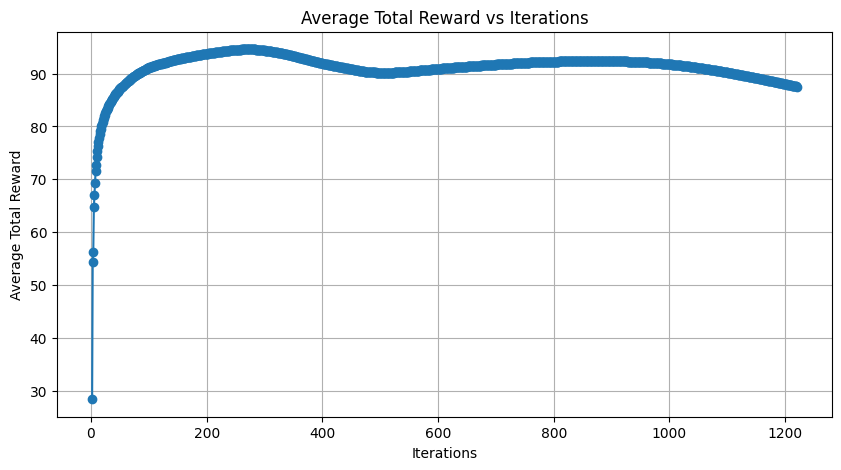

In [18]:
# @title # Plot

def plot_avg_total_reward_vs_iteration(iterations, avg_rewards):
    """
    Plots average total reward vs. iterations.

    Parameters:
    - iterations: list or array-like, iteration numbers.
    - avg_rewards: list or array-like, average total reward at each iteration.
    """

    # TODO: Complete this function to plot the average total reward versus iterations
    # You can use matplotlib for plotting

    plt.figure(figsize=(10, 5))
    plt.plot(iterations, avg_rewards, marker='o')
    plt.xlabel("Iterations")
    plt.ylabel("Average Total Reward")
    plt.title("Average Total Reward vs Iterations")
    plt.grid(True)
    plt.show()


plot_avg_total_reward_vs_iteration(iterations, avg_rewards)